In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import visual_behavior.data_access.loading as loading
import visual_behavior.data_access.utilities as utilities

import visual_behavior.visualization.utils as utils

experience_level_colors = utils.get_experience_level_colors()
cre_line_colors = utils.get_cre_line_colors()

experience_levels = utils.get_new_experience_levels()
cell_types = utils.get_cell_types()

import seaborn as sns
sns.set_context('notebook', font_scale=1.5, rc={'lines.markeredgewidth': 1})

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
from visual_behavior.dimensionality_reduction.clustering import plotting
from visual_behavior.dimensionality_reduction.clustering import processing

import visual_behavior.visualization.ophys.platform_paper_figures as ppf

C:\Users\marinag\Documents\Code\AllenSDK\allensdk\brain_observatory\behavior\behavior_project_cache\behavior_project_cache.py:135: UpdatedStimulusPresentationTableWarning: 
	As of AllenSDK version 2.16.0, the latest Visual Behavior Ophys data has been significantly updated from previous releases. Specifically the user will need to update all processing of the stimulus_presentations tables. These tables now include multiple stimulus types delineated by the columns `stimulus_block` and `stimulus_block_name`.

The data that was available in previous releases are stored in the block name containing 'change_detection' and can be accessed in the pandas table by using: 
	`stimulus_presentations[stimulus_presentations.stimulus_block_name.str.contains('change_detection')]`
  warnings.warn(


In [5]:
import visual_behavior_glm.GLM_fit_dev as gfd
import visual_behavior_glm.GLM_analysis_tools as gat

## Load from saved files 

In [6]:
base_dir = r'\\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_plots\figure_4'

save_dir = os.path.join(base_dir, 'all_cre_clustering_113023')
folder = 'figs'

In [7]:
from allensdk.brain_observatory.behavior.behavior_project_cache import VisualBehaviorOphysProjectCache

platform_cache_dir = loading.get_platform_analysis_cache_dir()
cache = VisualBehaviorOphysProjectCache.from_s3_cache(cache_dir = platform_cache_dir)
experiments_table = cache.get_ophys_experiment_table()
print(len(experiments_table))

1936


C:\Users\marinag\Documents\Code\AllenSDK\allensdk\brain_observatory\behavior\behavior_project_cache\behavior_project_cache.py:135: UpdatedStimulusPresentationTableWarning: 
	As of AllenSDK version 2.16.0, the latest Visual Behavior Ophys data has been significantly updated from previous releases. Specifically the user will need to update all processing of the stimulus_presentations tables. These tables now include multiple stimulus types delineated by the columns `stimulus_block` and `stimulus_block_name`.

The data that was available in previous releases are stored in the block name containing 'change_detection' and can be accessed in the pandas table by using: 
	`stimulus_presentations[stimulus_presentations.stimulus_block_name.str.contains('change_detection')]`
  warnings.warn(


In [56]:
# metadata tables
experiments_table = pd.read_csv(os.path.join(platform_cache_dir, 'all_ophys_experiments_table.csv'), index_col=0)
platform_experiments = pd.read_csv(os.path.join(platform_cache_dir, 'platform_paper_ophys_experiments_table.csv'), index_col=0)
platform_cells_table = pd.read_csv(os.path.join(platform_cache_dir, 'platform_paper_ophys_cells_table.csv'), index_col=0)
matched_cells_table = pd.read_csv(os.path.join(platform_cache_dir, 'platform_paper_matched_ophys_cells_table.csv'), index_col=0)

### Define model version
glm_version = '24_events_all_L2_optimize_by_session'
 
# glm outputs
run_params = pd.read_pickle(os.path.join(platform_cache_dir, 'glm_results', glm_version+'_run_params.pkl'))
# weights_df = pd.read_hdf(os.path.join(platform_cache_dir, 'glm_results', 'weights_df.h5'), key='df')
results = pd.read_hdf(os.path.join(platform_cache_dir, 'glm_results', 'all_results.h5'), key='df')
# all_results_pivoted = pd.read_hdf(os.path.join(platform_cache_dir, 'glm_results', 'results_pivoted.h5'), key='df')

# # split out csid and oeid for results table
# all_results['cell_specimen_id'] = [int(identifier.split('_')[1]) for identifier in all_results.identifier.values]
# all_results['ophys_experiment_id'] = [int(identifier.split('_')[0]) for identifier in all_results.identifier.values]

# # get results and weights just for platform paper experiments
# results_pivoted = pd.read_hdf(os.path.join(platform_cache_dir, 'glm_results', 'platform_results_pivoted.h5'), key='df')
weights_df = pd.read_hdf(os.path.join(platform_cache_dir, 'glm_results', 'platform_results_weights_df.h5'), key='df')
results_pivoted = pd.read_hdf(os.path.join(platform_cache_dir, 'glm_results', 'across_session_normalized_platform_results_pivoted.h5'), key='df')
# now drop ophys_experiment_id
# results_pivoted = results_pivoted.drop(columns=['ophys_experiment_id'])

# clustering results
feature_matrix = pd.read_hdf(os.path.join(platform_cache_dir, 'glm_results', 'clustering_feature_matrix.h5'), key='df')
cluster_meta = pd.read_hdf(os.path.join(platform_cache_dir, 'glm_results', 'cluster_meta.h5'), key='df')

# get lists of matched cells and expts
matched_cells = matched_cells_table.cell_specimen_id.unique()
matched_experiments = matched_cells_table.ophys_experiment_id.unique()

# get cre_lines and cell types for plot labels
cre_lines = np.sort(platform_cells_table.cre_line.unique())
cell_types = utilities.get_cell_types_dict(cre_lines, platform_experiments)


In [13]:
feature_matrix.head()

all-images                     omissions                    \
experience_level   Familiar     Novel   Novel +  Familiar     Novel Novel +   
cell_specimen_id                                                              
1086489847         0.000000  0.060457  0.017832  0.000000  0.000000     0.0   
1086489860         0.000000  0.910349  0.000000  0.000000  0.109417     0.0   
1086489891         0.000000  0.279929  0.000000  0.524089  0.000000     0.0   
1086489976         0.817370  0.000000  0.000000  0.000000  0.000000     0.0   
1086490002         0.852927  0.000000  0.355870  0.000000  0.000000     0.0   

                      task                     behavioral                      
experience_level  Familiar     Novel   Novel +   Familiar     Novel   Novel +  
cell_specimen_id                                                               
1086489847        0.000000  0.004045  0.009827   0.000000  0.084897  0.971563  
1086489860        0.000000  0.000000  0.000000   0.000000  0.000000  0.000000  
1086489891        0.000000  0.025777  0.000000   0.168301  0.008724  1.000000  
1086489976        0.000000  0.000000  0.000000   0.000000  0.000000  0.000000  
1086490002        0.021871  0.000000  0.000000   0.000000  0.000000  0.000000

In [14]:
# get cre_lines and cell types for plot labels
cells_table = platform_cells_table.copy()
# cells_table['experience_level'] = [utils.convert_experience_level(experience_level) for experience_level in cells_table.experience_level.values]

cre_lines = np.sort(cells_table.cre_line.unique())
cell_types = utilities.get_cell_types_dict(cre_lines, platform_experiments)

In [15]:
# confirm that filtered platform experiments and matched cells table have the same number of experiments
print(len(platform_cells_table.cell_specimen_id.unique()))
print(len(matched_cells_table.cell_specimen_id.unique()))

14495
3921


In [16]:
# confirm that filtered platform experiments and matched cells table have the same number of experiments
print(len(platform_experiments))
print(len(platform_cells_table.ophys_experiment_id.unique()))

402
402


In [17]:
print(len(results_pivoted))
print(len(results_pivoted.ophys_experiment_id.unique()))
print(len(results_pivoted.cell_specimen_id.unique()))

11763
393
3921


In [18]:
print(len(feature_matrix))
print(len(cluster_meta.ophys_experiment_id.unique()))
print(len(cluster_meta.index.unique()))

3921
131
3901


## Manually generate data inputs

### get experiment and cell metadata

In [19]:
# # load experiments table
# experiments_table = loading.get_platform_paper_experiment_table(limit_to_closest_active=True)
# # limit to closest familiar and novel active
# experiments_table = utilities.limit_to_last_familiar_second_novel_active(experiments_table)
# experiments_table = utilities.limit_to_containers_with_all_experience_levels(experiments_table)

# # load matched cells table
# cells_table = loading.get_cell_table()
# cells_table = loading.get_matched_cells_table(cells_table)
# matched_cells = cells_table.cell_specimen_id.unique()
# matched_experiments = cells_table.ophys_experiment_id.unique()

# # get cre_lines and cell types for plot labels
# cre_lines = np.sort(cells_table.cre_line.unique())
# cell_types = utilities.get_cell_types_dict(cre_lines, experiments_table)

### load GLM results

#### get GLM results (not across session normalized)

In [20]:
# glm_version = '24_events_all_L2_optimize_by_session'

# run_params, all_results, all_results_pivoted, weights_df = gfd.load_analysis_dfs(glm_version)

#### get across session normalized dropout scores

In [21]:
# import visual_behavior_glm.GLM_across_session as gas

# glm_version = '24_events_all_L2_optimize_by_session'

# # get across session normalized dropout scores
# across_results, failed_cells = gas.load_cells(glm_version, clean_df=True)
# across_results = across_results.set_index('identifier')

# # only use across session values
# across = across_results[[key for key in across_results.keys() if '_across' in key] + ['cell_specimen_id', 'ophys_experiment_id', 'experience_level']]
# results_pivoted = across.copy()
# # rename across session columns 
# results_pivoted = results_pivoted.rename(
#     columns={'omissions_across': 'omissions', 'all-images_across': 'all-images',
#              'behavioral_across': 'behavioral', 'task_across': 'task'})
# print(len(results_pivoted), 'len(results_pivoted)')

# # drop duplicates
# results_pivoted = results_pivoted.drop_duplicates(subset=['cell_specimen_id', 'experience_level'])
# print(len(results_pivoted), 'len(results_pivoted) after dropping duplicates')
        
# print(len(results_pivoted.cell_specimen_id.unique()),
#       'cells in results_pivoted after limiting to strictly matched cells')

# # limit to features used for clustering
# # features = processing.get_features_for_clustering()
# features = ['all-images', 'omissions', 'task', 'behavioral']
# features = [*features, 'ophys_experiment_id']
# results_pivoted = processing.limit_results_pivoted_to_features_for_clustering(results_pivoted, features)

# # flip sign so coding scores are positive
# results_pivoted = processing.flip_sign_of_dropouts(results_pivoted, processing.get_features_for_clustering(), use_signed_weights=False)

# results_pivoted['experience_level'] = [utils.convert_experience_level(experience_level) for experience_level in results_pivoted.experience_level.values]

# # SAVE
# results_pivoted['cell_specimen_id'] = results_pivoted.cell_specimen_id.astype(int) # need to do this to save
# results_pivoted.to_hdf(os.path.join(platform_cache_dir, 'glm_results', 'across_session_normalized_platform_results_pivoted.h5'), key='df')

#### limit GLM results to matched cells and reformat

In [22]:
# # limit to features used for clustering
# # features = processing.get_features_for_clustering()
# features = ['all-images', 'omissions', 'task', 'behavioral']
# features = [*features, 'ophys_experiment_id']
# results_pivoted = processing.limit_results_pivoted_to_features_for_clustering(results_pivoted, features)

# # flip sign so coding scores are positive
# results_pivoted = processing.flip_sign_of_dropouts(results_pivoted, processing.get_features_for_clustering(), use_signed_weights=False)

# # now drop ophys_experiment_id
# results_pivoted = results_pivoted.drop(columns=['ophys_experiment_id'])

In [23]:
# results_pivoted.head()


## Load or generate clustering results


In [24]:
# if 'ophys_experiment_id' in results_pivoted.columns:
#     results_pivoted = results_pivoted.drop(columns=['ophys_experiment_id'])

# feature_matrix = processing.get_feature_matrix_for_clustering(results_pivoted, glm_version, save_dir=save_dir)

# cell_metadata = processing.get_cell_metadata_for_feature_matrix(feature_matrix, cells_table)

# n_clusters = 14 # empirically determined, then validated based on within vs. across cluster variance

# cluster_meta = processing.run_all_cre_clustering(feature_matrix, cells_table, n_clusters, save_dir, folder)

# feature_matrix.to_hdf(os.path.join(platform_cache_dir, 'glm_results', 'clustering_feature_matrix.h5'), key='df')
# cluster_meta.to_hdf(os.path.join(platform_cache_dir, 'glm_results', 'cluster_meta.h5'), key='df')

In [25]:
# # plot within cluster correlations distribution
# plotting.plot_within_cluster_correlations(cluster_meta, sort_order=None, spearman=False, suffix='_'+str(n_clusters)+'_clusters',
#                                                 save_dir=save_dir, folder=folder, ax=None)

## load multi session response dataframes

In [26]:
data_type = 'events'

interpolate = True
output_sampling_rate = 30

# set inclusion criteria
# options: ['active_only', 'closest_familiar_and_novel', 'containers_with_all_levels']


inclusion_criteria = 'platform_experiment_table'

In [27]:
len(experiments_table[experiments_table.reporter_line.str.contains('Ai94')==False])

1880

In [28]:
# params for stim response df creation
event_type = 'all'

# params for mean response df creation
conditions = ['cell_specimen_id', 'is_change']


change_suffix = '_'+utils.get_conditions_string(data_type, conditions)+'_'+inclusion_criteria

multi_session_df = loading.get_multi_session_df_for_conditions(data_type, event_type, conditions, inclusion_criteria, 
                                                        interpolate=interpolate, output_sampling_rate=output_sampling_rate, 
                                                         epoch_duration_mins=None)

# limit to changes, convert experience level and merge with cluster IDs
change_mdf = multi_session_df[multi_session_df.is_change==True]
change_mdf = change_mdf.merge(cluster_meta.reset_index()[['cell_specimen_id', 'cluster_id']], on='cell_specimen_id')

# limit to non-changes, convert experience level and merge with cluster IDs
image_mdf = multi_session_df[(multi_session_df.is_change==False)]
image_mdf = image_mdf.merge(cluster_meta.reset_index()[['cell_specimen_id', 'cluster_id']], on='cell_specimen_id')

C:\Users\marinag\Documents\Code\AllenSDK\allensdk\brain_observatory\behavior\behavior_project_cache\behavior_project_cache.py:135: UpdatedStimulusPresentationTableWarning: 
	As of AllenSDK version 2.16.0, the latest Visual Behavior Ophys data has been significantly updated from previous releases. Specifically the user will need to update all processing of the stimulus_presentations tables. These tables now include multiple stimulus types delineated by the columns `stimulus_block` and `stimulus_block_name`.

The data that was available in previous releases are stored in the block name containing 'change_detection' and can be accessed in the pandas table by using: 
	`stimulus_presentations[stimulus_presentations.stimulus_block_name.str.contains('change_detection')]`
  warnings.warn(


loading files from \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\multi_session_mean_response_dfs\interpolate_30Hz
mean_response_df_events_all_is_change_platform_experiment_table.pkl
loading multi_session_df from saved file at \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\multi_session_mean_response_dfs\interpolate_30Hz\mean_response_df_events_all_is_change_platform_experiment_table.pkl


there are 1881 experiments in the full multi_session_df


C:\Users\marinag\Documents\Code\AllenSDK\allensdk\brain_observatory\behavior\behavior_project_cache\behavior_project_cache.py:135: UpdatedStimulusPresentationTableWarning: 
	As of AllenSDK version 2.16.0, the latest Visual Behavior Ophys data has been significantly updated from previous releases. Specifically the user will need to update all processing of the stimulus_presentations tables. These tables now include multiple stimulus types delineated by the columns `stimulus_block` and `stimulus_block_name`.

The data that was available in previous releases are stored in the block name containing 'change_detection' and can be accessed in the pandas table by using: 
	`stimulus_presentations[stimulus_presentations.stimulus_block_name.str.contains('change_detection')]`
  warnings.warn(


removing 1 problematic experiments
there are 400 experiments in the multi_session_df after limiting to platform experiments
there are 400 experiments after filtering for inclusion criteria -  platform_experiment_table


In [29]:
print(len(multi_session_df.ophys_experiment_id.unique()))


400


In [30]:
print(len(image_mdf.experience_level.unique()))
print(len(image_mdf.ophys_experiment_id.unique()))
print(len(image_mdf.cell_specimen_id.unique()))

3
391
3901


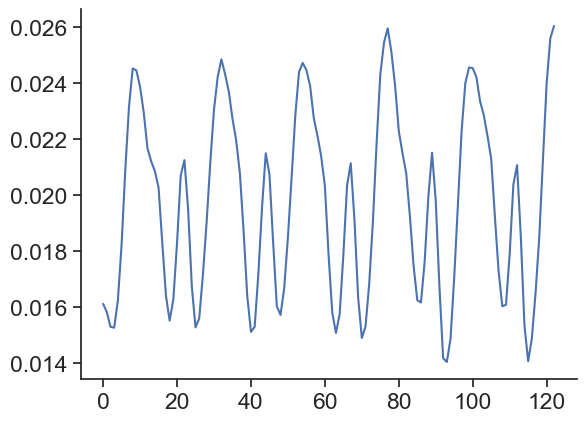

In [32]:
plt.plot(image_mdf.iloc[1].mean_trace)

In [33]:
len(platform_experiments[platform_experiments.project_code=='VisualBehavior'])

75

In [34]:
# params for stim response df creation
event_type = 'all'

# params for mean response df creation
conditions = ['cell_specimen_id', 'omitted']


change_suffix = '_'+utils.get_conditions_string(data_type, conditions)+'_'+inclusion_criteria

omission_mdf = loading.get_multi_session_df_for_conditions(data_type, event_type, conditions, inclusion_criteria, 
                                                        interpolate=interpolate, output_sampling_rate=output_sampling_rate, 
                                                         epoch_duration_mins=None)

omission_mdf = omission_mdf[omission_mdf.omitted==True]
omission_mdf = omission_mdf.merge(cluster_meta.reset_index()[['cell_specimen_id', 'cluster_id']], on='cell_specimen_id')

C:\Users\marinag\Documents\Code\AllenSDK\allensdk\brain_observatory\behavior\behavior_project_cache\behavior_project_cache.py:135: UpdatedStimulusPresentationTableWarning: 
	As of AllenSDK version 2.16.0, the latest Visual Behavior Ophys data has been significantly updated from previous releases. Specifically the user will need to update all processing of the stimulus_presentations tables. These tables now include multiple stimulus types delineated by the columns `stimulus_block` and `stimulus_block_name`.

The data that was available in previous releases are stored in the block name containing 'change_detection' and can be accessed in the pandas table by using: 
	`stimulus_presentations[stimulus_presentations.stimulus_block_name.str.contains('change_detection')]`
  warnings.warn(


loading files from \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\multi_session_mean_response_dfs\interpolate_30Hz
mean_response_df_events_all_omitted_platform_experiment_table.pkl
loading multi_session_df from saved file at \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\multi_session_mean_response_dfs\interpolate_30Hz\mean_response_df_events_all_omitted_platform_experiment_table.pkl
there are 1879 experiments in the full multi_session_df


C:\Users\marinag\Documents\Code\AllenSDK\allensdk\brain_observatory\behavior\behavior_project_cache\behavior_project_cache.py:135: UpdatedStimulusPresentationTableWarning: 
	As of AllenSDK version 2.16.0, the latest Visual Behavior Ophys data has been significantly updated from previous releases. Specifically the user will need to update all processing of the stimulus_presentations tables. These tables now include multiple stimulus types delineated by the columns `stimulus_block` and `stimulus_block_name`.

The data that was available in previous releases are stored in the block name containing 'change_detection' and can be accessed in the pandas table by using: 
	`stimulus_presentations[stimulus_presentations.stimulus_block_name.str.contains('change_detection')]`
  warnings.warn(


removing 1 problematic experiments
there are 401 experiments in the multi_session_df after limiting to platform experiments
there are 401 experiments after filtering for inclusion criteria -  platform_experiment_table


In [35]:
print(len(omission_mdf.experience_level.unique()))
print(len(omission_mdf.ophys_experiment_id.unique()))
print(len(omission_mdf.cell_specimen_id.unique()))

3
392
3901


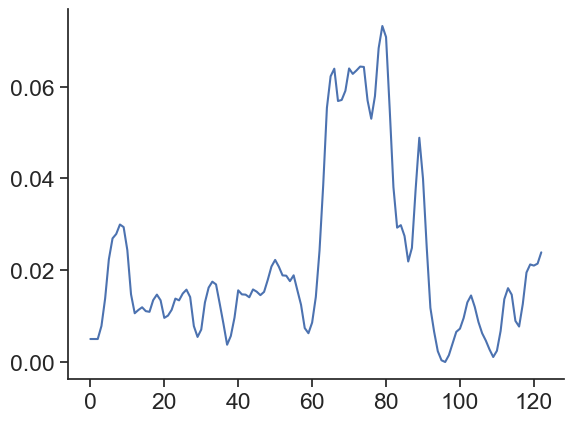

In [36]:
plt.plot(omission_mdf.iloc[1].mean_trace)

## main cluster plots

### heatmaps

In [37]:
import matplotlib

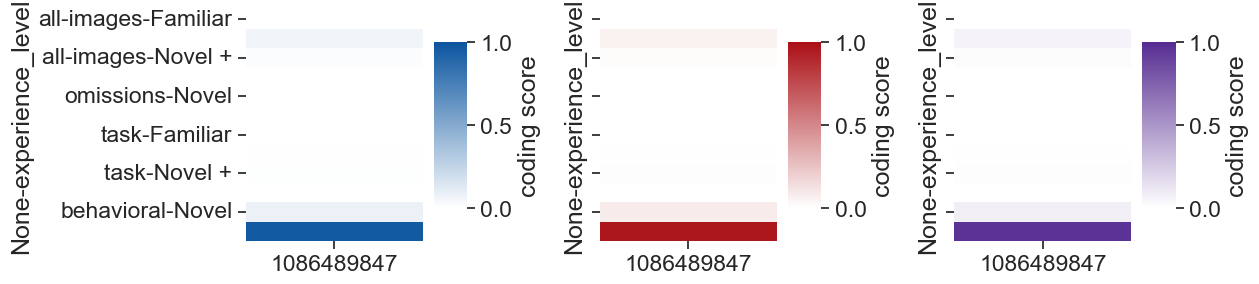

In [38]:
figsize= (12,3)
fig, ax = plt.subplots(1, 3, figsize=figsize, sharey=True)
colors = experience_level_colors.copy()
for i in range (0,3): 
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["white", colors[i]])
    ax[i] = sns.heatmap(pd.DataFrame(feature_matrix.iloc[0]), vmin=0, vmax=1,
                        cmap=cmap, cbar_kws={'aspect':5, 'label':'coding score'}, ax=ax[i])
plt.subplots_adjust(wspace=0.6)

In [39]:
feature_matrix

all-images                     omissions                      \
experience_level   Familiar     Novel   Novel +  Familiar     Novel   Novel +   
cell_specimen_id                                                                
1086489847         0.000000  0.060457  0.017832  0.000000  0.000000  0.000000   
1086489860         0.000000  0.910349  0.000000  0.000000  0.109417  0.000000   
1086489891         0.000000  0.279929  0.000000  0.524089  0.000000  0.000000   
1086489976         0.817370  0.000000  0.000000  0.000000  0.000000  0.000000   
1086490002         0.852927  0.000000  0.355870  0.000000  0.000000  0.000000   
...                     ...       ...       ...       ...       ...       ...   
1120133342         0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
1120133375         0.000000  0.614797  0.000000  0.000000  0.000000  0.000000   
1120133471         0.959608  0.000000  0.000000  0.056069  0.000000  0.000000   
1120133515         0.000000  0.962836  0.813388  0.000000  0.000000  0.000000   
1120133649         0.165861  0.454973  0.196244  0.000000  0.091243  0.051029   

                      task                     behavioral                      
experience_level  Familiar     Novel   Novel +   Familiar     Novel   Novel +  
cell_specimen_id                                                               
1086489847        0.000000  0.004045  0.009827   0.000000  0.084897  0.971563  
1086489860        0.000000  0.000000  0.000000   0.000000  0.000000  0.000000  
1086489891        0.000000  0.025777  0.000000   0.168301  0.008724  1.000000  
1086489976        0.000000  0.000000  0.000000   0.000000  0.000000  0.000000  
1086490002        0.021871  0.000000  0.000000   0.000000  0.000000  0.000000  
...                    ...       ...       ...        ...       ...       ...  
1120133342        0.000000  0.000000  0.000000   0.000000  0.000000  0.000000  
1120133375        0.000000  0.012979  0.000000   0.000000  0.319157  0.000000  
1120133471        0.054291  0.000000  0.000000   0.000000  0.000000  0.000000  
1120133515        0.000000  0.000000  0.000000   0.000000  0.000000  0.232246  
1120133649        0.020329  0.065492  0.068512   0.078284  0.376749  0.350971  

[3921 rows x 12 columns]

C:\Users\marinag\Documents\Code\visual_behavior_analysis\visual_behavior\dimensionality_reduction\clustering\plotting.py:1438: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)
  cre_line_means = feature_matrix.merge(cluster_meta[['cre_line']], on='cell_specimen_id').groupby('cre_line').mean()


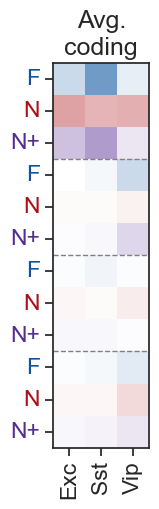

In [41]:
plotting.plot_cre_line_means_remapped(feature_matrix, cluster_meta, save_dir=save_dir, folder=folder, session_colors=True)

C:\Users\marinag\Documents\Code\visual_behavior_analysis\visual_behavior\dimensionality_reduction\clustering\plotting.py:1427: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)
  cluster_means = feature_matrix.merge(cluster_meta[['cluster_id']], on='cell_specimen_id').groupby('cluster_id').mean()


<Axes: title={'center': 'Cluster averages'}, xlabel='Cluster ID'>

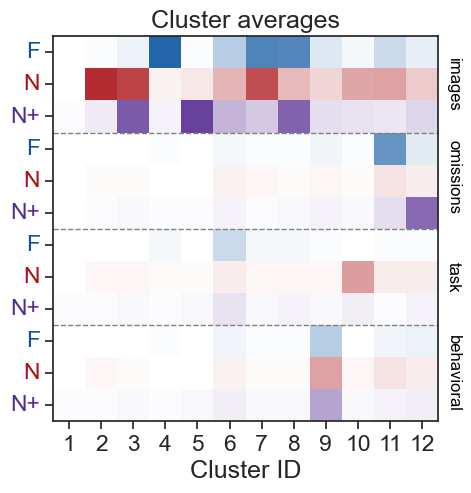

In [42]:
plotting.plot_cluster_means_remapped(feature_matrix, cluster_meta, session_colors=True, save_dir=save_dir, folder=folder, ax=None)

In [ ]:
# plot_cluster_means_remapped(feature_matrix, cluster_meta, orient='horiz', save_dir=save_dir, folder=folder, ax=None)

<Axes: xlabel='cells'>

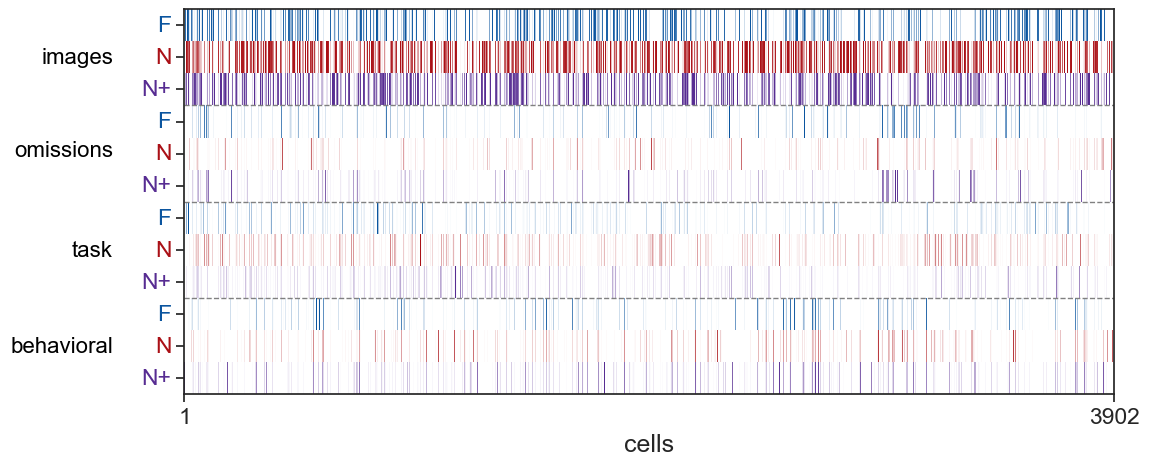

In [44]:
cluster_meta_tmp = cluster_meta.copy()
cluster_meta_tmp['cell_index'] = cluster_meta_tmp.index.values
plotting.plot_coding_score_heatmap_remapped(cluster_meta_tmp, feature_matrix, sort_by=None, session_colors=True,
                                    save_dir=save_dir, folder=folder, ax=None)

<Axes: xlabel='Cluster ID'>

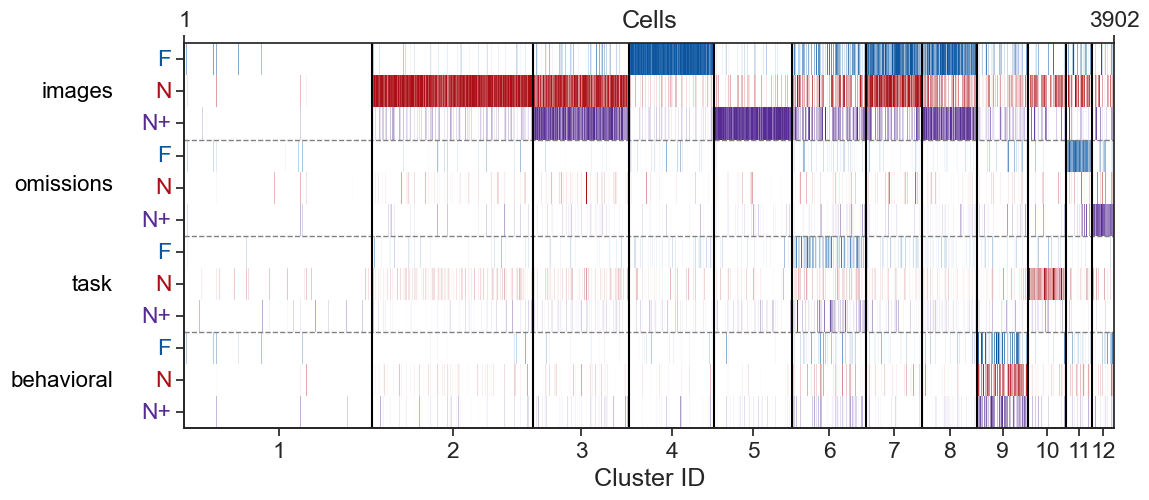

In [45]:
plotting.plot_coding_score_heatmap_remapped(cluster_meta, feature_matrix, sort_by='cluster_id', session_colors=True,
                                    save_dir=save_dir, folder=folder, ax=None)

### fraction cells per cluster per cre

12 12
8 12
10 12


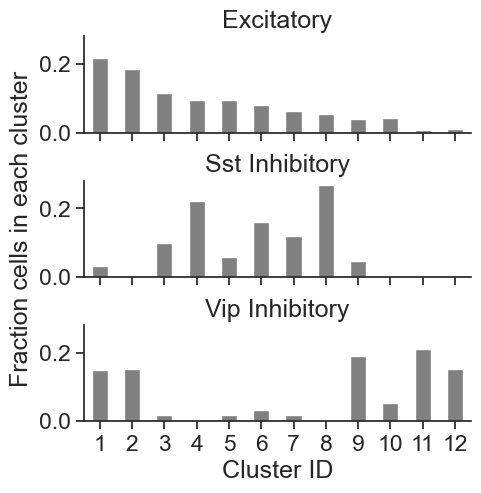

In [48]:
plotting.plot_fraction_cells_per_cluster_per_cre(cluster_meta, col_to_group='cre_line', 
                                                    save_dir=save_dir, folder=folder)

In [49]:
cell_counts = cluster_meta.groupby(['cell_type']).count().rename(columns={'cre_line':'n_cells'})[['n_cells']]
cell_counts

n_cells
cell_type              
Excitatory         3298
Sst Inhibitory      194
Vip Inhibitory      409

In [50]:
cell_counts = cluster_meta.reset_index().drop_duplicates(subset='cell_specimen_id').copy()
cell_counts = cell_counts.groupby(['cell_type']).count()
cell_counts

cell_specimen_id  ophys_experiment_id  cre_line  cluster_id  \
cell_type                                                                     
Excitatory                  3298                 3298      3298        3298   
Sst Inhibitory               194                  194       194         194   
Vip Inhibitory               409                  409       409         409   

                labels  within_cluster_correlation_p  behavior_session_id  \
cell_type                                                                   
Excitatory        3298                          2673                 3298   
Sst Inhibitory     194                           190                  194   
Vip Inhibitory     409                           364                  409   

                ophys_session_id  ophys_container_id  mouse_id  ...  layer  \
cell_type                                                       ...          
Excitatory                  3298                3298      3298  ...   3298   
Sst Inhibitory               194                 194       194  ...    194   
Vip Inhibitory               409                 409       409  ...    409   

                area_layer  date  first_novel  n_relative_to_first_novel  \
cell_type                                                                  
Excitatory            3298  3298         3298                       3298   
Sst Inhibitory         194   194          194                        194   
Vip Inhibitory         409   409          409                        409   

                last_familiar  last_familiar_active  second_novel  \
cell_type                                                           
Excitatory               3298                  3298          3298   
Sst Inhibitory            194                   194           194   
Vip Inhibitory            409                   409           409   

                second_novel_active  experience_exposure  
cell_type                                                 
Excitatory                     3298                 3298  
Sst Inhibitory                  194                  194  
Vip Inhibitory                  409                  409  

[3 rows x 49 columns]

## single cell plots

In [51]:
import visual_behavior.dimensionality_reduction.clustering.single_cell_plots as scp

#### single cell coding heatmap for schematic

<Axes: >

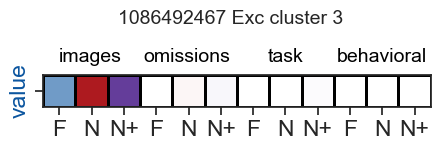

In [57]:
 # get coding scores for this cell

cell_specimen_id = 1086492467 # excitatory cluster 3 cell 
cluster_id = 2
# cell_specimen_id = 1086509065 # Vip cluster 11 cell 

scp.plot_single_cell_coding_heatmap(cluster_id, cell_specimen_id, feature_matrix, cells_table, save_dir=None, folder=None, ax=None)


In [58]:
# for cluster_id in np.sort(cluster_meta.cluster_id.unique()):
#     this_cluster = cluster_meta[cluster_meta.cluster_id==cluster_id]
#     csids = this_cluster.index.unique()
#     cell_roi_ids = cells_table[cells_table.cell_specimen_id.isin(csids)].index.values

#     max_cluster_exp_var = all_results[all_results.cell_roi_id.isin(cell_roi_ids)].sort_values(by='adj_variance_explained_full', ascending=False)
#     max_roi_ids = max_cluster_exp_var.cell_roi_id.values[:50]
#     max_csids = cells_table.loc[max_roi_ids].cell_specimen_id.unique()

#     for cell_specimen_id in max_csids: 
#         plot_single_cell_coding_heatmap(cluster_id, cell_specimen_id, feature_matrix, save_dir=save_dir, folder=folder, ax=None)


### single cell examples from each cluster

C:\Users\marinag\Documents\Code\visual_behavior_analysis\visual_behavior\dimensionality_reduction\clustering\single_cell_plots.py:116: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(features, rotation=0)


<Axes: title={'center': 'cluster 11\nExc cell'}, ylabel='coding score'>

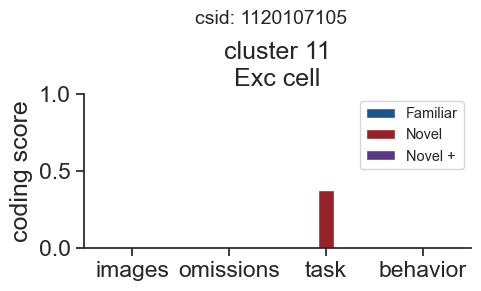

In [59]:
cluster_id = 10
this_cluster = cluster_meta[cluster_meta.cluster_id==cluster_id]
csids = this_cluster.index.unique()
cell_roi_ids = cells_table[cells_table.cell_specimen_id.isin(csids)].index.values

max_cluster_exp_var = all_results[all_results.cell_roi_id.isin(cell_roi_ids)].sort_values(by='adj_variance_explained_full', ascending=False)
max_roi_ids = max_cluster_exp_var.cell_roi_id.values[:50]
max_csids = cells_table.loc[max_roi_ids].cell_specimen_id.unique()

cell_specimen_id = max_csids[0]

scp.plot_coding_scores_example_cell(cluster_id, cell_specimen_id, feature_matrix, cells_table, single_axis=True, save_dir=save_dir, folder=folder, ax=None)

In [60]:
# for cluster_id in np.sort(cluster_meta.cluster_id.unique()):
#     this_cluster = cluster_meta[cluster_meta.cluster_id==cluster_id]
#     csids = this_cluster.index.unique()
#     cell_roi_ids = cells_table[cells_table.cell_specimen_id.isin(csids)].index.values

#     max_cluster_exp_var = results[results.cell_roi_id.isin(cell_roi_ids)].sort_values(by='adj_variance_explained_full', ascending=False)
#     max_roi_ids = max_cluster_exp_var.cell_roi_id.values[:50]
#     max_csids = cells_table.loc[max_roi_ids].cell_specimen_id.unique()

#     for cell_specimen_id in max_csids: 
#         plot_coding_scores_example_cell(cluster_id, cell_specimen_id, feature_matrix, single_axis=True, save_dir=save_dir, folder=folder, ax=None)

### mean response examples

In [61]:
image_responses = image_mdf.copy()
change_responses = change_mdf.copy()
omission_responses = omission_mdf.copy()

array([<Axes: title={'center': 'images'}, xlabel='time (s)', ylabel='response'>,
       <Axes: title={'center': 'omissions'}, xlabel='time (s)'>,
       <Axes: title={'center': 'changes'}, xlabel='time (s)'>],
      dtype=object)

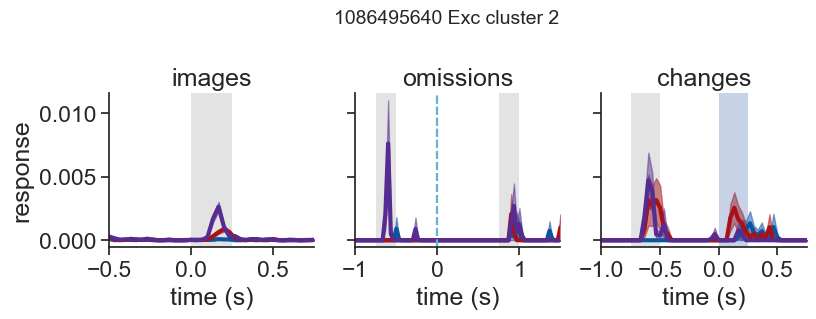

In [62]:
cluster_id = 1

this_cluster = cluster_meta[cluster_meta.cluster_id==cluster_id]
csids = this_cluster.index.unique()
cell_roi_ids = cells_table[cells_table.cell_specimen_id.isin(csids)].index.values

max_cluster_exp_var = results[results.cell_roi_id.isin(cell_roi_ids)].sort_values(by='adj_variance_explained_full', ascending=True)
max_roi_ids = max_cluster_exp_var.cell_roi_id.values[50:100]
max_csids = cells_table.loc[max_roi_ids].cell_specimen_id.unique()

cell_specimen_id = max_csids[0]
    
scp.plot_matched_cell_traces(cluster_id, cell_specimen_id, image_responses, omission_responses, change_responses, cells_table, save_dir=save_dir, folder=folder, ax=None)

In [63]:
# cluster_id = 10

# this_cluster = cluster_meta[cluster_meta.cluster_id==cluster_id]
# csids = this_cluster.index.unique()
# cell_roi_ids = cells_table[cells_table.cell_specimen_id.isin(csids)].index.values

# max_cluster_exp_var = results[results.cell_roi_id.isin(cell_roi_ids)].sort_values(by='adj_variance_explained_full', ascending=True)
# max_roi_ids = max_cluster_exp_var.cell_roi_id.values[50:100]
# max_csids = cells_table.loc[max_roi_ids].cell_specimen_id.unique()

# for cell_specimen_id in max_csids:
    
#     plot_matched_cell_traces(cluster_id, cell_specimen_id, image_responses, omission_responses, change_responses, cells_table, save_dir=save_dir, folder=folder, ax=None)

In [64]:
# omission_responses = omission_mdf.merge(cluster_meta.reset_index()[['cell_specimen_id', 'cluster_id']], on='cell_specimen_id')
# omission_responses = omission_responses[omission_responses.omitted==True]
# image_responses = image_mdf.merge(cluster_meta.reset_index()[['cell_specimen_id', 'cluster_id']], on='cell_specimen_id')
# image_responses = image_responses[image_responses.is_change==False]
# change_responses = change_mdf.merge(cluster_meta.reset_index()[['cell_specimen_id', 'cluster_id']], on='cell_specimen_id')
# change_responses = change_responses[change_responses.is_change==True]


# for cluster_id in np.sort(cluster_meta.cluster_id.unique()):
#     this_cluster = cluster_meta[cluster_meta.cluster_id==cluster_id]
#     csids = this_cluster.index.unique()
#     cell_roi_ids = cells_table[cells_table.cell_specimen_id.isin(csids)].index.values

#     max_cluster_exp_var = all_results[all_results.cell_roi_id.isin(cell_roi_ids)].sort_values(by='adj_variance_explained_full', ascending=False)
#     max_roi_ids = max_cluster_exp_var.cell_roi_id.values[:50]
#     max_csids = cells_table.loc[max_roi_ids].cell_specimen_id.unique()
#     for cell_specimen_id in max_csids:
        
#         plot_matched_cell_traces(cluster_id, cell_specimen_id, image_responses, omission_responses, change_responses, cells_table, save_dir=save_dir, folder=folder, ax=None)

### matched ROIs

Note, this function is very slow because it has to load each dataset from NWb

In [65]:
# cluster_id = 1

# this_cluster = cluster_meta[cluster_meta.cluster_id==cluster_id]
# csids = this_cluster.index.unique()
# cell_roi_ids = cells_table[cells_table.cell_specimen_id.isin(csids)].index.values

# max_cluster_exp_var = all_results[all_results.cell_roi_id.isin(cell_roi_ids)].sort_values(by='adj_variance_explained_full', ascending=False)
# max_roi_ids = max_cluster_exp_var.cell_roi_id.values[:50]
# max_csids = cells_table.loc[max_roi_ids].cell_specimen_id.unique()

# cell_specimen_id = max_csids[0]

# scp.plot_matched_cell_rois(cluster_id, cell_specimen_id, cells_table, save_dir=save_dir, folder=folder, ax=None)

In [66]:

# for cluster_id in np.sort(cluster_meta.cluster_id.unique()):
#     this_cluster = cluster_meta[cluster_meta.cluster_id==cluster_id]
#     csids = this_cluster.index.unique()
#     cell_roi_ids = cells_table[cells_table.cell_specimen_id.isin(csids)].index.values

#     max_cluster_exp_var = results[results.cell_roi_id.isin(cell_roi_ids)].sort_values(by='adj_variance_explained_full', ascending=False)
#     max_roi_ids = max_cluster_exp_var.cell_roi_id.values[:50]
#     max_csids = cells_table.loc[max_roi_ids].cell_specimen_id.unique()
#     for cell_specimen_id in max_csids:
        
#         plot_matched_cell_rois(cluster_id, cell_specimen_id, cells_table, save_dir=save_dir, folder=folder, ax=None)

## cluster properties

### area / depth proportions for cre lines (this should actually be in figure 2)

In [67]:
cre_stats = processing.get_cre_line_stats_for_locations(cluster_meta, location='layer')
cre_stats

n_cells_location  n_cells_total  \
cre_line          layer                                    
Slc17a7-IRES2-Cre lower              1863           3298   
                  upper              1435           3298   
Sst-IRES-Cre      lower               119            194   
                  upper                75            194   
Vip-IRES-Cre      lower                24            409   
                  upper               385            409   

                         fraction_cells_location  
cre_line          layer                           
Slc17a7-IRES2-Cre lower                 0.564888  
                  upper                 0.435112  
Sst-IRES-Cre      lower                 0.613402  
                  upper                 0.386598  
Vip-IRES-Cre      lower                 0.058680  
                  upper                 0.941320

C:\Users\marinag\Documents\Code\visual_behavior_analysis\visual_behavior\dimensionality_reduction\clustering\plotting.py:2169: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax[i] = sns.barplot(data=cre_data, x=metric, y=location, order=order,
C:\Users\marinag\Documents\Code\visual_behavior_analysis\visual_behavior\dimensionality_reduction\clustering\plotting.py:2169: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax[i] = sns.barplot(data=cre_data, x=metric, y=location, order=order,
C:\Users\marinag\Documents\Code\visual_behavior_analysis\visual_behavior\dimensionality_reduction\clustering\plotting.py:2169: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assi

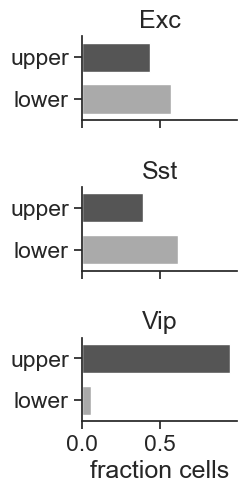

In [68]:
location = 'layer'
order = ['upper', 'lower']
cre_stats = processing.get_cre_line_stats_for_locations(cluster_meta, location)

metric = 'fraction_cells_location'
xlabel = 'fraction cells'

plotting.plot_location_distribution_for_cre_lines(cre_stats, location=location, order=order,
                                            metric=metric, xlabel=xlabel,
                                            sharex=True, ax=None, save_dir=save_dir, folder=folder);


C:\Users\marinag\Documents\Code\visual_behavior_analysis\visual_behavior\dimensionality_reduction\clustering\plotting.py:2169: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax[i] = sns.barplot(data=cre_data, x=metric, y=location, order=order,
C:\Users\marinag\Documents\Code\visual_behavior_analysis\visual_behavior\dimensionality_reduction\clustering\plotting.py:2169: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax[i] = sns.barplot(data=cre_data, x=metric, y=location, order=order,
C:\Users\marinag\Documents\Code\visual_behavior_analysis\visual_behavior\dimensionality_reduction\clustering\plotting.py:2169: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assi

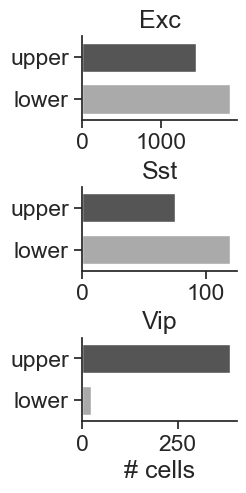

In [69]:
location = 'layer'
order = ['upper', 'lower']
cre_stats = processing.get_cre_line_stats_for_locations(cluster_meta, location)

metric = 'n_cells_location'
xlabel = '# cells'

plotting.plot_location_distribution_for_cre_lines(cre_stats, location=location, order=order,
                                            metric=metric, xlabel=xlabel,
                                            sharex=False, ax=None, save_dir=save_dir, folder=folder);


C:\Users\marinag\Documents\Code\visual_behavior_analysis\visual_behavior\dimensionality_reduction\clustering\plotting.py:2169: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax[i] = sns.barplot(data=cre_data, x=metric, y=location, order=order,
C:\Users\marinag\Documents\Code\visual_behavior_analysis\visual_behavior\dimensionality_reduction\clustering\plotting.py:2169: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax[i] = sns.barplot(data=cre_data, x=metric, y=location, order=order,
C:\Users\marinag\Documents\Code\visual_behavior_analysis\visual_behavior\dimensionality_reduction\clustering\plotting.py:2169: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assi

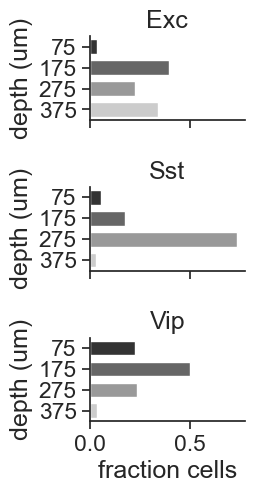

In [70]:
location = 'binned_depth'
order = None
ylabel = 'depth (um)'
cre_stats = processing.get_cre_line_stats_for_locations(cluster_meta, location)

metric = 'fraction_cells_location'
xlabel = 'fraction cells'


plotting.plot_location_distribution_for_cre_lines(cre_stats, location=location, order=order,
                                            metric=metric, xlabel=xlabel, ylabel=ylabel,
                                            sharex=True, ax=None, save_dir=save_dir, folder=folder);


C:\Users\marinag\Documents\Code\visual_behavior_analysis\visual_behavior\dimensionality_reduction\clustering\plotting.py:2169: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax[i] = sns.barplot(data=cre_data, x=metric, y=location, order=order,
C:\Users\marinag\Documents\Code\visual_behavior_analysis\visual_behavior\dimensionality_reduction\clustering\plotting.py:2169: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax[i] = sns.barplot(data=cre_data, x=metric, y=location, order=order,
C:\Users\marinag\Documents\Code\visual_behavior_analysis\visual_behavior\dimensionality_reduction\clustering\plotting.py:2169: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assi

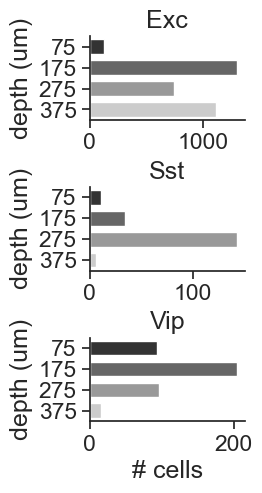

In [71]:
location = 'binned_depth'
order = None
ylabel = 'depth (um)'
cre_stats = processing.get_cre_line_stats_for_locations(cluster_meta, location)

metric = 'n_cells_location'
xlabel = '# cells'


plotting.plot_location_distribution_for_cre_lines(cre_stats, location=location, order=order,
                                            metric=metric, xlabel=xlabel, ylabel=ylabel,
                                            sharex=False, ax=None, save_dir=save_dir, folder=folder);


C:\Users\marinag\Documents\Code\visual_behavior_analysis\visual_behavior\dimensionality_reduction\clustering\plotting.py:2169: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax[i] = sns.barplot(data=cre_data, x=metric, y=location, order=order,
C:\Users\marinag\Documents\Code\visual_behavior_analysis\visual_behavior\dimensionality_reduction\clustering\plotting.py:2169: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax[i] = sns.barplot(data=cre_data, x=metric, y=location, order=order,
C:\Users\marinag\Documents\Code\visual_behavior_analysis\visual_behavior\dimensionality_reduction\clustering\plotting.py:2169: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assi

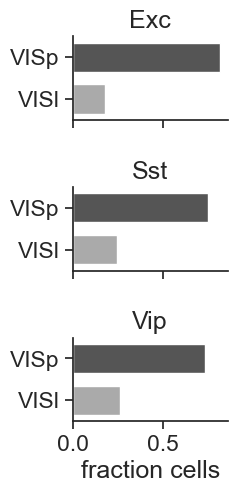

In [72]:
location = 'targeted_structure'
order = ['VISp', 'VISl']
cre_stats = processing.get_cre_line_stats_for_locations(cluster_meta, location)

metric = 'fraction_cells_location'
xlabel = 'fraction cells'

plotting.plot_location_distribution_for_cre_lines(cre_stats, location=location, order=order,
                                            metric=metric, xlabel=xlabel,
                                            sharex=True, ax=None, save_dir=save_dir, folder=folder);


C:\Users\marinag\Documents\Code\visual_behavior_analysis\visual_behavior\dimensionality_reduction\clustering\plotting.py:2169: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax[i] = sns.barplot(data=cre_data, x=metric, y=location, order=order,
C:\Users\marinag\Documents\Code\visual_behavior_analysis\visual_behavior\dimensionality_reduction\clustering\plotting.py:2169: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax[i] = sns.barplot(data=cre_data, x=metric, y=location, order=order,
C:\Users\marinag\Documents\Code\visual_behavior_analysis\visual_behavior\dimensionality_reduction\clustering\plotting.py:2169: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assi

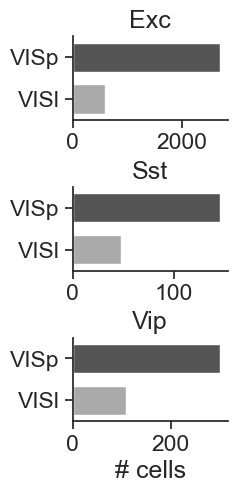

In [73]:
location = 'targeted_structure'
order = ['VISp', 'VISl']
cre_stats = processing.get_cre_line_stats_for_locations(cluster_meta, location)

metric = 'n_cells_location'
xlabel = '# cells'

plotting.plot_location_distribution_for_cre_lines(cre_stats, location=location, order=order,
                                            metric=metric, xlabel=xlabel,
                                            sharex=False, ax=None, save_dir=save_dir, folder=folder);


### population average response per cluster

#### all cell types together

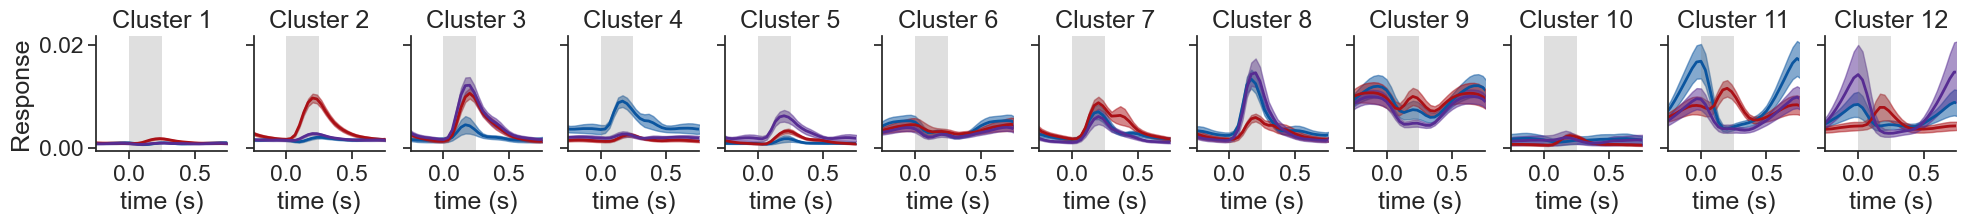

In [74]:
# tmp = image_mdf.merge(cluster_meta.reset_index()[['cell_specimen_id', 'cluster_id']], on='cell_specimen_id')
tmp = image_mdf.copy()
tmp = tmp[(tmp.mean_baseline<np.percentile(tmp.mean_baseline.values, 99.9)) &  (tmp.mean_response<np.percentile(tmp.mean_response.values, 99.8))]

xlim_seconds = [-0.25, 0.75]
timestamps = tmp.trace_timestamps.values[0]

axes_column = 'cluster_id'
hue_column = 'experience_level'

plotting.plot_population_averages_for_clusters(tmp, event_type, axes_column, hue_column, 
                                            xlim_seconds=xlim_seconds, interval_sec=0.5, 
                                            sharey=True, sharex=False, 
                                            ylabel='response', xlabel='time (s)', suptitle=None,
                                            save_dir=save_dir, folder=folder, suffix='_sharey', ax=None);

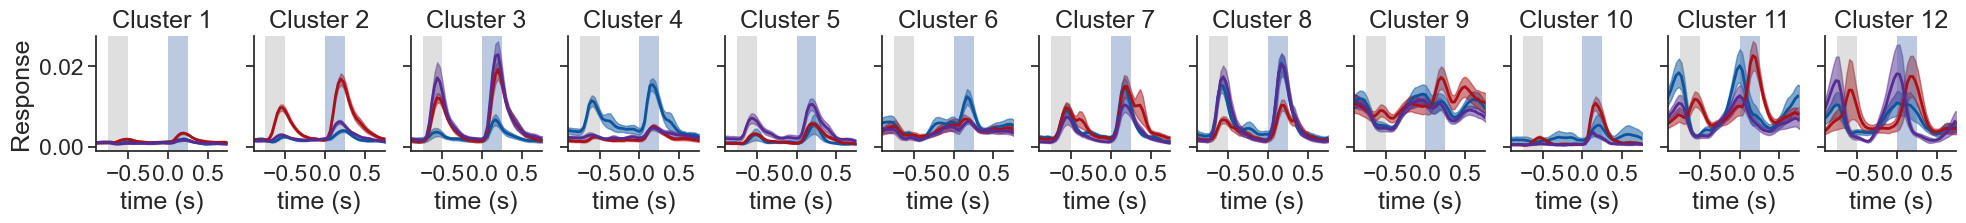

In [75]:
# tmp = change_mdf.merge(cluster_meta.reset_index()[['cell_specimen_id', 'cluster_id']], on='cell_specimen_id')
tmp = change_mdf.copy()
tmp = tmp[(tmp.mean_baseline<np.percentile(tmp.mean_baseline.values, 99.9)) &  (tmp.mean_response<np.percentile(tmp.mean_response.values, 99.8))]

xlim_seconds = [-0.9, 0.75]
timestamps = tmp.trace_timestamps.values[0]

axes_column = 'cluster_id'
hue_column = 'experience_level'

plotting.plot_population_averages_for_clusters(tmp, 'changes', axes_column, hue_column, 
                                            xlim_seconds=xlim_seconds, interval_sec=0.5, 
                                            sharey=True, sharex=False, 
                                            ylabel='response', xlabel='time (s)', suptitle=None,
                                            save_dir=save_dir, folder=folder, suffix='_sharey', ax=None);

In [76]:
# # tmp = change_mdf.merge(cluster_meta.reset_index()[['cell_specimen_id', 'cluster_id']], on='cell_specimen_id')
# tmp = change_mdf.copy()
# tmp = tmp[(tmp.mean_baseline<np.percentile(tmp.mean_baseline.values, 99.9)) &  (tmp.mean_response<np.percentile(tmp.mean_response.values, 99.8))]

# xlim_seconds = [-0.9, 0.75]
# timestamps = tmp.trace_timestamps.values[0]

# axes_column = 'cluster_id'
# hue_column = 'experience_level'

# plotting.plot_population_averages_for_clusters(tmp, 'changes', axes_column, hue_column, 
#                                             xlim_seconds=xlim_seconds, interval_sec=0.5, 
#                                             sharey=False, sharex=False, 
#                                             ylabel='response', xlabel='time (s)', suptitle=None,
#                                             save_dir=save_dir, folder=folder, suffix='_sharey', ax=None);

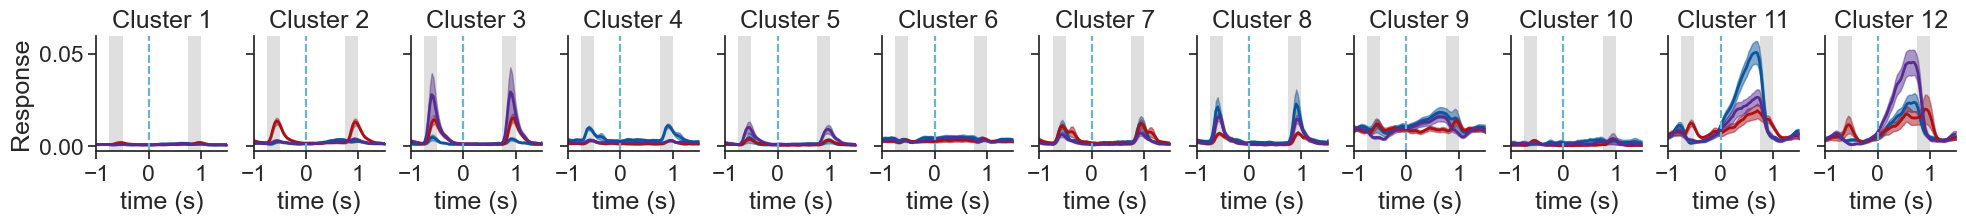

In [77]:
# tmp = omission_mdf.merge(cluster_meta.reset_index()[['cell_specimen_id', 'cluster_id']], on='cell_specimen_id')
tmp = omission_mdf.copy()
tmp = tmp[(tmp.mean_baseline<np.percentile(tmp.mean_baseline.values, 99.9)) &  (tmp.mean_response<np.percentile(tmp.mean_response.values, 99.8))]

xlim_seconds = [-1, 1.5]
timestamps = tmp.trace_timestamps.values[0]

axes_column = 'cluster_id'
hue_column = 'experience_level'

plotting.plot_population_averages_for_clusters(tmp, 'omissions', axes_column, hue_column, 
                                            xlim_seconds=xlim_seconds, interval_sec=1, 
                                            sharey=True, sharex=False, 
                                            ylabel='response', xlabel='time (s)', suptitle=None,
                                            save_dir=save_dir, folder=folder, suffix='_sharey', ax=None);

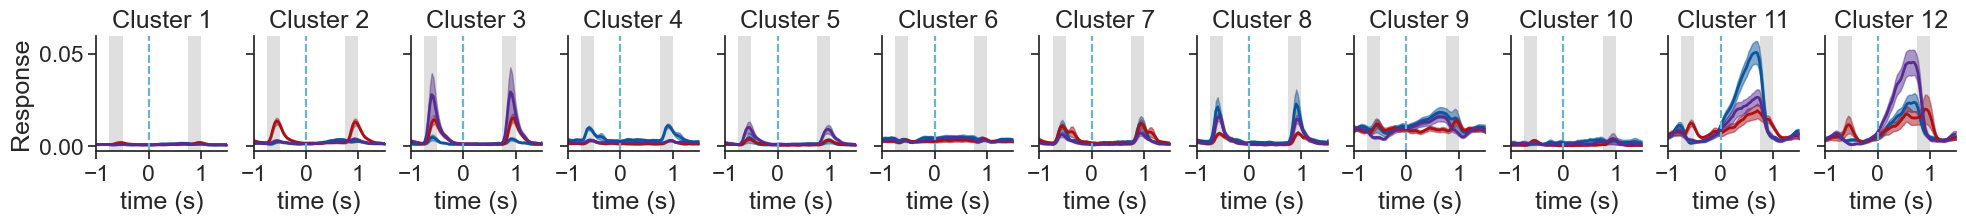

In [78]:
# tmp = omission_mdf.merge(cluster_meta.reset_index()[['cell_specimen_id', 'cluster_id']], on='cell_specimen_id')
tmp = omission_mdf.copy()
tmp = tmp[(tmp.mean_baseline<np.percentile(tmp.mean_baseline.values, 99.9)) &  (tmp.mean_response<np.percentile(tmp.mean_response.values, 99.8))]

xlim_seconds = [-1, 1.5]
timestamps = tmp.trace_timestamps.values[0]

axes_column = 'cluster_id'
hue_column = 'experience_level'

plotting.plot_population_averages_for_clusters(tmp, 'omissions', axes_column, hue_column, 
                                            xlim_seconds=xlim_seconds, interval_sec=1, 
                                            sharey=True, sharex=False, 
                                            ylabel='response', xlabel='time (s)', suptitle=None,
                                            save_dir=save_dir, folder=folder, suffix='_sharey', ax=None);

#### each cre line seprately

In [79]:
# # tmp = image_mdf.merge(cluster_meta.reset_index()[['cell_specimen_id', 'cluster_id']], on='cell_specimen_id')
# tmp = image_mdf.copy()
# tmp = tmp[(tmp.mean_baseline<np.percentile(tmp.mean_baseline.values, 99.9)) &  (tmp.mean_response<np.percentile(tmp.mean_response.values, 99.9))]

# xlim_seconds = [-0.5, 0.7]
# timestamps = tmp.trace_timestamps.values[0]

# plotting.plot_population_averages_for_conditions_multi_row(tmp, data_type, 'all', axes_column='cre_line', hue_column='experience_level', row_column='cluster_id',
#                                             timestamps=None, xlim_seconds=xlim_seconds, interval_sec=0.5, sharey=False, sharex=False, palette=None, 
#                                             ylabel='response', xlabel='time (s)', title=None, suptitle=None,
#                                             save_dir=save_dir, folder=folder, suffix='_images_clusters', ax=None);

no data for 1 Novel +
no data for 2 Novel +
no data for 3 Novel +
no data for 4 Novel +
no data for 5 Novel +
no data for 6 Novel +
no data for 7 Novel +
no data for 8 Novel +
no data for 9 Novel +
no data for 10 Novel +
no data for 11 Novel +
no data for 12 Novel +
no data for 1 Novel +
no data for 2 Novel +
no data for 3 Novel +
no data for 4 Novel +
no data for 5 Novel +
no data for 6 Novel +
no data for 7 Novel +
no data for 8 Novel +
no data for 9 Novel +
no data for 10 Novel +
no data for 11 Novel +
no data for 12 Novel +
no data for 1 Novel +
no data for 2 Novel +
no data for 3 Novel +
no data for 4 Novel +
no data for 5 Novel +
no data for 6 Novel +
no data for 7 Novel +
no data for 8 Novel +
no data for 9 Novel +
no data for 10 Novel +
no data for 11 Novel +
no data for 12 Novel +


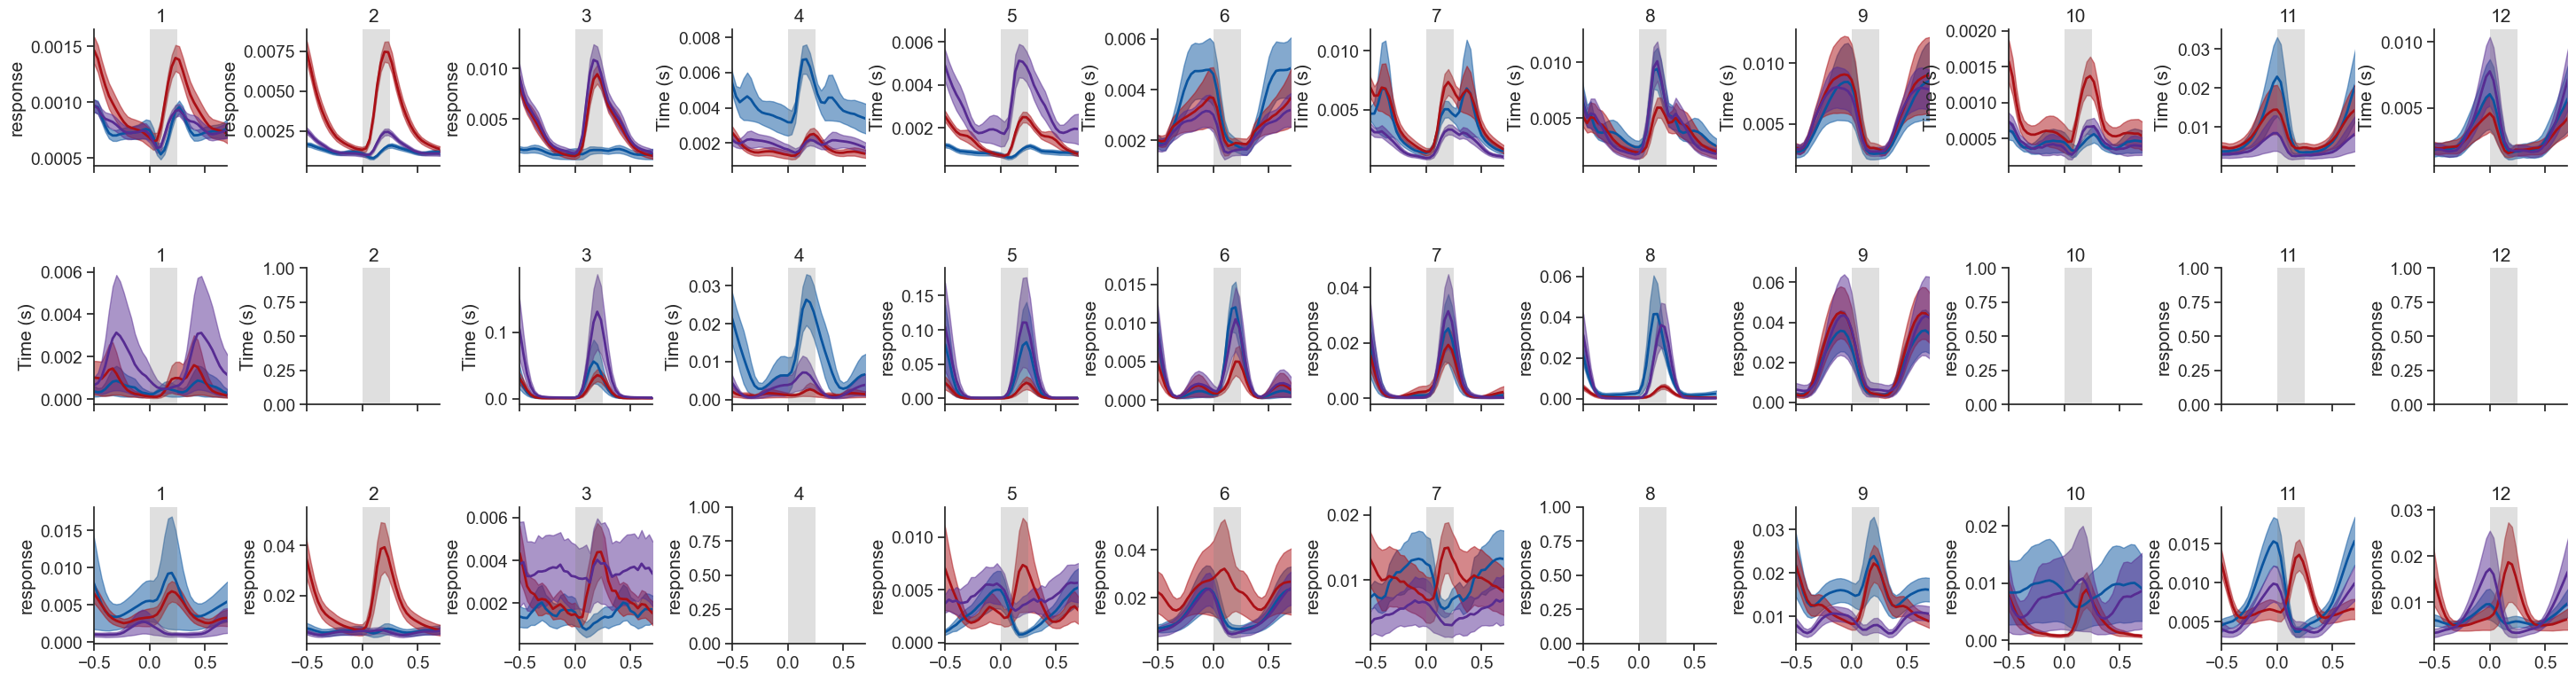

In [80]:
# tmp = image_mdf.merge(cluster_meta.reset_index()[['cell_specimen_id', 'cluster_id']], on='cell_specimen_id')
tmp = image_mdf.copy()
tmp = tmp[(tmp.mean_baseline<np.percentile(tmp.mean_baseline.values, 99.9)) &  (tmp.mean_response<np.percentile(tmp.mean_response.values, 99.9))]

xlim_seconds = [-0.5, 0.7]
timestamps = tmp.trace_timestamps.values[0]

plotting.plot_population_averages_for_conditions_multi_row(tmp, data_type, 'all', 
                                            row_column='cre_line', hue_column='experience_level', axes_column='cluster_id',
                                            timestamps=None, xlim_seconds=xlim_seconds, interval_sec=0.5, sharey=False, sharex=True, palette=None, 
                                            ylabel='response', xlabel='time (s)', title=None, suptitle=None,
                                            save_dir=save_dir, folder=folder, suffix='_images_clusters', ax=None);

no data for 1 Novel +
no data for 2 Novel +
no data for 3 Novel +
no data for 4 Novel +
no data for 5 Novel +
no data for 6 Novel +
no data for 7 Novel +
no data for 8 Novel +
no data for 9 Novel +
no data for 10 Novel +
no data for 11 Novel +
no data for 12 Novel +
no data for 1 Novel +
no data for 2 Novel +
no data for 3 Novel +
no data for 4 Novel +
no data for 5 Novel +
no data for 6 Novel +
no data for 7 Novel +
no data for 8 Novel +
no data for 9 Novel +
no data for 10 Novel +
no data for 11 Novel +
no data for 12 Novel +
no data for 1 Novel +
no data for 2 Novel +
no data for 3 Novel +
no data for 4 Novel +
no data for 5 Novel +
no data for 6 Novel +
no data for 7 Novel +
no data for 8 Novel +
no data for 9 Novel +
no data for 10 Novel +
no data for 11 Novel +
no data for 12 Novel +


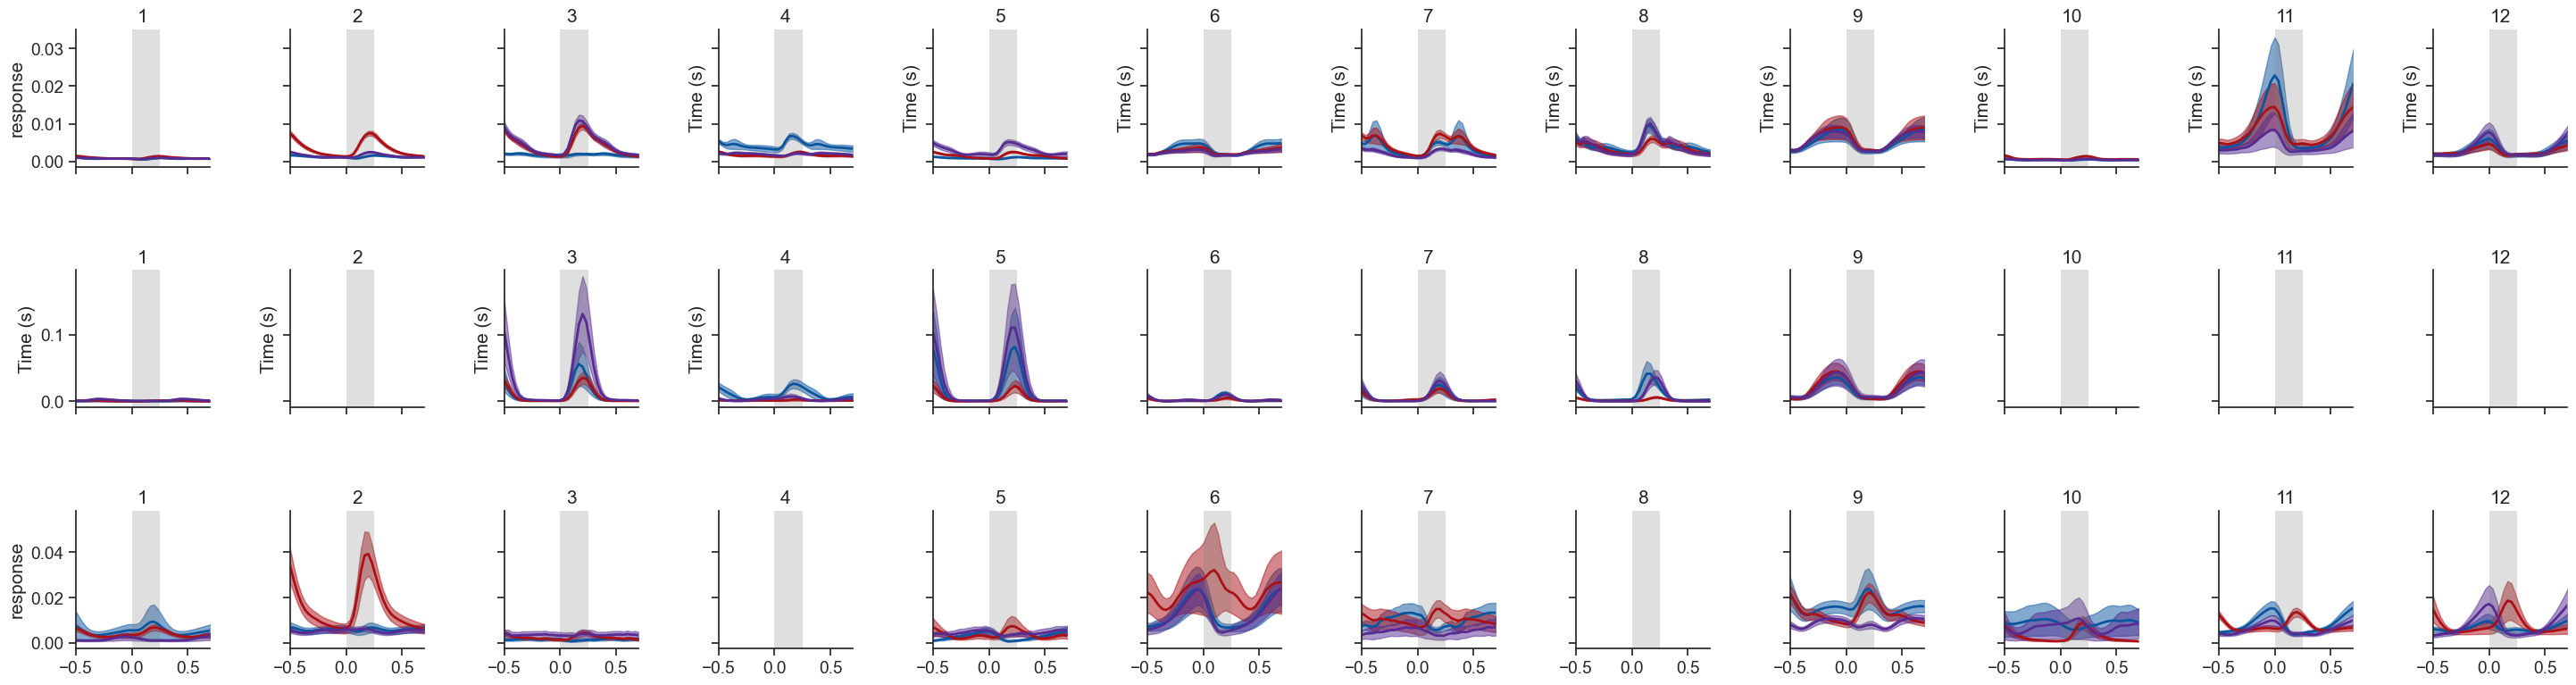

In [81]:
# tmp = image_mdf.merge(cluster_meta.reset_index()[['cell_specimen_id', 'cluster_id']], on='cell_specimen_id')
tmp = image_mdf.copy()
tmp = tmp[(tmp.mean_baseline<np.percentile(tmp.mean_baseline.values, 99.9)) &  (tmp.mean_response<np.percentile(tmp.mean_response.values, 99.9))]

xlim_seconds = [-0.5, 0.7]
timestamps = tmp.trace_timestamps.values[0]

plotting.plot_population_averages_for_conditions_multi_row(tmp, data_type, 'all', 
                                            row_column='cre_line', hue_column='experience_level', axes_column='cluster_id',
                                            timestamps=None, xlim_seconds=xlim_seconds, interval_sec=0.5, sharey='row', sharex=True, palette=None, 
                                            ylabel='response', xlabel='time (s)', title=None, suptitle=None,
                                            save_dir=save_dir, folder=folder, suffix='_images_clusters', ax=None);

In [82]:
# # tmp = change_mdf.merge(cluster_meta.reset_index()[['cell_specimen_id', 'cluster_id']], on='cell_specimen_id')
# tmp = change_mdf.copy()
# tmp = tmp[(tmp.mean_baseline<np.percentile(tmp.mean_baseline.values, 99.9)) &  (tmp.mean_response<np.percentile(tmp.mean_response.values, 99.9))]

# xlim_seconds = [-0.95, 0.7]
# timestamps = tmp.trace_timestamps.values[0]

# plotting.plot_population_averages_for_conditions_multi_row(tmp, data_type, 'changes', axes_column='cre_line', hue_column='experience_level', row_column='cluster_id',
#                                             timestamps=None, xlim_seconds=xlim_seconds, interval_sec=0.5, sharey=False, sharex=False, palette=None, 
#                                             ylabel='response', xlabel='time (s)', title=None, suptitle=None,
#                                             save_dir=save_dir, folder=folder, suffix='_changes_clusters_per_cre', ax=None);

no data for 1 Novel +
no data for 2 Novel +
no data for 3 Novel +
no data for 4 Novel +
no data for 5 Novel +
no data for 6 Novel +
no data for 7 Novel +
no data for 8 Novel +
no data for 9 Novel +
no data for 10 Novel +
no data for 11 Novel +
no data for 12 Novel +
no data for 1 Novel +
no data for 2 Novel +
no data for 3 Novel +
no data for 4 Novel +
no data for 5 Novel +
no data for 6 Novel +
no data for 7 Novel +
no data for 8 Novel +
no data for 9 Novel +
no data for 10 Novel +
no data for 11 Novel +
no data for 12 Novel +
no data for 1 Novel +
no data for 2 Novel +
no data for 3 Novel +
no data for 4 Novel +
no data for 5 Novel +
no data for 6 Novel +
no data for 7 Novel +
no data for 8 Novel +
no data for 9 Novel +
no data for 10 Novel +
no data for 11 Novel +
no data for 12 Novel +


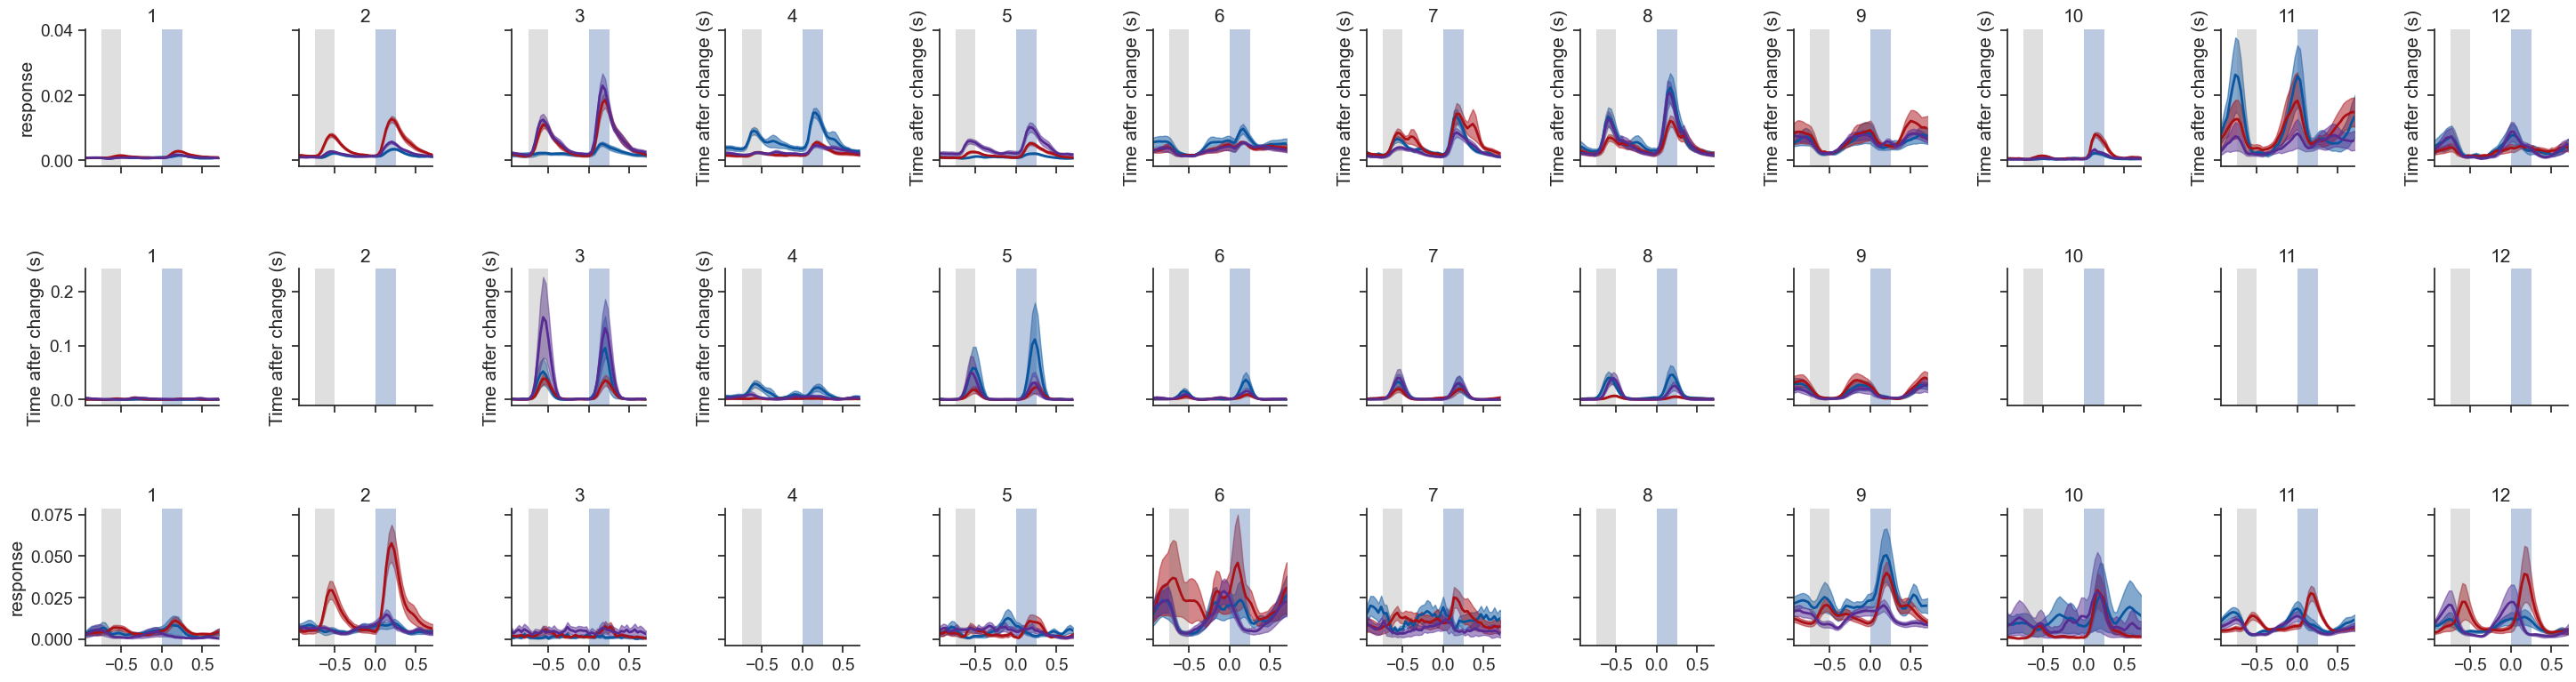

In [83]:
# tmp = change_mdf.merge(cluster_meta.reset_index()[['cell_specimen_id', 'cluster_id']], on='cell_specimen_id')
tmp = change_mdf.copy()
tmp = tmp[(tmp.mean_baseline<np.percentile(tmp.mean_baseline.values, 99.9)) &  (tmp.mean_response<np.percentile(tmp.mean_response.values, 99.9))]

xlim_seconds = [-0.95, 0.7]
timestamps = tmp.trace_timestamps.values[0]

plotting.plot_population_averages_for_conditions_multi_row(tmp, data_type, 'changes', 
                                            row_column='cre_line', hue_column='experience_level', axes_column='cluster_id',
                                            timestamps=None, xlim_seconds=xlim_seconds, interval_sec=0.5, sharey='row', sharex=True, palette=None, 
                                            ylabel='response', xlabel='time (s)', title=None, suptitle=None,
                                            save_dir=save_dir, folder=folder, suffix='_changes_clusters_per_cre', ax=None);

In [84]:
# # tmp = omission_mdf.merge(cluster_meta.reset_index()[['cell_specimen_id', 'cluster_id']], on='cell_specimen_id')
# tmp = omission_mdf.copy()
# tmp = tmp[(tmp.mean_baseline<np.percentile(tmp.mean_baseline.values, 99.9)) &  (tmp.mean_response<np.percentile(tmp.mean_response.values, 99.9))]

# xlim_seconds = [-1, 1.5]
# timestamps = tmp.trace_timestamps.values[0]

# plotting.plot_population_averages_for_conditions_multi_row(tmp, data_type, 'omissions', axes_column='cre_line', hue_column='experience_level', row_column='cluster_id',
#                                             timestamps=None, xlim_seconds=xlim_seconds, interval_sec=0.5, sharey=False, sharex=False, palette=None, 
#                                             ylabel='response', xlabel='time (s)', title=None, suptitle=None,
#                                             save_dir=save_dir, folder=folder, suffix='_omissions_clusters_per_cre', ax=None);

no data for 1 Novel +
no data for 2 Novel +
no data for 3 Novel +
no data for 4 Novel +
no data for 5 Novel +
no data for 6 Novel +
no data for 7 Novel +
no data for 8 Novel +
no data for 9 Novel +
no data for 10 Novel +
no data for 11 Novel +
no data for 12 Novel +
no data for 1 Novel +
no data for 2 Novel +
no data for 3 Novel +
no data for 4 Novel +
no data for 5 Novel +
no data for 6 Novel +
no data for 7 Novel +
no data for 8 Novel +
no data for 9 Novel +
no data for 10 Novel +
no data for 11 Novel +
no data for 12 Novel +
no data for 1 Novel +
no data for 2 Novel +
no data for 3 Novel +
no data for 4 Novel +
no data for 5 Novel +
no data for 6 Novel +
no data for 7 Novel +
no data for 8 Novel +
no data for 9 Novel +
no data for 10 Novel +
no data for 11 Novel +
no data for 12 Novel +


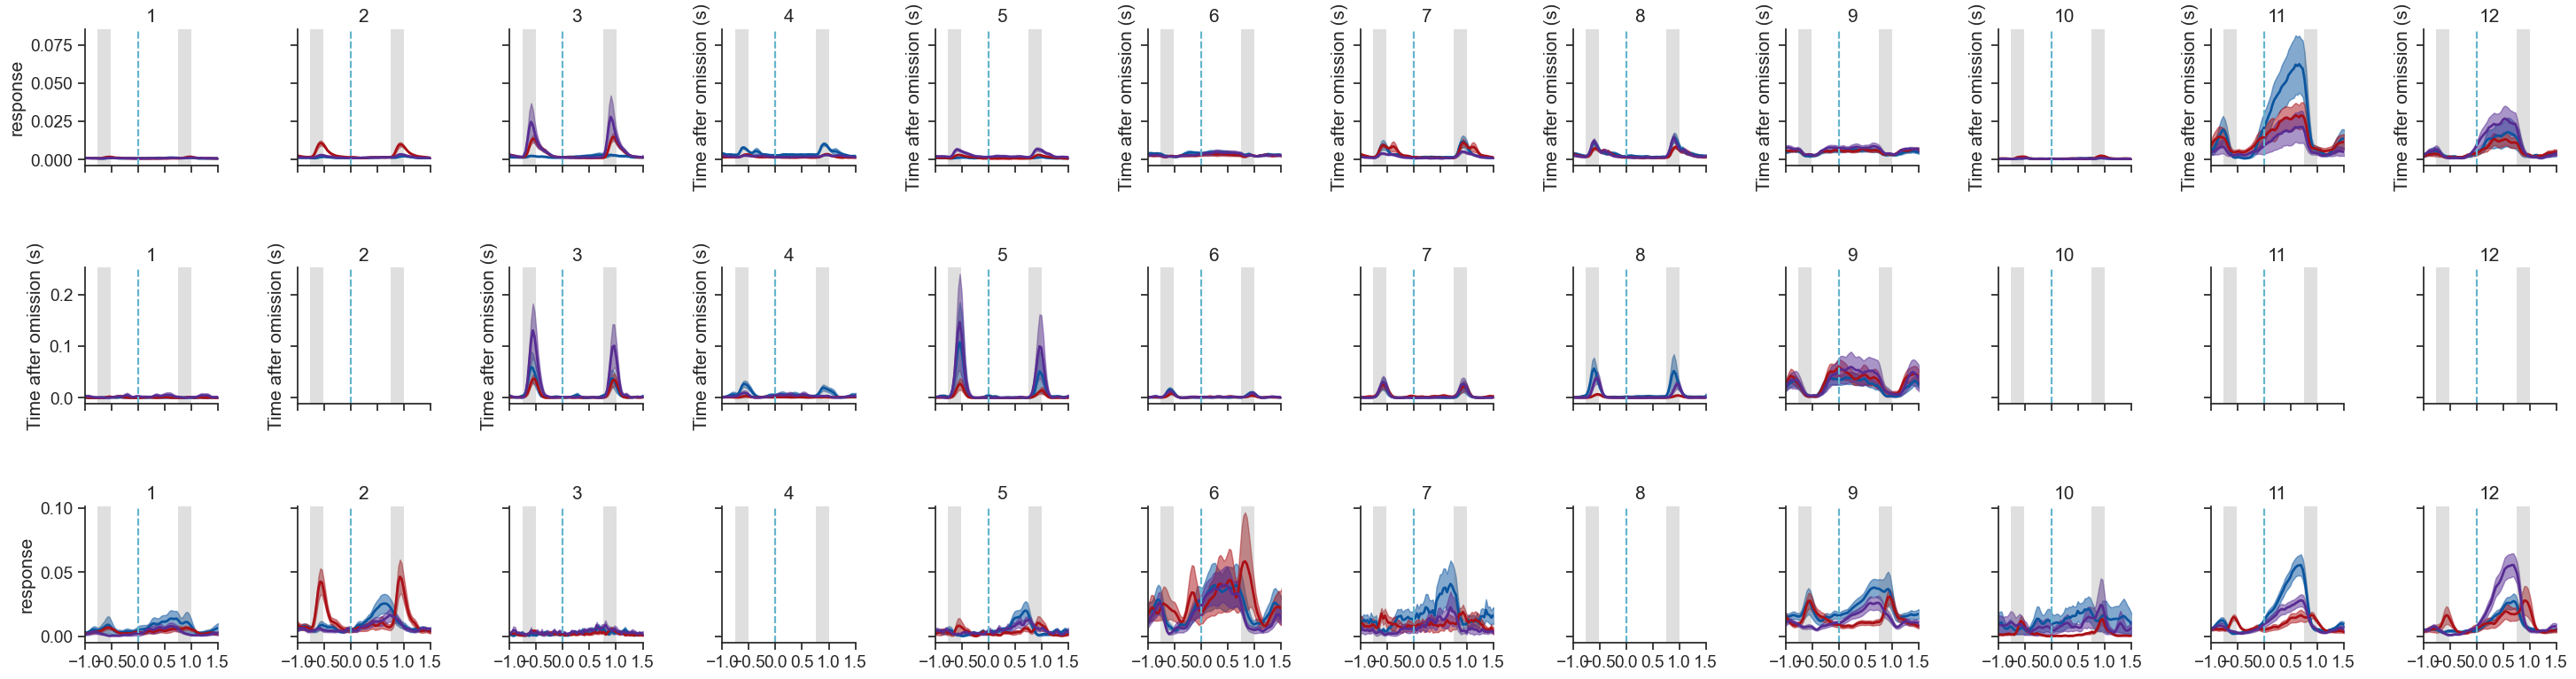

In [85]:
# tmp = omission_mdf.merge(cluster_meta.reset_index()[['cell_specimen_id', 'cluster_id']], on='cell_specimen_id')
tmp = omission_mdf.copy()
tmp = tmp[(tmp.mean_baseline<np.percentile(tmp.mean_baseline.values, 99.9)) &  (tmp.mean_response<np.percentile(tmp.mean_response.values, 99.9))]

xlim_seconds = [-1, 1.5]
timestamps = tmp.trace_timestamps.values[0]

plotting.plot_population_averages_for_conditions_multi_row(tmp, data_type, 'omissions', 
                                            row_column='cre_line', hue_column='experience_level', axes_column='cluster_id',
                                            timestamps=None, xlim_seconds=xlim_seconds, interval_sec=0.5, sharey='row', sharex=True, palette=None, 
                                            ylabel='response', xlabel='time (s)', title=None, suptitle=None,
                                            save_dir=save_dir, folder=folder, suffix='_omissions_clusters_per_cre', ax=None);

#### population averages in a 4x3 grid

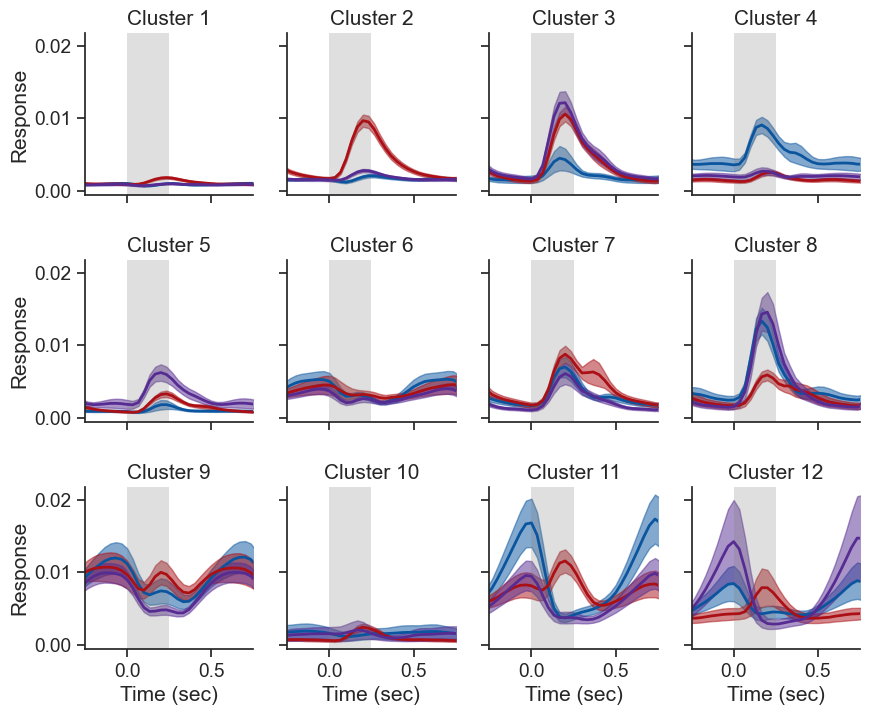

In [86]:
# tmp = image_mdf.merge(cluster_meta.reset_index()[['cell_specimen_id', 'cluster_id']], on='cell_specimen_id')
tmp = image_mdf.copy()
tmp = tmp[(tmp.mean_baseline<np.percentile(tmp.mean_baseline.values, 99.9)) &  (tmp.mean_response<np.percentile(tmp.mean_response.values, 99.8))]

xlim_seconds = [-0.25, 0.75]
timestamps = tmp.trace_timestamps.values[0]

axes_column = 'cluster_id'
hue_column = 'experience_level'

plotting.plot_population_averages_for_clusters_grid(tmp, event_type, axes_column, hue_column, 
                                            xlim_seconds=xlim_seconds, interval_sec=0.5, 
                                            sharey=True, sharex=True, 
                                            ylabel='response', xlabel='time (s)', suptitle=None,
                                            save_dir=save_dir, folder=folder, suffix='_sharey', ax=None);

#### heatmap of image responses per cluster 

In [87]:
# tmp = image_mdf.copy() #merge(cluster_meta.reset_index()[['cell_specimen_id', 'cluster_id']], on='cell_specimen_id')

# xlim_seconds=[-0.5, 0.75]

# event_type = 'all'

# timestamps = tmp.trace_timestamps.values[0]
# row_condition = 'experience_level'
# col_condition = 'cluster_id'
# cols_to_sort_by = ['mean_response']

# for cre_line in tmp.cre_line.unique():
#     df = tmp[tmp.cre_line==cre_line]


#     ppf.plot_response_heatmaps_for_conditions(df, timestamps, data_type, 'all',
#                                           row_condition, col_condition, cols_to_sort_by=cols_to_sort_by, suptitle=cre_line,
#                                           microscope=None, vmax=None, xlim_seconds=xlim_seconds, match_cells=False, cbar=False,
#                                           save_dir=None, folder=folder, suffix='', ax=None)


#### heatmap of omission responses per clsuter

In [88]:
# tmp = omission_mdf.copy() #merge(cluster_meta.reset_index()[['cell_specimen_id', 'cluster_id']], on='cell_specimen_id')

# xlim_seconds=[-1, 1.5]

# event_type = 'all'

# timestamps = tmp.trace_timestamps.values[0]
# row_condition = 'experience_level'
# col_condition = 'cluster_id'
# cols_to_sort_by = ['mean_response']

# for cre_line in tmp.cre_line.unique():
#     df = tmp[tmp.cre_line==cre_line]


#     ppf.plot_response_heatmaps_for_conditions(df, timestamps, data_type, 'omissions',
#                                           row_condition, col_condition, cols_to_sort_by=cols_to_sort_by, suptitle=cre_line,
#                                           microscope=None, vmax=None, xlim_seconds=xlim_seconds, match_cells=False, cbar=False,
#                                           save_dir=None, folder=folder, suffix='', ax=None)


### compare various functions for area depth proportions

In [89]:
import visual_behavior_glm.GLM_clustering as glm_clust

In [90]:
cluster_meta.layer.unique()

array(['upper', 'lower'], dtype=object)

In [91]:
# locations = np.sort(cluster_meta.layer.unique())
# df = cluster_meta.copy().reset_index()
# df['location'] = df.layer

# stats_table = glm_clust.stats(df, cre_lines[0], locations, test='chi_squared_')
# stats_table.head()

In [92]:
# this gets the number of cells in different locations compared to the total
n_cells = processing.get_n_cells_per_location_for_clusters(cluster_meta, location='layer')
n_cells.head()

n_cells_lower  n_cells_upper  n_cells_cluster  \
cre_line          cluster_id                                                  
Slc17a7-IRES2-Cre 1                   243.0          479.0              722   
                  2                   309.0          302.0              611   
                  3                   206.0          171.0              377   
                  4                   223.0           90.0              313   
                  5                   178.0          132.0              310   

                              n_cells_total_lower  n_cells_total_upper  
cre_line          cluster_id                                            
Slc17a7-IRES2-Cre 1                          1863                 1435  
                  2                          1863                 1435  
                  3                          1863                 1435  
                  4                          1863                 1435  
                  5                          1863                 1435

In [93]:
# this gets the fraction of cells in different locations relative to the total
fraction_cells = processing.get_fraction_cells_relative_to_cluster_size(cluster_meta, location='layer')
fraction_cells.head()

fraction_cells_lower  fraction_cells_upper  \
cre_line          cluster_id                                               
Slc17a7-IRES2-Cre 1                       0.130435              0.333798   
                  2                       0.165862              0.210453   
                  3                       0.110574              0.119164   
                  4                       0.119699              0.062718   
                  5                       0.095545              0.091986   

                              fraction_cells_cluster  average_of_locations  \
cre_line          cluster_id                                                 
Slc17a7-IRES2-Cre 1                         0.218921              0.232116   
                  2                         0.185264              0.188157   
                  3                         0.114312              0.114869   
                  4                         0.094906              0.091209   
                  5                         0.093996              0.093765   

                              fraction_of_cluster_size_lower  \
cre_line          cluster_id                                   
Slc17a7-IRES2-Cre 1                                 0.595809   
                  2                                 0.895272   
                  3                                 0.967306   
                  4                                 1.261242   
                  5                                 1.016474   

                              fraction_of_cluster_size_upper  
cre_line          cluster_id                                  
Slc17a7-IRES2-Cre 1                                 1.524744  
                  2                                 1.135964  
                  3                                 1.042446  
                  4                                 0.660841  
                  5                                 0.978613

In [94]:
location = 'layer'

locations = np.sort(cluster_meta[location].unique())

# get number of cells in each location for each cluster in each cre line
n_cells_per_location_per_cluster = cluster_meta.reset_index().groupby(['cre_line', 'cluster_id', location])[
    'cell_specimen_id'].count().to_frame(name='n_cells_location')
# get total number of cells in each location for each cre line
# n_cells_per_location = cluster_meta.reset_index().groupby(['cre_line', location])['cell_specimen_id'].count().unstack()
n_cells_per_location = cluster_meta.reset_index().groupby(['cre_line', location])[
    'cell_specimen_id'].count().to_frame(name='n_cells_location_total')
# merge them and compute fraction of cells in each cluster for each location
n_cells_table = n_cells_per_location_per_cluster.copy()
n_cells_table = n_cells_table.reset_index().merge(n_cells_per_location.reset_index(), on=['cre_line', location],
                                                    how='left')
n_cells_table['fraction_cells_location'] = n_cells_table['n_cells_location'] / n_cells_table[
    'n_cells_location_total']


In [98]:

# get number of cells per cluster per cre line
n_cells_per_cluster = cluster_meta.reset_index().groupby(['cre_line', 'cluster_id']).count()[['cell_specimen_id']]
n_cells_per_cluster = n_cells_per_cluster.rename(columns={'cell_specimen_id': 'n_cells_cluster'})
# number of cells per cre line
n_cells_per_cre = cluster_meta.reset_index().groupby(['cre_line']).count()[['cell_specimen_id']]
n_cells_per_cre = n_cells_per_cre.rename(columns={'cell_specimen_id': 'n_cells_cre'})
# fraction cells per cluster per cre line
n_cells_table = n_cells_table.merge(n_cells_per_cluster.reset_index(), on=['cre_line', 'cluster_id'], how='left')
n_cells_table = n_cells_table.merge(n_cells_per_cre.reset_index(), on=['cre_line'], how='left')
n_cells_table['fraction_cells_cluster'] = n_cells_table['n_cells_cluster'] / n_cells_table['n_cells_cre']
# compute the proportion of cells in a given location for each cluster/cre relative to the proportion of cells in that cluster/cre
n_cells_table['fraction_of_cluster_size'] = n_cells_table['fraction_cells_location'] / n_cells_table[
    'fraction_cells_cluster']
# how many cells would you expect per location by chance, assuming fraction of cells in each location is equal to overall size of cluster
# i.e. null hypothesis that cells are evenly distributed across locations within each cluster (accounting for bias in overall # cells per location)
n_cells_table['n_cells_chance_location'] = n_cells_table['fraction_cells_cluster'] * n_cells_table[
    'n_cells_location_total']

# STATS
# make sure index is properly set before doing stats
n_cells_table = n_cells_table.set_index(['cre_line', 'cluster_id', location])
# chi square test for significance of actual cell counts per location/cluster vs chance level based on cluster size
n_cells_table = processing.add_stats_for_location_comparison_to_cluster_proportion_stats(n_cells_table)

C:\Users\marinag\AppData\Local\Temp\ipykernel_8272\2113548812.py:8: FutureWarning: Passing 'suffixes' which cause duplicate columns {'n_cells_cluster_x'} in the result is deprecated and will raise a MergeError in a future version.
  n_cells_table = n_cells_table.merge(n_cells_per_cluster.reset_index(), on=['cre_line', 'cluster_id'], how='left')
C:\Users\marinag\AppData\Local\Temp\ipykernel_8272\2113548812.py:9: FutureWarning: Passing 'suffixes' which cause duplicate columns {'n_cells_cre_x'} in the result is deprecated and will raise a MergeError in a future version.
  n_cells_table = n_cells_table.merge(n_cells_per_cre.reset_index(), on=['cre_line'], how='left')


KeyError: 'n_cells_cluster'

In [101]:
cluster_meta.layer.unique()

array(['upper', 'lower'], dtype=object)

In [102]:
# this gets all the stats, including n cells, fraction cells, and significance across location comparisons
n_cells_table = processing.get_cluster_proportion_stats_for_locations(cluster_meta, location='layer')

n_cells_table.head()

InvalidIndexError: You can only assign a scalar value not a <class 'bool'>

In [ ]:
# compare with Alex's code numbers

locations = np.sort(cluster_meta.layer.unique())
df = cluster_meta.copy().reset_index()
df['location'] = df.layer

stats_table = glm_clust.stats(df, cre_lines[0], locations, test='chi_squared_')
stats_table.head()

InvalidIndexError: You can only assign a scalar value not a <class 'bool'>

conclusion: `processing.get_cluster_proportion_stats_for_locations()` provides the same results as `glm_clust.stats()`, but in an easier to parse format with additional information that is helpful for plotting

### area / depth distributions across clusters

In [103]:
location = 'layer'
n_cells_table = processing.get_cluster_proportion_stats_for_locations(cluster_meta, location=location)
x = 'fraction_cells_location'

data = n_cells_table.copy().reset_index()

cre_lines = np.sort(cluster_meta.cre_line.unique())
cell_types = [utils.convert_cre_line_to_cell_type(cre_line) for cre_line in cre_lines]
cluster_ids = np.sort(cluster_meta.cluster_id.unique())

axes_conditions = np.sort(cluster_meta['cluster_id'].unique())
hue_conditions = np.sort(cluster_meta[location].unique())
n_axes_conditions = len(axes_conditions)

sharey = True 

if sharey == True: 
    wspace = 0.2
    fig_width = 2
else:
    wspace = 0.5
    fig_width = 3.5
    
figsize = (fig_width * n_axes_conditions, 2)
fig, ax = plt.subplots(1, n_axes_conditions, figsize=figsize, sharey=sharey, sharex=True)
ax = ax.ravel()
for i, cluster_id in enumerate(cluster_ids):
    cluster_data = data[data.cluster_id==cluster_id]
    # order = cre_data.sort_values(by='fraction_per_cluster')['cluster_id'][::-1]
    ax[i] = sns.barplot(data=cluster_data, x='fraction_cells_location', y='cre_line', order=cre_lines,
                            hue=location, orient='h', palette='gray', width=0.8, ax=ax[i])
    ax[i].set_ylabel('')
    ax[i].set_xlabel('fraction cells')
    ax[i].set_title('Cluster '+str(cluster_id))
    ax[i].get_legend().remove()
    ax[i].set_ylim(-1.1, len(cre_lines)+0.1)
ax[0].set_yticklabels(cell_types)
ax[i].legend( bbox_to_anchor=(1,1))
# ax[1].set_ylabel('fraction cells in each cluster')
# ax[i].set_xlabel('cluster ID')
sns.despine(fig=fig, top=True, right=True, left=False, bottom=False, offset=None, trim=False)

suptitle = ''
if suptitle is not None:
    plt.suptitle(suptitle, x=0.52, y=1.04, fontsize=18)
fig.subplots_adjust(wspace=wspace, hspace=0.75)
if save_dir:
    fig_title = 'fraction_cells_' + location + '_' + x + '_horiz'
    utils.save_figure(fig, figsize, save_dir, folder, fig_title)

InvalidIndexError: You can only assign a scalar value not a <class 'bool'>

#### by layer

In [104]:
location = 'layer'
order = ['upper', 'lower']
n_cells_table = processing.get_cluster_proportion_stats_for_locations(cluster_meta, location=location)

metric = 'fraction_cells_location'
xlabel = 'fraction cells'
significance_col = 'bh_significant'

plotting.plot_location_distribution_across_clusters_for_cre_lines(n_cells_table, location=location, order=order,
                                                             metric=metric, xlabel=xlabel,
                                                             significance_col=significance_col,
                                                             ax=None, save_dir=save_dir, folder=folder);

InvalidIndexError: You can only assign a scalar value not a <class 'bool'>

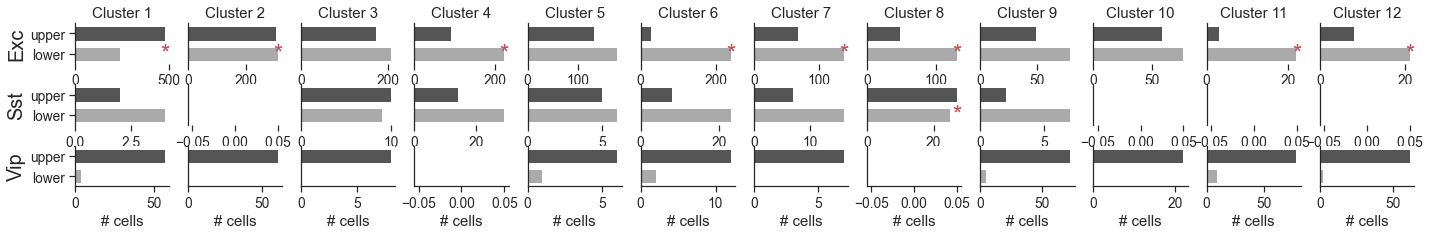

In [ ]:
location = 'layer'
order = ['upper', 'lower']
n_cells_table = processing.get_cluster_proportion_stats_for_locations(cluster_meta, location=location)

metric = 'n_cells_location'
xlabel = '# cells'
significance_col = 'bh_significant'

plotting.plot_location_distribution_across_clusters_for_cre_lines(n_cells_table, location=location, order=order,
                                                             metric=metric, xlabel=xlabel,
                                                             significance_col=significance_col, sharex=False,
                                                             ax=None, save_dir=save_dir, folder=folder);

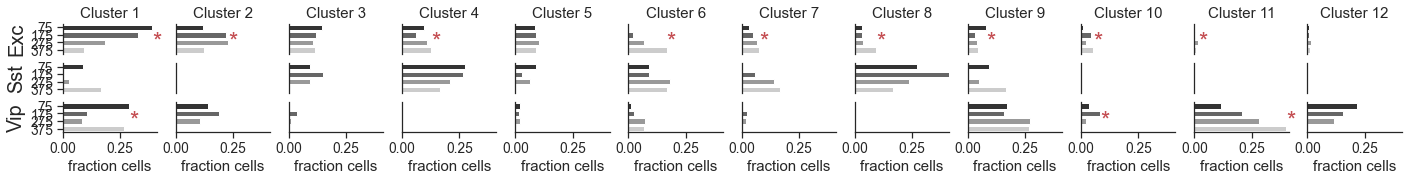

In [ ]:
location = 'binned_depth'
# order = ['upper', 'lower']
n_cells_table_depth = processing.get_cluster_proportion_stats_for_locations(cluster_meta, location=location)

metric = 'fraction_cells_location'
xlabel = 'fraction cells'
significance_col = 'bh_significant'

plotting.plot_location_distribution_across_clusters_for_cre_lines(n_cells_table_depth, location=location, order=None,
                                                             metric=metric, xlabel=xlabel,
                                                             significance_col=significance_col,
                                                             ax=None, save_dir=save_dir, folder=folder);

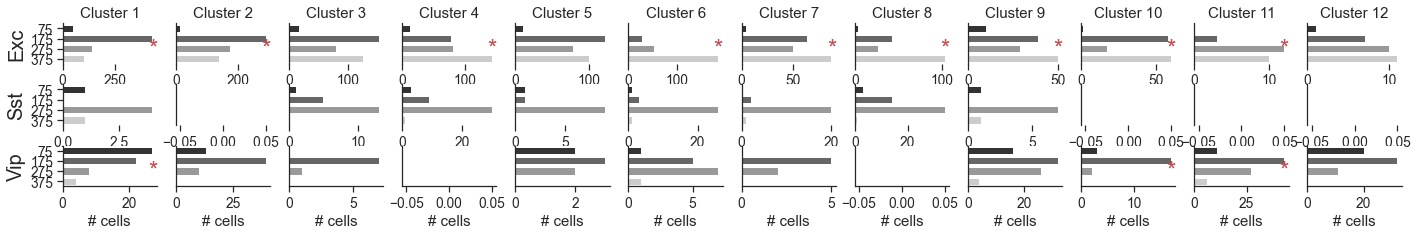

In [ ]:
location = 'binned_depth'
# order = ['upper', 'lower']
n_cells_table_depth = processing.get_cluster_proportion_stats_for_locations(cluster_meta, location=location)

metric = 'n_cells_location'
xlabel = '# cells'
significance_col = 'bh_significant'

plotting.plot_location_distribution_across_clusters_for_cre_lines(n_cells_table_depth, location=location, order=None,
                                                             metric=metric, xlabel=xlabel,
                                                             significance_col=significance_col,
                                                             sharex=False, 
                                                             ax=None, save_dir=save_dir, folder=folder);

#### by area

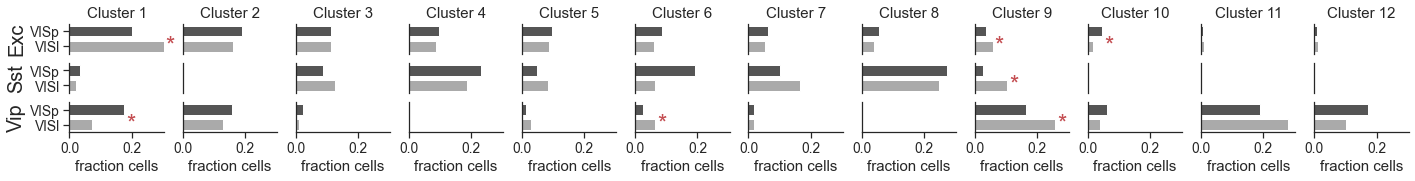

In [ ]:
location = 'targeted_structure'
order = ['VISp', 'VISl']
n_cells_table_depth = processing.get_cluster_proportion_stats_for_locations(cluster_meta, location=location)

metric = 'fraction_cells_location'
xlabel = 'fraction cells'
significance_col = 'bh_significant'

plotting.plot_location_distribution_across_clusters_for_cre_lines(n_cells_table_depth, location=location, order=order,
                                                             metric=metric, xlabel=xlabel,
                                                             significance_col=significance_col,
                                                             sharex=True, 
                                                             ax=None, save_dir=save_dir, folder=folder);

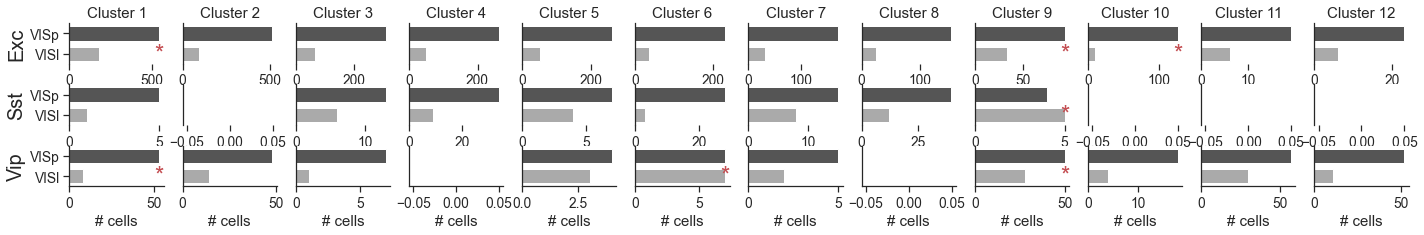

In [ ]:
location = 'targeted_structure'
order = ['VISp', 'VISl']
n_cells_table_depth = processing.get_cluster_proportion_stats_for_locations(cluster_meta, location=location)

metric = 'n_cells_location'
xlabel = '# cells'
significance_col = 'bh_significant'

plotting.plot_location_distribution_across_clusters_for_cre_lines(n_cells_table_depth, location=location, order=order,
                                                             metric=metric, xlabel=xlabel,
                                                             significance_col=significance_col,
                                                             sharex=False, 
                                                             ax=None, save_dir=save_dir, folder=folder);

In [ ]:
stats_table = glm_clust.stats(df, cre_lines[0], locations, test='chi_squared_')
stats_table.head()

location    lower  upper  lower_chance_count  upper_chance_count  \
cluster_id                                                         
0             NaN    NaN                 NaN                 NaN   
1           243.0  479.0          407.848999          314.151001   
2           309.0  302.0          345.146452          265.853548   
3           206.0  171.0          212.962705          164.037295   
4           223.0   90.0          176.809885          136.190115   

location    chi_squared_pvalue significant       imq bh_significant  
cluster_id                                                           
0                          NaN         NaN       NaN            NaN  
1                 3.580637e-35        True  0.004167           True  
2                 3.181840e-03        True  0.029167           True  
3                 4.694883e-01       False  0.041667          False  
4                 1.392968e-07        True  0.012500           True

In [ ]:
# cluster proportions for all cre lines
# this code uses glm_clust.final() to count how many cells per location per cluster per cre, 
# divide it by the total number of cells in each location in each cre
# then subtracts the average proportion across locations for each cluster
# does this make sense??
proportions, stats_final = processing.get_proportion_cells_rel_cluster_average(cluster_meta, cre_lines,
                                                                         columns_to_groupby=['layer'])
proportions.head()

location  cluster_id  proportion_cells           cre_line
0    lower           1         -0.101682  Slc17a7-IRES2-Cre
1    lower           2         -0.022296  Slc17a7-IRES2-Cre
2    lower           3         -0.004295  Slc17a7-IRES2-Cre
3    lower           4          0.028491  Slc17a7-IRES2-Cre
4    lower           5          0.001779  Slc17a7-IRES2-Cre

In [ ]:
stats = processing.compute_cluster_proportion_stats(cluster_meta.reset_index(), cre_lines[0], location='layer')
stats

layer       lower  upper  lower_chance_count  upper_chance_count  \
cluster_id                                                         
1             243    479          432.432753          333.086957   
2             309    302          350.536934          270.005636   
3             206    171          214.001045          164.837091   
4             223     90          169.921603          130.884326   
5             178    132          174.685017          134.553408   
6             238     28          137.175610          105.661299   
7             137     67          111.991638           86.263017   
8             130     47           95.509059           73.567096   
9              79     49           71.307317           54.925389   
10             77     59           76.798606           59.155126   
11             22      3           12.947387            9.972893   
12             21      8           15.693031           12.087762   

layer             pvalue significant       imq  bh_significant  
cluster_id                                                      
1           8.242002e-34        True  0.000000            True  
2           3.159309e-03        True  0.025000            True  
3           4.667918e-01       False  0.037500           False  
4           6.038135e-08        True  0.008333            True  
5           7.385966e-01       False  0.041667           False  
6           2.253013e-30        True  0.004167            True  
7           1.665367e-03        True  0.020833            True  
8           2.656768e-06        True  0.012500            True  
9           2.254835e-01       False  0.033333           False  
10          9.756073e-01       False  0.045833           False  
11          8.158659e-04        True  0.016667            True  
12          7.467946e-02       False  0.029167           False

In [ ]:
# # computing stats on proportions directly rather than counts - probably wrong

# from scipy.stats import chisquare

# location = 'layer'
# locations = np.sort(cluster_meta[location].unique())
# fraction_per_location_cols = []
# for loc in locations: 
#     fraction_per_location_cols.append('fraction_cells_'+loc)

# # # compute estimated frequency of cells based on average fraction for each cluster
# # for loc in locations:
# #     fraction_cells[loc + '_chance_count'] = fraction_cells['fraction_cells_'+loc].sum() * fraction_cells['mean']
    
# # perform chi-squared test
# for index in fraction_cells.index.values:
#     f = fraction_cells.loc[index][fraction_per_location_cols].values
#     # chance is just the overall size of the cluster
#     f_expected = np.repeat(fraction_cells.loc[index]['fraction_cells_per_cluster'], len(locations))
#     out = chisquare(f, f_expected)
#     fraction_cells.at[index, 'pvalue'] = out.pvalue
#     fraction_cells.at[index, 'significant'] = out.pvalue < 0.05

# # Use Benjamini Hochberg Correction for multiple comparisons
# fraction_cells = processing.add_hochberg_correction(fraction_cells)

# fraction_cells.head()

In [ ]:
# cluster proportions for all cre lines
proportions, stats = processing.get_proportion_cells_rel_cluster_average(cluster_meta, cre_lines,
                                                                         columns_to_groupby=['layer'])

In [ ]:
proportions.head()

location  cluster_id  proportion_cells           cre_line
0    lower           1         -0.101682  Slc17a7-IRES2-Cre
1    lower           2         -0.022296  Slc17a7-IRES2-Cre
2    lower           3         -0.004295  Slc17a7-IRES2-Cre
3    lower           4          0.028491  Slc17a7-IRES2-Cre
4    lower           5          0.001779  Slc17a7-IRES2-Cre

### cluster metrics vs. area depth proportion

#### get metrics

In [ ]:
# cluster_metrics_all_cre = processing.get_cluster_metrics_all_cre(cluster_meta, feature_matrix, results_pivoted)
# cluster_metrics_all_cre.head()

#### link cluster metrics to area depth

In [ ]:
# # cell metrics
# coding_score_metrics = processing.get_cell_metrics(cluster_meta, results_pivoted)
# # for each cre
# cluster_metrics = processing.get_cluster_metrics(cluster_meta, feature_matrix, results_pivoted)

# location = 'layer'
# order = ['upper', 'lower']
# n_cells_table = processing.get_cluster_proportion_stats_for_locations(cluster_meta, location=location)

# cluster_metrics = processing.add_layer_index_to_cluster_metrics(cluster_metrics, n_cells_table)

# # make the plot 

# x = 'exp_mod_direction' # novel-familiar / sum
# y = 'layer_index' # upper-lower / sum
# hue = 'cell_type'

# if 'cell_type' not in cluster_metrics.columns:
#     # cluster_metrics['cre_line'] = cluster_metrics.index.get_level_values(0)
#     cluster_metrics['cell_type'] = [utils.convert_cre_line_to_cell_type(cre_line) for cre_line in cluster_metrics.index.get_level_values(0)]

# plotting.plot_cluster_metric_comparison_scatterplot(cluster_metrics, cluster_meta, x=x, y=y, hue=hue, save_dir=save_dir, folder=folder)


In [ ]:
# x = 'exp_mod_direction' # novel-familiar / sum
# y = 'layer_index' # upper-lower / sum
# hue = 'cell_type'

# if 'cell_type' not in cluster_metrics.columns:
#     # cluster_metrics['cre_line'] = cluster_metrics.index.get_level_values(0)
#     cluster_metrics['cell_type'] = [utils.convert_cre_line_to_cell_type(cre_line) for cre_line in cluster_metrics.index.get_level_values(0)]

# plotting.plot_cluster_metric_comparison_scatterplot(cluster_metrics, cluster_meta, x=x, y=y, hue=hue, save_dir=save_dir, folder=folder)


### split by cre line and plot heatmaps

C:\Users\marinag\Documents\Code\visual_behavior_analysis\visual_behavior\dimensionality_reduction\clustering\plotting.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_meta_cre['size_sort_cluster_id'] = [np.where(cluster_size_order == label)[0][0] for label in
C:\Users\marinag\Documents\Code\visual_behavior_analysis\visual_behavior\dimensionality_reduction\clustering\plotting.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_meta_cre['size_sort_cluster_id'] = [np.where(cluster_size_o

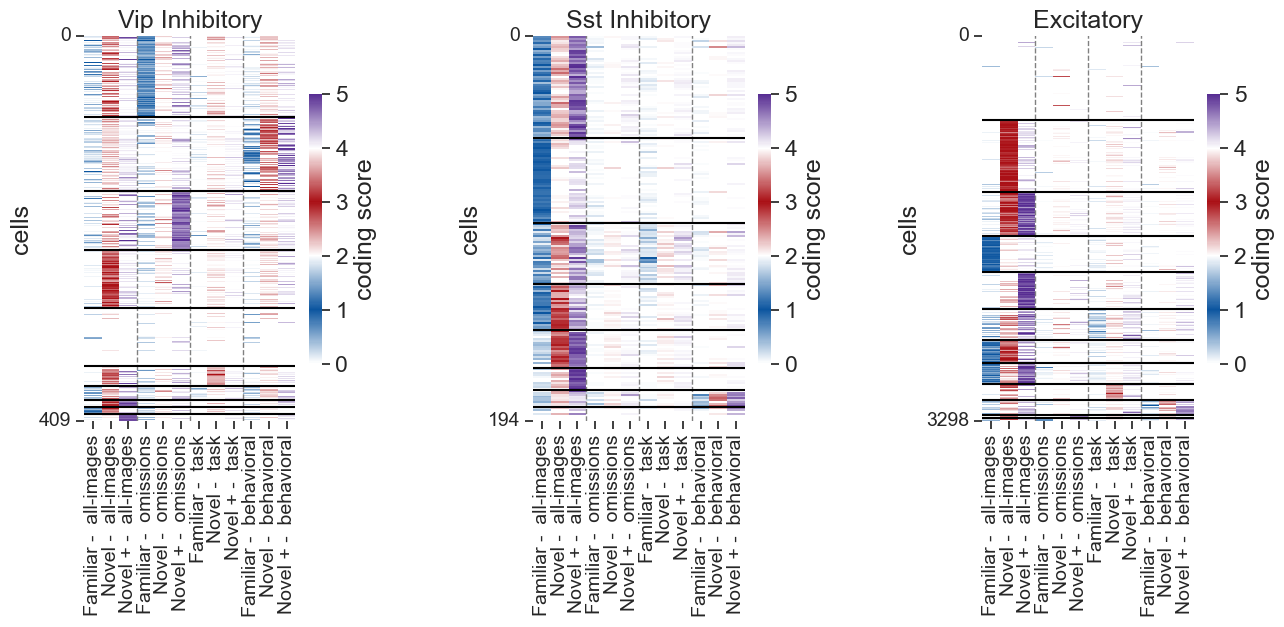

In [105]:
# plot feature matrix sorted by cluster ID
feature_matrix_remapped, remapped_cmap, vmax = plotting.remap_coding_scores_to_session_colors(feature_matrix)

plotting.plot_feature_matrix_sorted(feature_matrix_remapped, cluster_meta, sort_col='cluster_id', resort_by_size=True,
                                    cmap=remapped_cmap, vmax=vmax, save_dir=None, folder=folder)

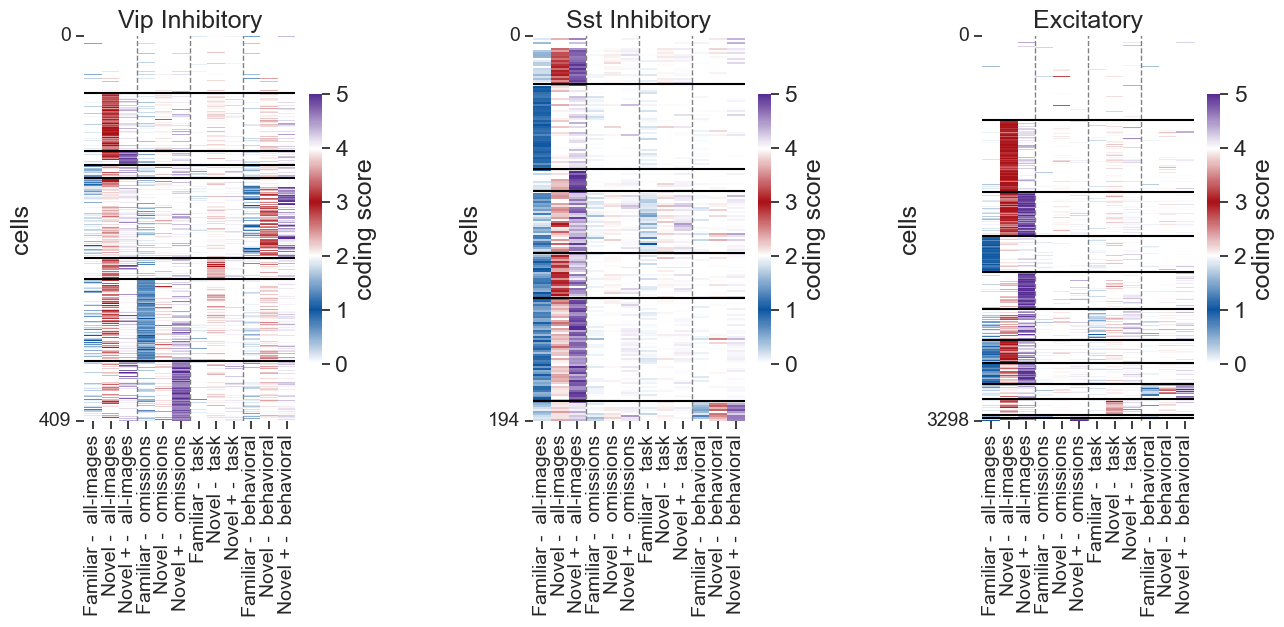

In [106]:
# plot feature matrix sorted by cluster ID
# plot feature matrix sorted by cluster ID
feature_matrix_remapped, remapped_cmap, vmax = plotting.remap_coding_scores_to_session_colors(feature_matrix)

plotting.plot_feature_matrix_sorted(feature_matrix_remapped, cluster_meta, sort_col='cluster_id', resort_by_size=False,
                                    cmap=remapped_cmap, vmax=vmax, save_dir=None, folder=folder)

### average dropouts per cluster - updated colors

In [ ]:
n_clusters

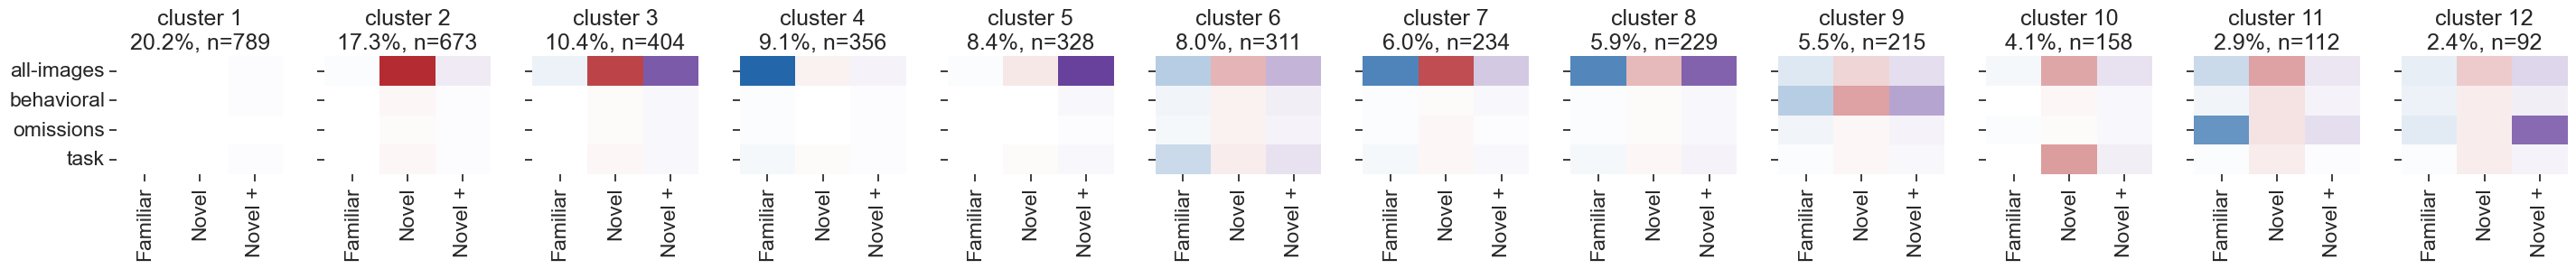

In [108]:
# plot clusters in order of sort_col
clusters = np.sort(cluster_meta['cluster_id'].unique())
n_clusters = len(clusters)

feature_matrix_remapped, remapped_cmap, vmax = plotting.remap_coding_scores_to_session_colors(feature_matrix)


figsize = (35, 1.7)
fig, ax = plt.subplots(1, n_clusters_to_plot, figsize=figsize, sharex=True, sharey=True)
ax = ax.ravel()

  
# loop through clusters in sorted order
for i, cluster_id in enumerate(clusters):
    this_cluster_csids = cluster_meta[cluster_meta.cluster_id==cluster_id].index.values
    mean_dropout_df = feature_matrix_remapped.loc[this_cluster_csids].mean().unstack()
    ax[i] = sns.heatmap(mean_dropout_df, cmap=remapped_cmap, vmin=0, vmax=vmax, ax=ax[i], cbar=False, cbar_kws={'label': 'coding score'})
    # fraction is number of cells in this cluster vs all cells in this cre line
    fraction_cluster = len(this_cluster_csids) / float(len(cluster_meta))
    fraction = np.round(fraction_cluster * 100, 1)
    # set title and labels
    ax[i].set_title('cluster ' + str(cluster_id) + '\n' + str(fraction) + '%, n=' + str(len(this_cluster_csids)))
    ax[i].set_xlabel('')
    
plt.subplots_adjust(hspace=0.6, wspace=0.25)
if save_dir:
    utils.save_figure(fig, figsize, save_dir, folder,
                      'mean_cluster_heatmaps_remapped_'+str(n_clusters))

#### averages per cre line 

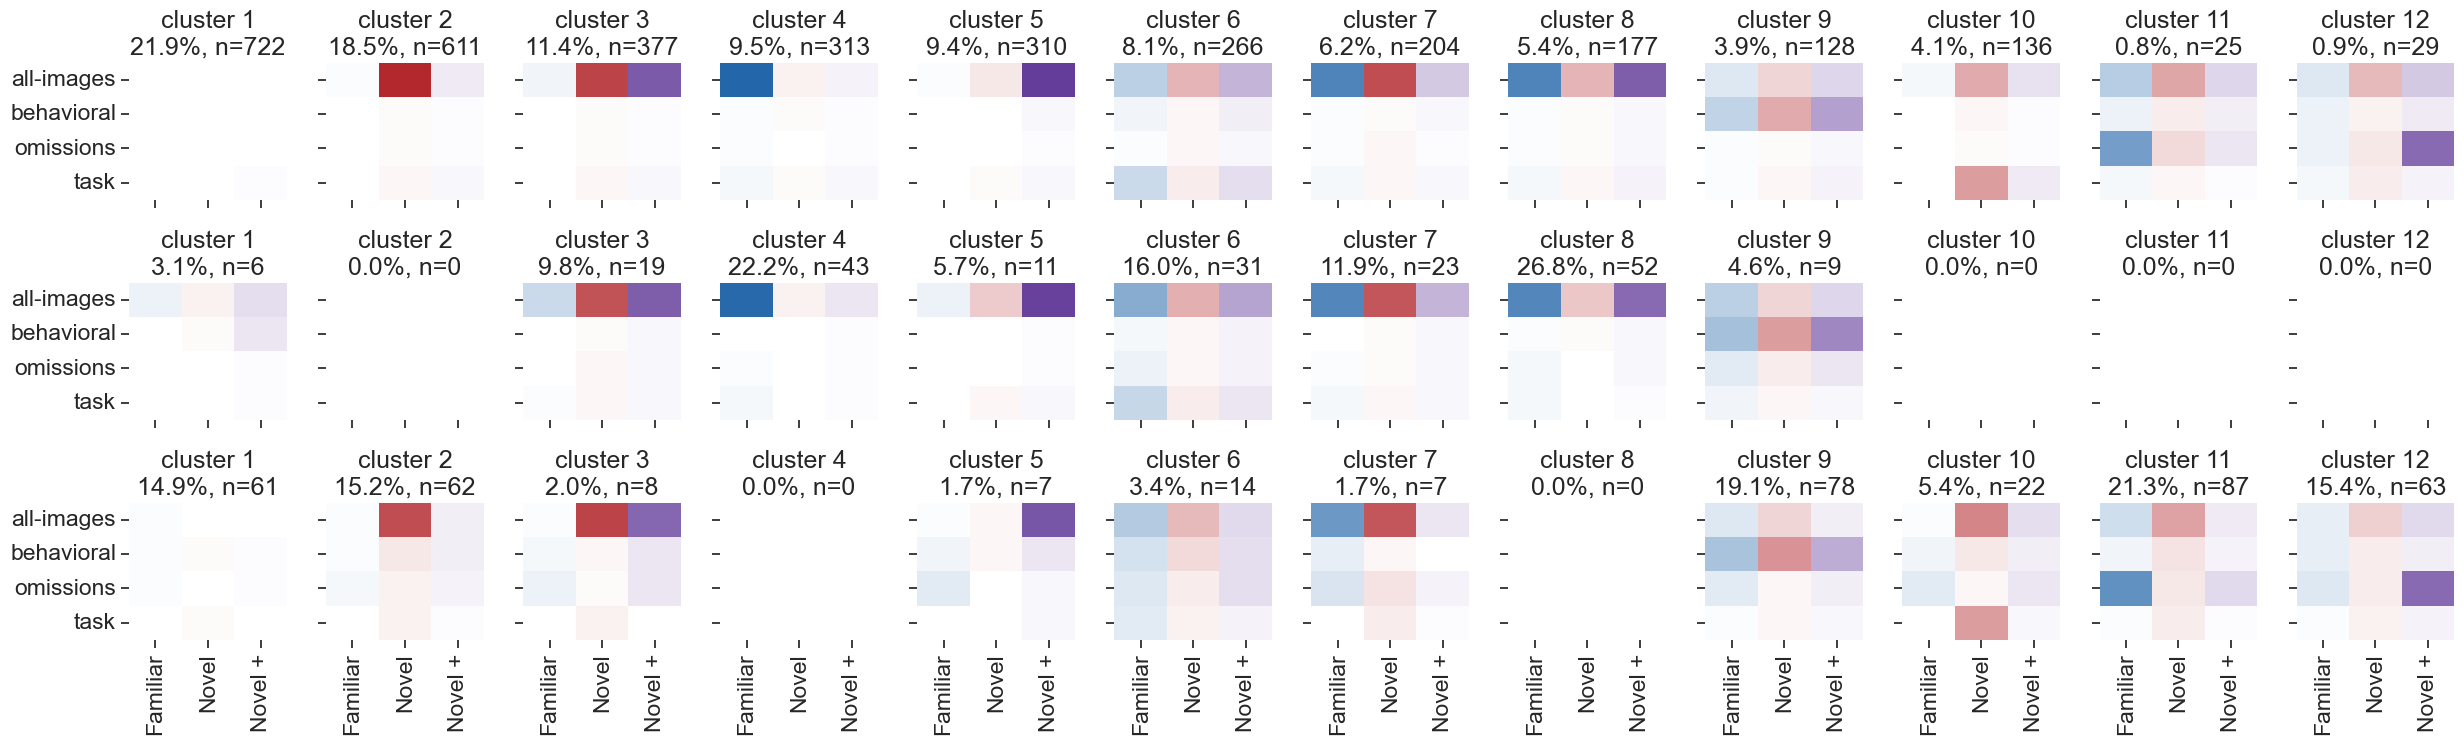

In [109]:
# all cre lines on one plot

feature_matrix_remapped, remapped_cmap, vmax = plotting.remap_coding_scores_to_session_colors(feature_matrix)

clusters = np.sort(cluster_meta['cluster_id'].unique())
n_clusters = len(clusters)

figsize = (2.5*n_clusters, 2.5*3)
fig, ax = plt.subplots(3, n_clusters, figsize=figsize, sharex=True, sharey=True)
ax = ax.ravel()

i=0
for c, cre_line in enumerate(np.sort(cluster_meta.cre_line.unique())):
    cre_cluster_meta = cluster_meta[cluster_meta.cre_line==cre_line].copy()

    # loop through clusters in sorted order
    for x, cluster_id in enumerate(clusters):
        try:
            this_cluster_csids = cre_cluster_meta[cre_cluster_meta.cluster_id==cluster_id].index.values
            mean_dropout_df = feature_matrix_remapped.loc[this_cluster_csids].mean().unstack()
            ax[i] = sns.heatmap(mean_dropout_df, cmap=remapped_cmap, vmin=0, vmax=vmax, ax=ax[i], cbar=False, cbar_kws={'label': 'coding score'})
            # fraction is number of cells in this cluster vs all cells in this cre line
            fraction_cluster = len(this_cluster_csids) / float(len(cre_cluster_meta))
            fraction = np.round(fraction_cluster * 100, 1)
            # set title and labels
            ax[i].set_title('cluster ' + str(cluster_id) + '\n' + str(fraction) + '%, n=' + str(len(this_cluster_csids)))
            ax[i].set_xlabel('')
        except:
            pass
        i+=1
        
    plt.subplots_adjust(hspace=0.6, wspace=0.25)
    # plt.suptitle(cre_line, x=0.46, y=1.)
    if save_dir:
        utils.save_figure(fig, figsize, save_dir, folder,
                      'mean_cluster_heatmaps_remapped')

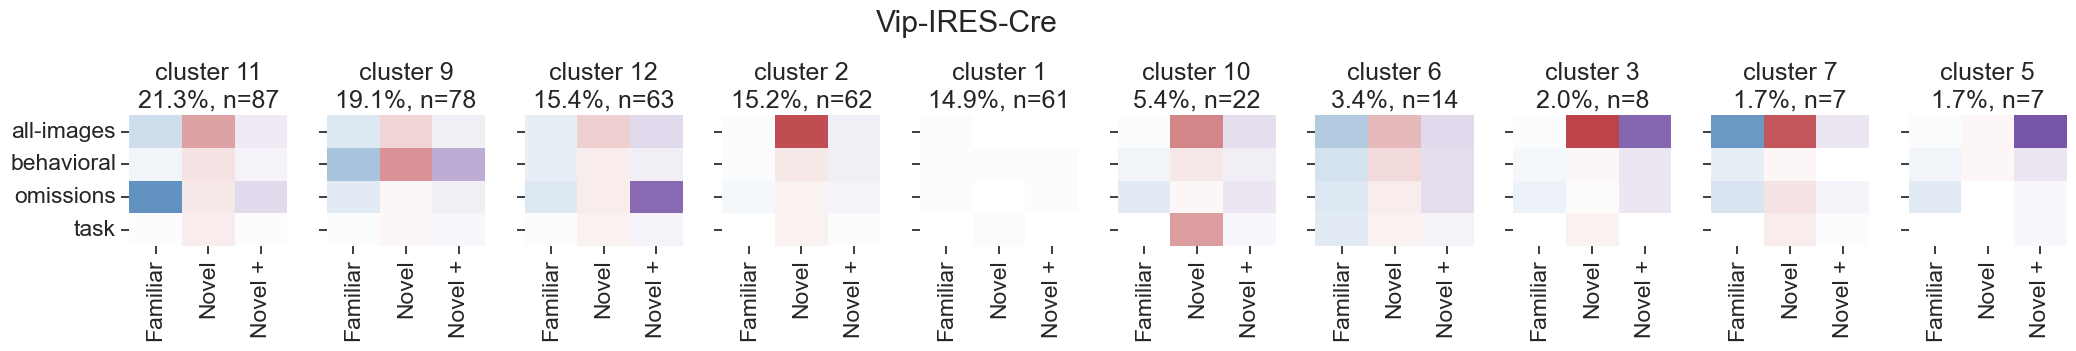

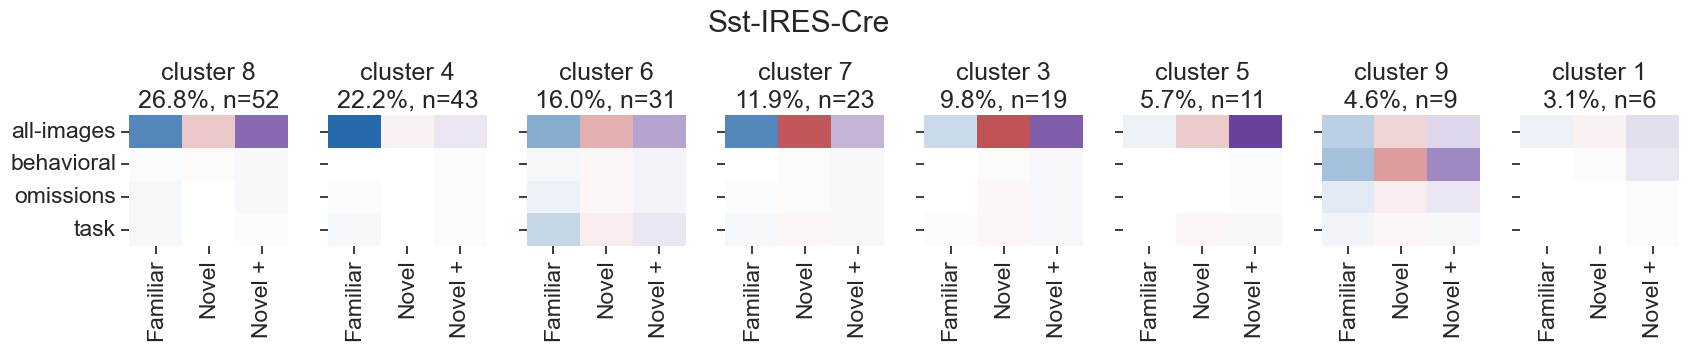

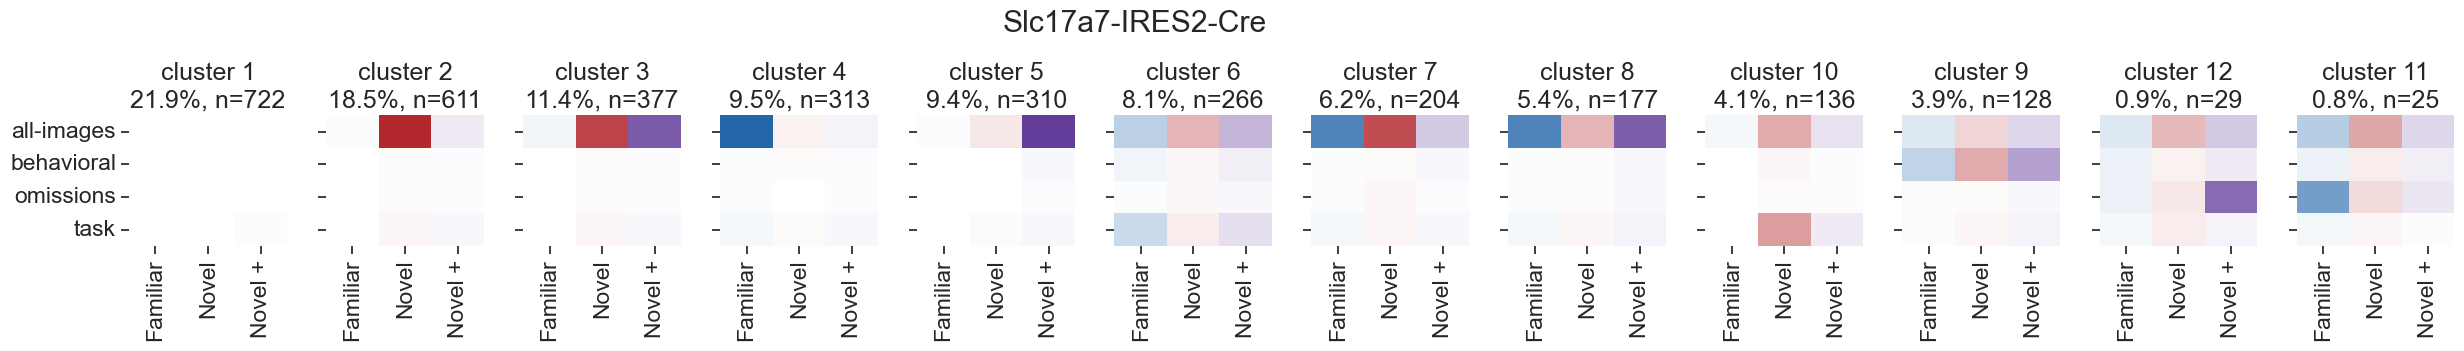

In [110]:
# plot and sort each cre line separately

feature_matrix_remapped, remapped_cmap, vmax = plotting.remap_coding_scores_to_session_colors(feature_matrix)


for cre_line in cluster_meta.cre_line.unique():
    cre_cluster_meta = cluster_meta[cluster_meta.cre_line==cre_line].copy()
    # clusters = np.sort(cre_cluster_meta['cluster_id'].unique())
    # sort by cluster size
    clusters = cre_cluster_meta['cluster_id'].value_counts().index.values
    n_clusters_to_plot = len(clusters)

    figsize = (2.5*n_clusters_to_plot, 1.7)
    fig, ax = plt.subplots(1, n_clusters_to_plot, figsize=figsize, sharex=True, sharey=True)
    ax = ax.ravel()

    
    # loop through clusters in sorted order
    for i, cluster_id in enumerate(clusters):
        this_cluster_csids = cre_cluster_meta[cre_cluster_meta.cluster_id==cluster_id].index.values
        mean_dropout_df = feature_matrix_remapped.loc[this_cluster_csids].mean().unstack()
        ax[i] = sns.heatmap(mean_dropout_df, cmap=remapped_cmap, vmin=0, vmax=vmax, ax=ax[i], cbar=False, cbar_kws={'label': 'coding score'})
        # fraction is number of cells in this cluster vs all cells in this cre line
        fraction_cluster = len(this_cluster_csids) / float(len(cre_cluster_meta))
        fraction = np.round(fraction_cluster * 100, 1)
        # set title and labels
        ax[i].set_title('cluster ' + str(cluster_id) + '\n' + str(fraction) + '%, n=' + str(len(this_cluster_csids)))
        ax[i].set_xlabel('')
        
    plt.subplots_adjust(hspace=0.6, wspace=0.25)
    plt.suptitle(cre_line, x=0.46, y=1.5)
    if save_dir:
        utils.save_figure(fig, figsize, save_dir, folder,
                      'mean_cluster_heatmaps_remapped_'+cre_line.split('-')[0])

#### sort by cluster size within cre, exclude clusters with <10% cells

In [111]:
cluster_metrics_per_cre = processing.get_cluster_metrics(cluster_meta, feature_matrix, results_pivoted)
cluster_metrics_per_cre = cluster_metrics_per_cre.reset_index()
# cluster_metrics_per_cre = cluster_metrics_per_cre[(cluster_metrics_per_cre.cre_line==cre_line)&(cluster_metrics_per_cre.n_cells_cluster>10)]
cluster_metrics_per_cre.head()

cre_line  cluster_id dominant_feature dominant_experience_level  \
0  Slc17a7-IRES2-Cre           1             task                   Novel +   
1  Slc17a7-IRES2-Cre           2       all-images                     Novel   
2  Slc17a7-IRES2-Cre           3       all-images                     Novel   
3  Slc17a7-IRES2-Cre           4       all-images                  Familiar   
4  Slc17a7-IRES2-Cre           5       all-images                   Novel +   

  next_highest_conditions  max_coding_score  max_image_coding_score  \
0      (Novel, omissions)          0.007872                0.003056   
1         (Novel +, task)          0.899068                0.899068   
2         (Novel +, task)          0.790757                0.790757   
3         (Novel +, task)          0.916090                0.916090   
4           (Novel, task)          0.902526                0.902526   

   image_coding_Familiar  image_coding_Novel  image_coding_Novel +  ...  \
0               0.006467            0.002046              0.003056  ...   
1               0.026190            0.899068              0.092013  ...   
2               0.074130            0.790757              0.773776  ...   
3               0.916090            0.065449              0.055535  ...   
4               0.024844            0.095617              0.902526  ...   

   exp_mod_direction  exp_mod_persistence  feature_sel_within_session  \
0           0.526326             1.295495                    0.413906   
1           0.943390             0.102343                    0.908952   
2           0.828579             0.978525                    0.895087   
3          -0.866640             0.848519                    0.917703   
4           0.587523             9.438923                    0.919207   

   feature_sel_across_sessions  fraction_cre     F_max    N1_max    N2_max  \
0                     0.081820      0.218921  0.006467  0.006681  0.007872   
1                     0.948108      0.185264  0.026190  0.899068  0.092013   
2                     0.911192      0.114312  0.074130  0.790757  0.773776   
3                     0.947425      0.094906  0.916090  0.065449  0.055535   
4                     0.953446      0.093996  0.024844  0.095617  0.902526   

    abs_max  n_cells_cluster  
0  0.007872              722  
1  0.899068              611  
2  0.790757              377  
3  0.916090              313  
4  0.902526              310  

[5 rows x 23 columns]

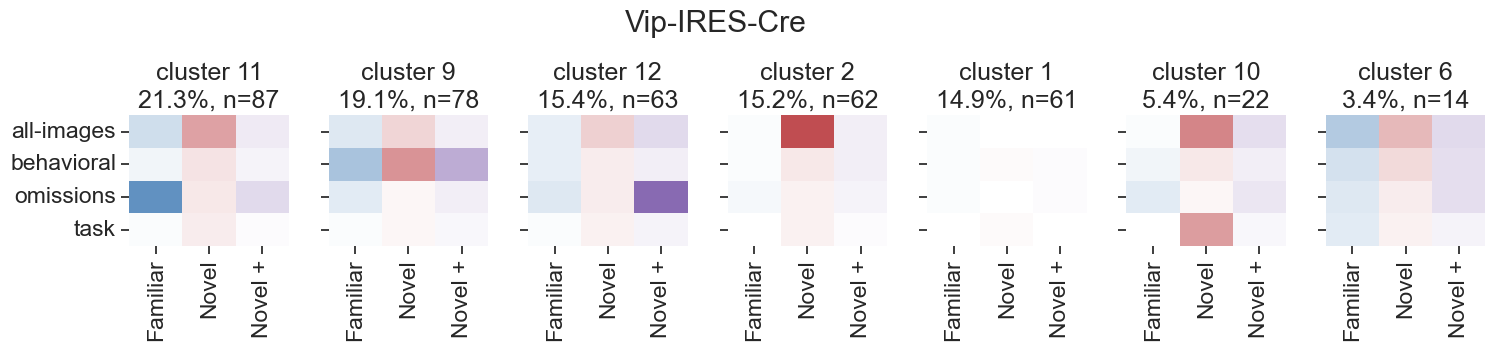

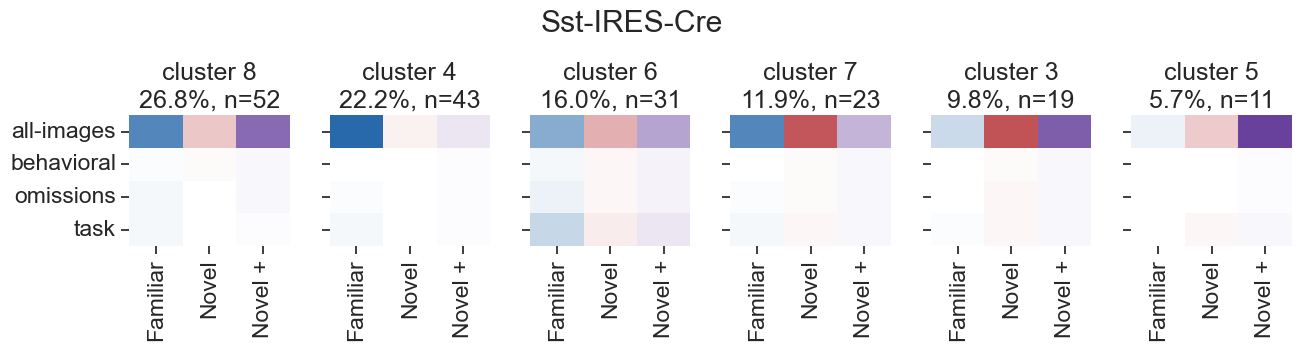

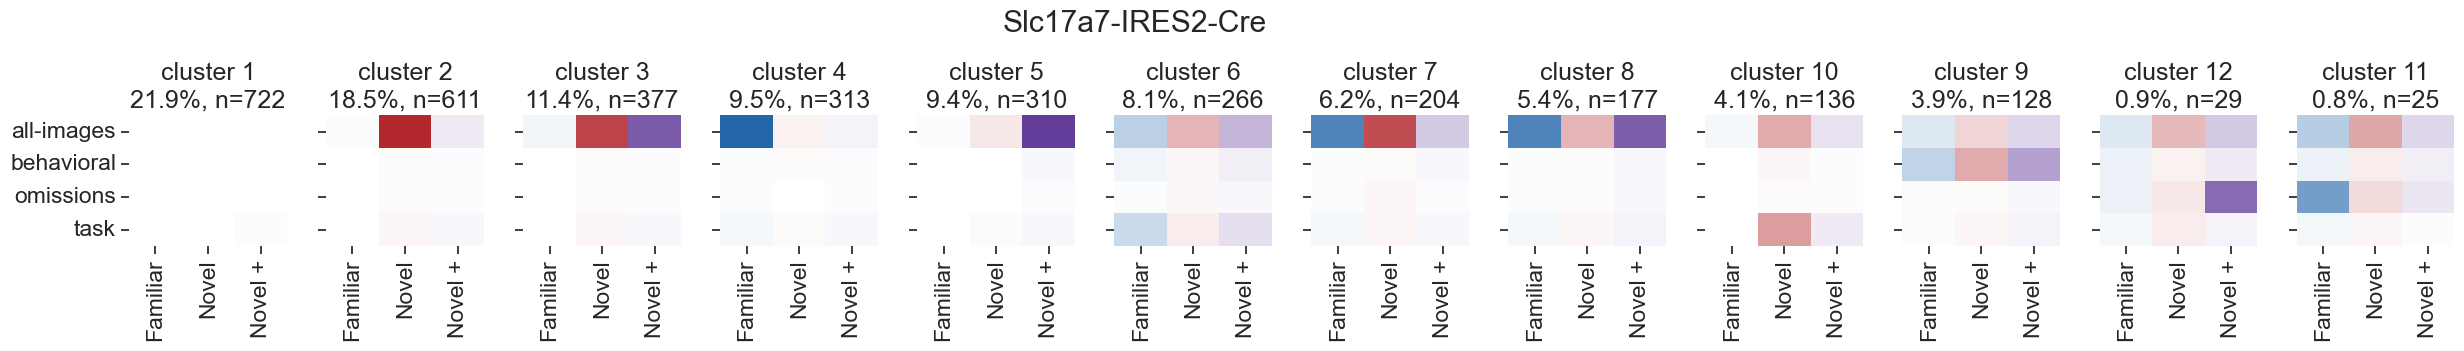

In [112]:
# plot clusters in order of sort_col

feature_matrix_remapped, remapped_cmap, vmax = plotting.remap_coding_scores_to_session_colors(feature_matrix)


for cre_line in cluster_meta.cre_line.unique():
    cre_cluster_meta = cluster_meta[cluster_meta.cre_line==cre_line].copy()

    clusters_to_include = cluster_metrics_per_cre[(cluster_metrics_per_cre.cre_line==cre_line)&(cluster_metrics_per_cre.n_cells_cluster>10)].cluster_id.unique()
    clusters = cre_cluster_meta[cre_cluster_meta.cluster_id.isin(clusters_to_include)]['cluster_id'].value_counts().index.values    
    n_clusters_to_plot = len(clusters)

    figsize = (2.5*n_clusters_to_plot, 1.7)
    fig, ax = plt.subplots(1, n_clusters_to_plot, figsize=figsize, sharex=True, sharey=True)
    ax = ax.ravel()

    
    # loop through clusters in sorted order
    for i, cluster_id in enumerate(clusters):
        this_cluster_csids = cre_cluster_meta[cre_cluster_meta.cluster_id==cluster_id].index.values
        mean_dropout_df = feature_matrix_remapped.loc[this_cluster_csids].mean().unstack()
        ax[i] = sns.heatmap(mean_dropout_df, cmap=remapped_cmap, vmin=0, vmax=vmax, ax=ax[i], cbar=False, cbar_kws={'label': 'coding score'})
        # fraction is number of cells in this cluster vs all cells in this cre line
        fraction_cluster = len(this_cluster_csids) / float(len(cre_cluster_meta))
        fraction = np.round(fraction_cluster * 100, 1)
        # set title and labels
        ax[i].set_title('cluster ' + str(cluster_id) + '\n' + str(fraction) + '%, n=' + str(len(this_cluster_csids)))
        ax[i].set_xlabel('')
        
    plt.subplots_adjust(hspace=0.6, wspace=0.25)
    plt.suptitle(cre_line, x=0.46, y=1.5)
    if save_dir:
        utils.save_figure(fig, figsize, save_dir, folder,
                      'mean_cluster_heatmaps_remapped_sorted_'+cre_line.split('-')[0])

## graphical abstract figure 

Goal: make figure representing the major clusters for each cre line, with each cluster represented as one point (cell) using the color for experience modulation, shape for cre line, y position for type and strength of coding, x position for area-depth bias

* Use pref exp level (or index) for color of fill
* Pref feature for x position (strength of coding for each as order)
* Get upper v. lower for significant diffs, set as y position; nonsig in middle
* Cre lines as shapes
* Only include clusters with >5% cells

#### get data

In [113]:
# for each cre
cluster_metrics = processing.get_cluster_metrics(cluster_meta, feature_matrix, results_pivoted)
cluster_metrics.head()

dominant_feature dominant_experience_level  \
cre_line          cluster_id                                              
Slc17a7-IRES2-Cre 1                      task                   Novel +   
                  2                all-images                     Novel   
                  3                all-images                     Novel   
                  4                all-images                  Familiar   
                  5                all-images                   Novel +   

                             next_highest_conditions  max_coding_score  \
cre_line          cluster_id                                             
Slc17a7-IRES2-Cre 1               (Novel, omissions)          0.007872   
                  2                  (Novel +, task)          0.899068   
                  3                  (Novel +, task)          0.790757   
                  4                  (Novel +, task)          0.916090   
                  5                    (Novel, task)          0.902526   

                              max_image_coding_score  image_coding_Familiar  \
cre_line          cluster_id                                                  
Slc17a7-IRES2-Cre 1                         0.003056               0.006467   
                  2                         0.899068               0.026190   
                  3                         0.790757               0.074130   
                  4                         0.916090               0.916090   
                  5                         0.902526               0.024844   

                              image_coding_Novel  image_coding_Novel +  \
cre_line          cluster_id                                             
Slc17a7-IRES2-Cre 1                     0.002046              0.003056   
                  2                     0.899068              0.092013   
                  3                     0.790757              0.773776   
                  4                     0.065449              0.055535   
                  5                     0.095617              0.902526   

                              feature_selectivity  experience_selectivity  \
cre_line          cluster_id                                                
Slc17a7-IRES2-Cre 1                      0.453154                0.328261   
                  2                      0.932713                0.876637   
                  3                      0.923915                0.301968   
                  4                      0.936667                0.876115   
                  5                      0.939104                0.874879   

                              ...  exp_mod_direction  exp_mod_persistence  \
cre_line          cluster_id  ...                                           
Slc17a7-IRES2-Cre 1           ...           0.526326             1.295495   
                  2           ...           0.943390             0.102343   
                  3           ...           0.828579             0.978525   
                  4           ...          -0.866640             0.848519   
                  5           ...           0.587523             9.438923   

                              feature_sel_within_session  \
cre_line          cluster_id                               
Slc17a7-IRES2-Cre 1                             0.413906   
                  2                             0.908952   
                  3                             0.895087   
                  4                             0.917703   
                  5                             0.919207   

                              feature_sel_across_sessions  fraction_cre  \
cre_line          cluster_id                                              
Slc17a7-IRES2-Cre 1                              0.081820      0.218921   
                  2                              0.948108      0.185264   
                  3                              0.911192      0.114312   
                  4                

In [114]:
location = 'layer'
n_cells_table = processing.get_cluster_proportion_stats_for_locations(cluster_meta, location=location)
n_cells_table.head()

InvalidIndexError: You can only assign a scalar value not a <class 'bool'>

In [ ]:
layer_index = n_cells_table[['fraction_cells_location']].unstack()
layer_index.columns = layer_index.columns.droplevel(0)
layer_index['layer_index'] = (layer_index.upper-layer_index.lower)/(layer_index.upper+layer_index.lower)
layer_index = layer_index.merge(n_cells_table[['bh_significant', 'significant']], on=['cre_line', 'cluster_id'])
layer_index = layer_index.reset_index().drop_duplicates(subset=['cre_line', 'cluster_id']).set_index(['cre_line', 'cluster_id'])
layer_index.head()

lower     upper  layer_index bh_significant  \
cre_line          cluster_id                                                   
Slc17a7-IRES2-Cre 1           0.130435  0.333798     0.438063           True   
                  2           0.165862  0.210453     0.118495           True   
                  3           0.110574  0.119164     0.037388          False   
                  4           0.119699  0.062718    -0.312370           True   
                  5           0.095545  0.091986    -0.018977          False   

                             significant  
cre_line          cluster_id              
Slc17a7-IRES2-Cre 1                 True  
                  2                 True  
                  3                False  
                  4                 True  
                  5                False

#### seaborn plot

In [115]:
# get data to plot
df = cluster_metrics.merge(layer_index, on=['cre_line', 'cluster_id']).sort_values(by='max_coding_score')
df = df[df.fraction_cre>0.07]

# color by experience mod index, which ranges from -1, 1 
# can round values to 0.1 to index into cmap binned into 20 colors
colors = sns.color_palette('RdBu', 20)
value_order = np.arange(-1, 1, 0.1)
value_order = [np.round(value, 1) for value in value_order]
# markers for cre lines 
marker_dict = {'Slc17a7-IRES2-Cre': '^', 
                'Sst-IRES-Cre': 'o', 
                'Vip-IRES-Cre': 'd'}

# make plot
figsize = (6,4)
fig, ax = plt.subplots(figsize=figsize)
ax = sns.scatterplot(data=df.reset_index(), x='max_image_coding_score', y='layer_index', 
                hue='exp_mod_direction', palette='RdBu', size='fraction_cre', sizes=(1,500),
                markers=marker_dict, style='cre_line', edgecolor='gray', ax=ax)
ax.legend(bbox_to_anchor=(1,1), fontsize='x-small', title_fontsize='x-small')
# ax.hlines(y=0, xmin=0, xmax=1, linestyle='--', color='gray', linewidth=1)
ax.set_title('Size, location, coding strength,\n and experience dependence for major clusters')
ax.set_ylabel('layer bias\n<- lower --- upper ->')
ax.set_xlabel('image coding strength ->')
ax.set_ylim(-0.8, 0.8)
sns.despine(left=True, bottom=True)
for index in df.index.values:  
    cluster_id = index[1]
    x_pos = df.loc[index, 'max_image_coding_score']
    y_pos = df.loc[index, 'layer_index']
    size = df.loc[index, 'fraction_cre']
    ax.text(x=x_pos+size*0.1, y=y_pos+size*0.1, s=str(cluster_id), fontsize=12, color='k', ha='left', va='bottom')

NameError: name 'layer_index' is not defined

posx and posy should be finite values
posx and posy should be finite values


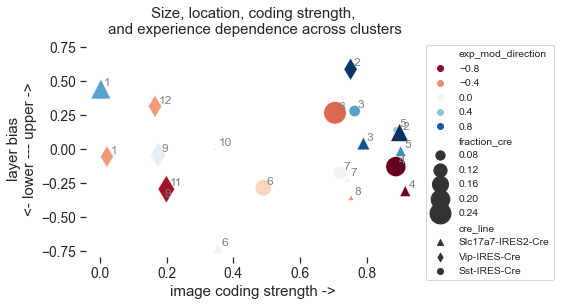

In [ ]:
# get data to plot
df = cluster_metrics.merge(layer_index, on=['cre_line', 'cluster_id']).sort_values(by='max_coding_score')
df = df[df.fraction_cre>0.04]

# color by experience mod index, which ranges from -1, 1 
# can round values to 0.1 to index into cmap binned into 20 colors
colors = sns.color_palette('RdBu', 20)
value_order = np.arange(-1, 1, 0.1)
value_order = [np.round(value, 1) for value in value_order]
# markers for cre lines 
marker_dict = {'Slc17a7-IRES2-Cre': '^', 
                'Sst-IRES-Cre': 'o', 
                'Vip-IRES-Cre': 'd'}

# make plot
figsize = (6,4)
fig, ax = plt.subplots(figsize=figsize)
ax = sns.scatterplot(data=df.reset_index(), x='max_image_coding_score', y='layer_index', 
                hue='exp_mod_direction', palette='RdBu', size='fraction_cre', sizes=(1,500),
                markers=marker_dict, style='cre_line', ax=ax)
ax.legend(bbox_to_anchor=(1,1), fontsize='x-small', title_fontsize='x-small')
# ax.hlines(y=0, xmin=0, xmax=1, linestyle='--', color='gray', linewidth=1)
ax.set_title('Size, location, coding strength,\n and experience dependence across clusters')
ax.set_ylabel('layer bias\n<- lower --- upper ->')
ax.set_xlabel('image coding strength ->')
ax.set_ylim(-0.8, 0.8)
sns.despine(left=True, bottom=True)
for index in df.index.values:  
    cluster_id = index[1]
    x_pos = df.loc[index, 'max_image_coding_score']
    y_pos = df.loc[index, 'layer_index']
    ax.text(x=x_pos+0.01, y=y_pos+0.01, s=str(cluster_id), fontsize=12, color='gray', ha='left', va='bottom')

#### matplotlib version

NameError: name 'df' is not defined

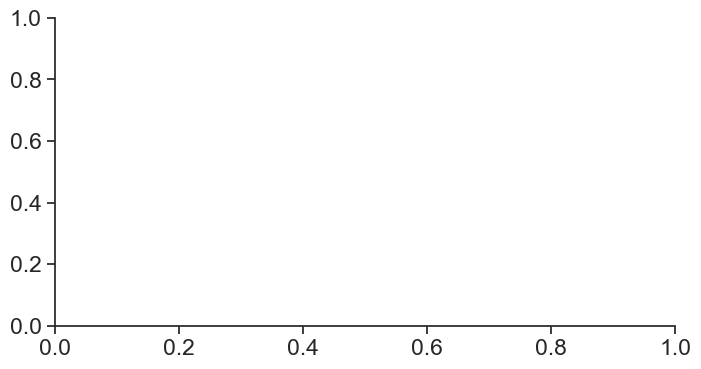

In [116]:
features = ['all-images', 'omissions', 'task', 'behavioral',]

marker_dict = {'Slc17a7-IRES2-Cre': '^', 
                'Sst-IRES-Cre': 'o', 
                'Vip-IRES-Cre': 'd'}

# color by experience mod index, which ranges from -1, 1 
# can round values to 0.1 to index into cmap binned into 20 colors
colors = sns.color_palette('RdBu', 20)
value_order = np.arange(-1, 1, 0.1)
value_order = [np.round(value, 1) for value in value_order]

figsize = (8,4)
fig, ax = plt.subplots(figsize=figsize)

# plot in order of features
for f, feature in enumerate(features): 
    # get clusters with specific preferred feature
    feature_data = df[(df.dominant_feature==feature) & (df.fraction_cre>0.04)] # only consider clusters with >4% cells
    # sort clusters by max coding score for pref feature
    feature_data = feature_data.sort_values(by='max_coding_score')
    # loop through clusters
    for index in feature_data.index.values: 
        cluster_data = feature_data.loc[index]
        # x position determined by strength of max coding score (which corresponds to the pref feature)
        x_pos = cluster_data.max_coding_score
        # y position is the upper v lower index value (i.e. layer bias of cluster)
        y_pos = cluster_data.layer_index
        # get color for exp mod index by rounding and indexing into discritized color map
        exp_mod_value = np.round(cluster_data.exp_mod_direction, 1)
        color_index = np.where(value_order==exp_mod_value)[0][0]
        color = colors[color_index]
        # get marker for cre line
        cre_line = index[0] # zero index is cre line, get maker for cre line
        marker = marker_dict[cre_line] 
        cluster_id = index[1] # get cluster Id for label
        ax.plot(x_pos, y_pos, marker=marker, ms=20, label=utils.get_abbreviated_cell_type(cre_line)+'-'+str(cluster_id),
                markerfacecolor=color, markeredgecolor='black')

ax.set_ylim(-1, 1)
ax.legend(bbox_to_anchor=(1,1))

#### which clusters form the top 3 in each cre line?

In [ ]:
cluster_metrics.reset_index().sort_values(by=['cre_line', 'fraction_cre'], ascending=False)[['cre_line', 'cluster_id', 'fraction_cre']]

cre_line  cluster_id  fraction_cre
28       Vip-IRES-Cre          11      0.212714
26       Vip-IRES-Cre           9      0.190709
29       Vip-IRES-Cre          12      0.154034
21       Vip-IRES-Cre           2      0.151589
20       Vip-IRES-Cre           1      0.149144
27       Vip-IRES-Cre          10      0.053790
24       Vip-IRES-Cre           6      0.034230
22       Vip-IRES-Cre           3      0.019560
23       Vip-IRES-Cre           5      0.017115
25       Vip-IRES-Cre           7      0.017115
18       Sst-IRES-Cre           8      0.268041
14       Sst-IRES-Cre           4      0.221649
16       Sst-IRES-Cre           6      0.159794
17       Sst-IRES-Cre           7      0.118557
13       Sst-IRES-Cre           3      0.097938
15       Sst-IRES-Cre           5      0.056701
19       Sst-IRES-Cre           9      0.046392
12       Sst-IRES-Cre           1      0.030928
0   Slc17a7-IRES2-Cre           1      0.218921
1   Slc17a7-IRES2-Cre           2      0.185264
2   Slc17a7-IRES2-Cre           3      0.114312
3   Slc17a7-IRES2-Cre           4      0.094906
4   Slc17a7-IRES2-Cre           5      0.093996
5   Slc17a7-IRES2-Cre           6      0.080655
6   Slc17a7-IRES2-Cre           7      0.061856
7   Slc17a7-IRES2-Cre           8      0.053669
9   Slc17a7-IRES2-Cre          10      0.041237
8   Slc17a7-IRES2-Cre           9      0.038811
11  Slc17a7-IRES2-Cre          12      0.008793
10  Slc17a7-IRES2-Cre          11      0.007580

## coding score metrics

### compute metrics on dropout scores for each cell

In [117]:
save_dir

'\\\\allen\\programs\\braintv\\workgroups\\nc-ophys\\visual_behavior\\platform_paper_plots\\figure_4\\all_cre_clustering_113023'

In [120]:
# coding_score_metrics = processing.get(cluster_meta, results_pivoted)

coding_score_metrics = processing.generate_coding_score_metrics_table(cluster_meta, results_pivoted, save_dir=save_dir)

C:\Users\marinag\Documents\Code\AllenSDK\allensdk\brain_observatory\behavior\behavior_project_cache\behavior_project_cache.py:135: UpdatedStimulusPresentationTableWarning: 
	As of AllenSDK version 2.16.0, the latest Visual Behavior Ophys data has been significantly updated from previous releases. Specifically the user will need to update all processing of the stimulus_presentations tables. These tables now include multiple stimulus types delineated by the columns `stimulus_block` and `stimulus_block_name`.

The data that was available in previous releases are stored in the block name containing 'change_detection' and can be accessed in the pandas table by using: 
	`stimulus_presentations[stimulus_presentations.stimulus_block_name.str.contains('change_detection')]`
  warnings.warn(


loading coding score metrics table


### plot feature and exp level preference across cells

C:\Users\marinag\Documents\Code\visual_behavior_analysis\visual_behavior\dimensionality_reduction\clustering\plotting.py:4661: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([utils.get_abbreviated_cell_type(cre_line) for cre_line in utils.get_cre_lines()])
C:\Users\marinag\Documents\Code\visual_behavior_analysis\visual_behavior\dimensionality_reduction\clustering\plotting.py:4661: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([utils.get_abbreviated_cell_type(cre_line) for cre_line in utils.get_cre_lines()])


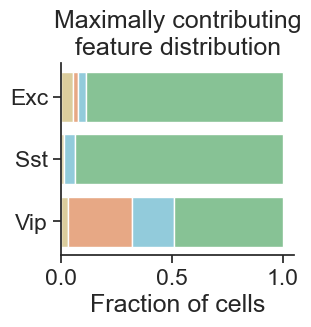

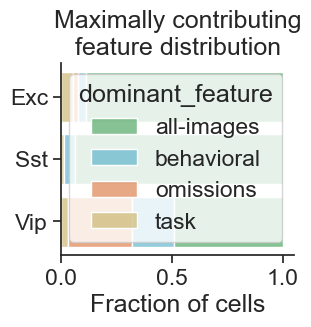

In [122]:
metric = 'dominant_feature'
c = sns.color_palette()
palette = [c[2], c[9], c[1], c[8]]
title = 'Maximally contributing\nfeature distribution'
plotting.plot_fraction_cells_distribution_stacked_barplot(coding_score_metrics, metric, palette, title, legend=False, ax=None)


metric = 'dominant_feature'
c = sns.color_palette()
palette = [c[2], c[9], c[1], c[8]]
title = 'Maximally contributing\nfeature distribution'
plotting.plot_fraction_cells_distribution_stacked_barplot(coding_score_metrics, metric, palette, title, legend=True, ax=None)


C:\Users\marinag\Documents\Code\visual_behavior_analysis\visual_behavior\dimensionality_reduction\clustering\plotting.py:4661: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([utils.get_abbreviated_cell_type(cre_line) for cre_line in utils.get_cre_lines()])
C:\Users\marinag\Documents\Code\visual_behavior_analysis\visual_behavior\dimensionality_reduction\clustering\plotting.py:4661: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([utils.get_abbreviated_cell_type(cre_line) for cre_line in utils.get_cre_lines()])


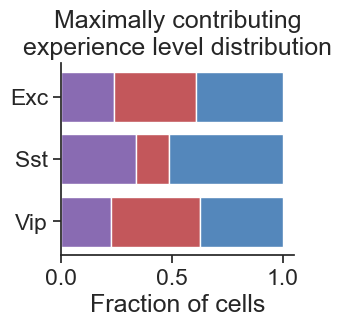

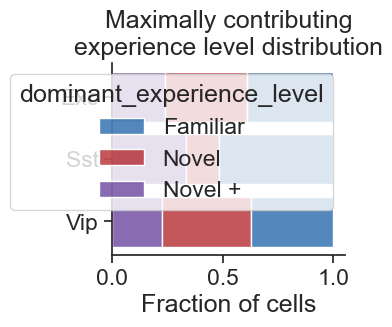

In [123]:


column_to_group = 'dominant_experience_level'
n_cells = coding_score_metrics.reset_index().groupby(['cre_line', column_to_group]).count()[['cell_specimen_id']].rename(columns={'cell_specimen_id': 'n_cells'})
total_cells = coding_score_metrics.reset_index().groupby(['cre_line']).count()[['cell_specimen_id']].rename(columns={'cell_specimen_id': 'total_cells'})
fraction_cells = n_cells.reset_index().merge(total_cells, on='cre_line', how='left')
fraction_cells['fraction'] = fraction_cells.n_cells/fraction_cells.total_cells
fraction_cells

metric = 'dominant_experience_level'
palette = experience_level_colors
title = 'Maximally contributing\nexperience level distribution'
plotting.plot_fraction_cells_distribution_stacked_barplot(coding_score_metrics, metric, palette, title, legend=False, ax=None)


metric = 'dominant_experience_level'
palette = experience_level_colors
title = 'Maximally contributing\nexperience level distribution'
plotting.plot_fraction_cells_distribution_stacked_barplot(coding_score_metrics, metric, palette, title, legend=True, ax=None)


### plot distribution of coding score metrics for clusters

metrics: 
* exp_mod_direction = N - F / N + F
* exp_mod_persistence = N+ - N / N+ + N

In [124]:
print(len(coding_score_metrics.mouse_id.unique()), 'mice')
print(len(coding_score_metrics.ophys_experiment_id.unique()), 'experiments')
print(len(coding_score_metrics.index.unique()), 'cells')

65 mice
131 experiments
3901 cells


In [125]:
# metric = 'exp_mod_direction'

# figsize = (20,5)
# fig, ax = plt.subplots(figsize=figsize)
# ax = sns.stripplot(data=coding_score_metrics, x='cluster_id', y=metric, 
#             hue='cre_line', hue_order=cre_lines, palette=cre_line_colors, dodge=True, ax=ax)
# ax = sns.boxplot(data=coding_score_metrics, x='cluster_id', y=metric, 
#             hue='cre_line', hue_order=cre_lines, color='white', ax=ax)
# ax.set_ylabel('(N - F / N + F)')
# ax.set_title('novelty modulation index')
# ax.legend(bbox_to_anchor=(1,1), fontsize='small', title_fontsize='small')

In [126]:
# metric = 'exp_mod_direction'

# figsize = (15,5)
# fig, ax = plt.subplots(figsize=figsize)
# ax = sns.pointplot(data=coding_score_metrics, x='cluster_id', y=metric, 
#             hue='cre_line', hue_order=cre_lines, palette=cre_line_colors, join=False, dodge=0.2, ax=ax)
# # ax = sns.boxplot(data=coding_score_metrics, x='cluster_id', y=metric, 
# #             hue='cre_line', hue_order=cre_lines, color='white', ax=ax)
# ax.set_ylabel('novelty modulation index')
# ax.legend(bbox_to_anchor=(1,1), fontsize='small', title_fontsize='small')

# for x in np.arange(0.5, n_clusters, 1):
#     ax.vlines(x=x, ymin=-1, ymax=1, color='gray', linestyle='--')
# ax.hlines(y=0, xmin=-0.5, xmax=n_clusters-0.5, color='gray', linestyle='--')

#### persistence of coding

In [127]:
# metric = 'exp_mod_persistence'

# figsize = (20,5)
# fig, ax = plt.subplots(figsize=figsize)
# ax = sns.stripplot(data=coding_score_metrics, x='cluster_id', y=metric, 
#             hue='cre_line', hue_order=cre_lines, palette=cre_line_colors, dodge=True, ax=ax)
# ax = sns.boxplot(data=coding_score_metrics, x='cluster_id', y=metric, 
#             hue='cre_line', hue_order=cre_lines, color='white', ax=ax)
# ax.set_ylabel('(N - N+ / N + N+)')
# ax.set_title('familiarization index')
# ax.legend(bbox_to_anchor=(1,1), fontsize='small', title_fontsize='small')

In [128]:
# # take absolute value so its just whether it is transient or not, regardless of direction
# coding_score_metrics['transience'] = 1-np.abs(coding_score_metrics.exp_mod_persistence.values)

# metric = 'transience'

# figsize = (20,5)
# fig, ax = plt.subplots(figsize=figsize)
# ax = sns.stripplot(data=coding_score_metrics, x='cluster_id', y=metric, 
#             hue='cre_line', hue_order=cre_lines, palette=cre_line_colors, dodge=True, ax=ax)
# ax = sns.boxplot(data=coding_score_metrics, x='cluster_id', y=metric, 
#             hue='cre_line', hue_order=cre_lines, color='white', ax=ax)
# ax.set_ylabel('1 - abs(N+ - N / N+ + N)')
# ax.set_title('novelty coding stability')
# ax.legend(bbox_to_anchor=(1,1), fontsize='small', title_fontsize='small')

### correlate coding score metrics with area / depth distributions

In [129]:
location = 'layer'
order = ['upper', 'lower']
n_cells_table = processing.get_cluster_proportion_stats_for_locations(cluster_meta, location=location)

metric = 'fraction_cells_location'
xlabel = 'fraction cells'
significance_col = 'bh_significant'

plotting.plot_location_distribution_across_clusters_for_cre_lines(n_cells_table, location=location, order=order,
                                                             metric=metric, xlabel=xlabel,
                                                             significance_col=significance_col,
                                                             ax=None, save_dir=save_dir, folder=folder);

InvalidIndexError: You can only assign a scalar value not a <class 'bool'>

In [ ]:

# for each cre
cluster_metrics = processing.get_cluster_metrics(cluster_meta, feature_matrix, results_pivoted)

location = 'layer'
order = ['upper', 'lower']
n_cells_table = processing.get_cluster_proportion_stats_for_locations(cluster_meta, location=location)

cluster_metrics = processing.add_layer_index_to_cluster_metrics(cluster_metrics, n_cells_table)


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


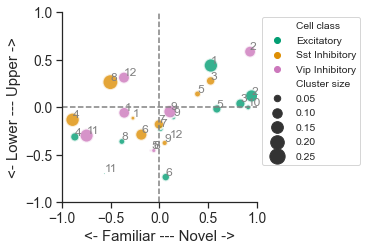

In [ ]:

# make the plot 

x = 'exp_mod_direction' # novel-familiar / sum
y = 'layer_index' # upper-lower / sum
hue = 'cell_type'

if 'cell_type' not in cluster_metrics.columns:
    # cluster_metrics['cre_line'] = cluster_metrics.index.get_level_values(0)
    cluster_metrics['cell_type'] = [utils.convert_cre_line_to_cell_type(cre_line) for cre_line in cluster_metrics.index.get_level_values(0)]

plotting.plot_cluster_metric_comparison_scatterplot(cluster_metrics, cluster_meta, x=x, y=y, hue=hue, save_dir=save_dir, folder=folder)


#### layer bias

In [ ]:
location = 'layer'
order = ['upper', 'lower']
n_cells_table = processing.get_cluster_proportion_stats_for_locations(cluster_meta, location=location)


In [ ]:
layer_index = n_cells_table[['fraction_cells_location']].unstack()
layer_index.columns = layer_index.columns.droplevel(0)
layer_index['layer_index'] = (layer_index.upper - layer_index.lower) / (layer_index.upper + layer_index.lower)
layer_index = layer_index.merge(n_cells_table[['bh_significant', 'significant']], on=['cre_line', 'cluster_id'])
layer_index = layer_index.reset_index().drop_duplicates(subset=['cre_line', 'cluster_id']).set_index(
    ['cre_line', 'cluster_id'])

data = cluster_metrics.merge(layer_index[['layer_index']], on=['cre_line', 'cluster_id'])
fraction = n_cells_table[['fraction_cells_cluster']].reset_index().drop_duplicates(
    subset=['cre_line', 'cluster_id'])
data = data.merge(fraction, on=['cre_line', 'cluster_id']).set_index(
    ['cre_line', 'cluster_id'])
data = data.drop(columns=['layer'])

### boxplot of layer index and experience modulation per cluster

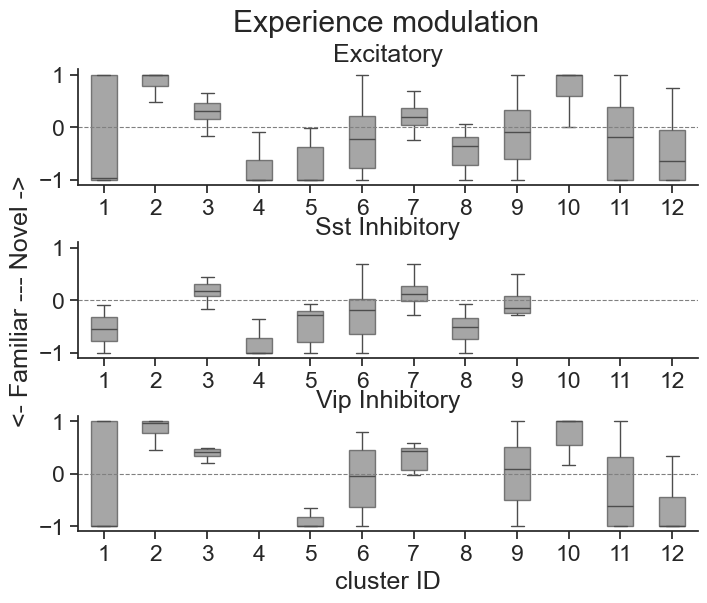

In [130]:
metric = 'experience_modulation'

order = np.sort(coding_score_metrics.cluster_id.unique())

figsize = (8, 6)
fig, ax = plt.subplots(3, 1, figsize=figsize, sharey=True, sharex=False)
for i, cre_line in enumerate(cre_lines):
    data = coding_score_metrics[coding_score_metrics.cre_line==cre_line]
    ax[i] = sns.boxplot(data=data, x='cluster_id', y=metric, order=order, showfliers=False,
                color='gray',
                width=0.5, boxprops=dict(alpha=.7), ax=ax[i])
    ax[i].set_title(utils.convert_cre_line_to_cell_type(cre_line))
    # ax[i].get_legend().remove()
    ax[i].set_xlabel('')
    ax[i].set_ylabel('')
    ax[i].axhline(y=0, xmin=0, xmax=1, linestyle='--', color='gray', linewidth=0.8)
    ax[i].spines[['right', 'top']].set_visible(False)
# ax[1].set_ylabel('Experience modulation')
ax[i].set_xlabel('cluster ID')  
ax[1].set_ylabel('<- Familiar --- Novel ->')
# ax[i].legend(bbox_to_anchor=(1,1), fontsize='xx-small', title_fontsize='xx-small')

plt.suptitle('Experience modulation', x=0.51, y=0.98)
plt.subplots_adjust(hspace=0.5)

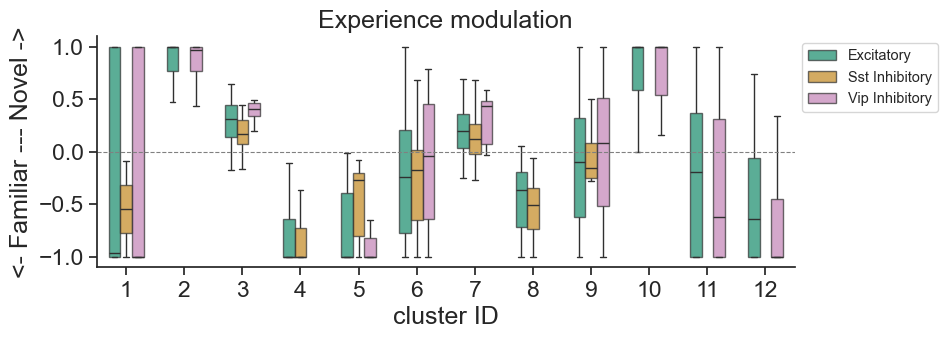

In [131]:
metric = 'experience_modulation'

cell_types = utils.get_cell_types()
cell_type_colors = utils.get_cell_type_colors()
xorder = np.sort(coding_score_metrics.cluster_id.unique())

figsize = (9,3)
fig, ax = plt.subplots(figsize=figsize)
ax = sns.boxplot(data=coding_score_metrics, x='cluster_id', y=metric, order=xorder, 
                hue='cell_type', hue_order=cell_types, palette=cell_type_colors, 
                showfliers=False,  width=0.6, boxprops=dict(alpha=.7), ax=ax)
ax.set_title('Experience modulation')
ax.set_xlabel('cluster ID')  
ax.set_ylabel('<- Familiar --- Novel ->')
ax.spines[['right', 'top']].set_visible(False)
ax.axhline(y=0, xmin=0, xmax=1, linestyle='--', color='gray', linewidth=0.8)
ax.legend(bbox_to_anchor=(1,1), fontsize='xx-small', title_fontsize='xx-small')


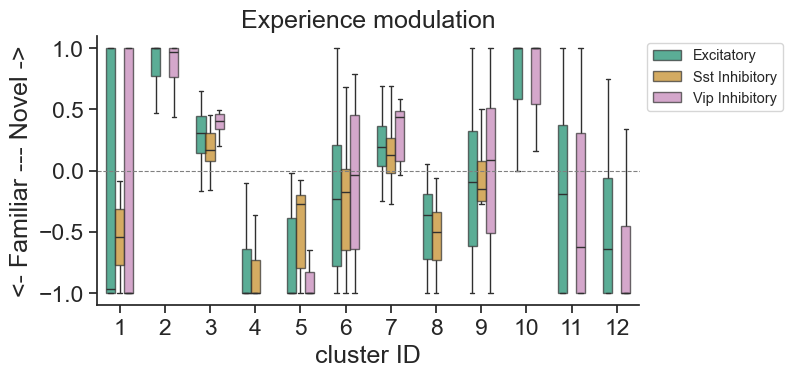

In [132]:
metric = 'experience_modulation'

cell_types = utils.get_cell_types()
cell_type_colors = utils.get_cell_type_colors()
xorder = np.sort(coding_score_metrics.cluster_id.unique())

figsize = (7,3.5)
fig, ax = plt.subplots(figsize=figsize)
ax = sns.boxplot(data=coding_score_metrics, x='cluster_id', y=metric, order=xorder, 
                hue='cell_type', hue_order=cell_types, palette=cell_type_colors, 
                showfliers=False,  width=0.6, boxprops=dict(alpha=.7), ax=ax)
ax.set_title('Experience modulation')
ax.set_xlabel('cluster ID')  
ax.set_ylabel('<- Familiar --- Novel ->')
ax.spines[['right', 'top']].set_visible(False)
ax.axhline(y=0, xmin=0, xmax=1, linestyle='--', color='gray', linewidth=0.8)
ax.legend(bbox_to_anchor=(1,1), fontsize='xx-small', title_fontsize='xx-small')


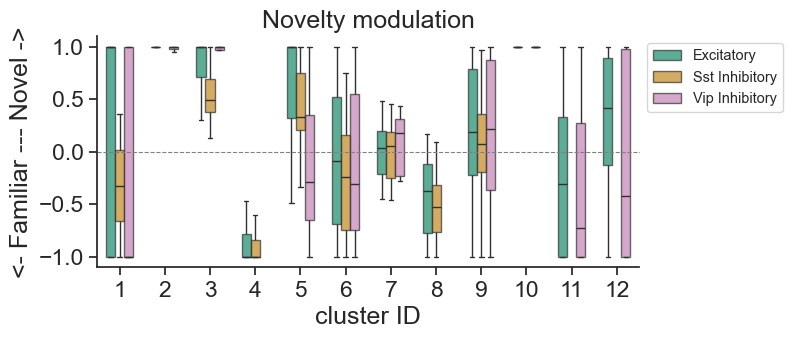

In [133]:
metric = 'exp_mod_direction'

cell_types = utils.get_cell_types()
c = sns.color_palette('colorblind')
cell_type_colors = [c[2], c[1], c[4]]
xorder = np.sort(coding_score_metrics.cluster_id.unique())

figsize = (7,3)
fig, ax = plt.subplots(figsize=figsize)
ax = sns.boxplot(data=coding_score_metrics, x='cluster_id', y=metric, order=xorder, 
                hue='cell_type', hue_order=cell_types, palette=cell_type_colors, 
                showfliers=False,  width=0.6, boxprops=dict(alpha=.7), ax=ax)
ax.set_title('Novelty modulation')
ax.set_xlabel('cluster ID')  
ax.set_ylabel('<- Familiar --- Novel ->')
ax.spines[['right', 'top']].set_visible(False)
ax.axhline(y=0, xmin=0, xmax=1, linestyle='--', color='gray', linewidth=0.8)
ax.legend(bbox_to_anchor=(1,1), fontsize='xx-small', title_fontsize='xx-small')


In [134]:
layer_index = layer_index.reset_index()
layer_index['cell_type'] = [utils.convert_cre_line_to_cell_type(cre_line) for cre_line in layer_index['cre_line'].values]

metric = 'layer_index'

cell_types = utils.get_cell_types()
c = sns.color_palette('colorblind')
cell_type_colors = [c[2], c[1], c[4]]
xorder = np.sort(coding_score_metrics.cluster_id.unique())

figsize = (7,3)
fig, ax = plt.subplots(figsize=figsize)
ax = sns.barplot(data=layer_index, x='cluster_id', y=metric, order=xorder, 
                hue='cell_type', hue_order=cell_types, palette=cell_type_colors, 
                width=0.8, ax=ax)
ax.set_title('Depth bias')
ax.set_xlabel('cluster ID')  
ax.set_ylabel('<- Lower --- Upper ->')
ax.spines[['right', 'top']].set_visible(False)
ax.axhline(y=0, xmin=0, xmax=1, linestyle='--', color='gray', linewidth=0.8)
ax.legend(bbox_to_anchor=(1,1), fontsize='xx-small', title_fontsize='xx-small')


NameError: name 'layer_index' is not defined

### fraction cells per area and depth (move to upper part of notebook)

In [ ]:
n_cells_table = processing.get_cluster_proportion_stats_for_locations(cluster_meta, location=location)
n_cells_table = n_cells_table.reset_index()


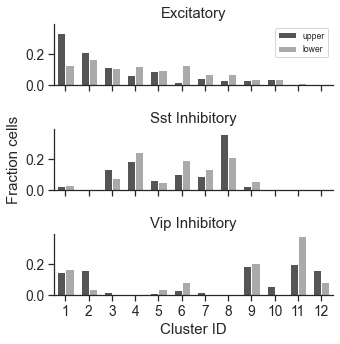

In [ ]:
# def plot_metric_distribution_across_clusters_experience_levels(metrics_df, metric, ylabel=None,
#                                                     save_dir=None, folder=None, ax=None):
# '''
# Plots metric disributions as boxplots with cluster ID on x axis and metric value on y axis,
# with one axis (row) per cre line, split & colored by experience levels

# metrics_df: dataframe containing metric values with one row for each cell_specimen_id & experience level
# metrics: string, name of column in metrics df to plot metrics for
# '''

hue = 'layer'
hue_order = np.sort(n_cells_table[hue].unique())[::-1]

metric = 'fraction_cells_location'
ylabel = 'Fraction cells'
significance_col = 'bh_significant'

cre_lines = utils.get_cre_lines()
xorder = np.sort(n_cells_table['cluster_id'].unique())

# if ax is None:
figsize = (5, 5)
fig, ax = plt.subplots(3, 1, figsize=figsize, sharey=True, sharex=True)
for i, cre_line in enumerate(cre_lines):
    data = n_cells_table[n_cells_table.cre_line==cre_line]
    ax[i] = sns.barplot(data=data, x='cluster_id', y=metric, order=xorder, 
                        hue=hue, hue_order=hue_order, palette='gray', width=0.7, ax=ax[i])
    ax[i].get_legend().remove()
    ax[i].set_title(utils.convert_cre_line_to_cell_type(cre_line))
    ax[i].set_xlabel('')
    ax[i].set_ylabel('')
    # ax[i].set_xticks(order+1)
    # ax[i].set_xlim((0.5, n_clusters+0.5))
    ax[i].spines[['right', 'top']].set_visible(False)
    # ax[i].axhlines(y=0, xmin=0, xmax=1, linestyle='--', color='gray')
ax[1].set_ylabel(ylabel)
ax[i].set_xlabel('Cluster ID')  
ax[0].legend(loc='upper right', fontsize='xx-small', title_fontsize='xx-small')

# plt.suptitle(ylabel, x=0.51, y=0.95)
plt.subplots_adjust(hspace=0.7, wspace=0.5)

if save_dir: 
    filename = metric+'_'+hue
    utils.save_figure(fig, figsize, save_dir, 'metric_distributions_for_clusters', filename)

In [ ]:
# def plot_fraction_cells_per_cluster_per_cre(cluster_meta, col_to_group='cre_line', save_dir=None, folder=None):
#     '''
#     plots the fraction of cells in each cre line belonging to each cluster as a barplot
#     with one axis / row per cre line
#     '''

n_cells_table = processing.get_cluster_proportion_stats_for_locations(cluster_meta, location=location)
n_cells_table = n_cells_table.reset_index()


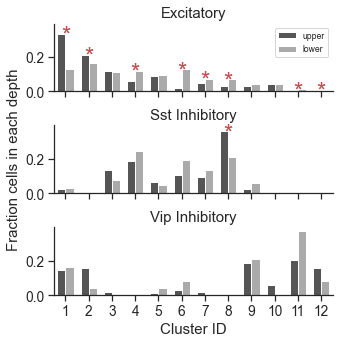

In [ ]:

xorder = np.sort(n_cells_table.cluster_id.unique())

hue = 'layer'
hue_order = np.sort(n_cells_table[hue].unique())[::-1]

metric = 'fraction_cells_location'
ylabel = 'Fraction cells'
significance_col = 'bh_significant'


figsize = (5, 5)
fig, ax = plt.subplots(3, 1, figsize=figsize, sharey=True, sharex=True)
for i, cre_line in enumerate(utils.get_cre_lines()):
    cre_data = n_cells_table[n_cells_table.cre_line == cre_line]
    
    # order = cre_data.sort_values(by='fraction_per_cluster')['cluster_id'][::-1]
    ax[i] = sns.barplot(data=cre_data, x='cluster_id', order=xorder, y=metric,
                        hue=hue, hue_order=hue_order, palette='gray', width=0.7, ax=ax[i])
    ax[i].get_legend().remove()
    ax[i].set_ylabel('')
    ax[i].set_xlabel('')
    # ax[i].set_ylim(0, 0.3)
    ax[i].set_title(utils.convert_cre_line_to_cell_type(cre_line))
    
    for x_loc, cluster_id in enumerate(xorder): 
        cre_cluster_data = cre_data[cre_data['cluster_id']==cluster_id]
        if cre_cluster_data[significance_col].any(): 
            y_loc = cre_cluster_data[metric].max()-0.015 # ylocation slightly higher than max value
            ax[i].text(x_loc, y_loc, '*', fontsize=24, color=sns.color_palette()[3],
                    horizontalalignment='center', verticalalignment='center')
    # if len(cre_data)>0:
    #     ppf.add_stats_to_plot_for_hues(cre_data, metric, ax[i], ymax=None, xorder=xorder, x='cluster_id', hue=hue)

ax[1].set_ylabel('Fraction cells in each depth')
ax[i].set_xlabel('Cluster ID')
ax[0].legend(loc='upper right', fontsize='xx-small', title_fontsize='xx-small')
sns.despine(fig=fig, top=True, right=True, left=False, bottom=False, offset=None, trim=False)



plt.subplots_adjust(hspace=0.5)

if save_dir:
    utils.save_figure(fig, figsize, save_dir, folder, 'fraction_cells_per_cluster_per_cre_per_layer')

## model free metrics

In [ ]:
import visual_behavior.ophys.response_analysis.cell_metrics as cm

In [ ]:
# # filepath = r"\\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache\cell_metrics\interpolated_30Hz\808619543_changes_pref_image_full_session_events.h5"
# filepath = r"\\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache\cell_metrics\interpolated_30Hz\808619543_images_all_images_full_session_events.h5"
# tmp = pd.read_csv(filepath)
# tmp.head()

In [ ]:
# # ophys_experiment_ids = [808619543]
# ophys_experiment_ids = platform_experiments.index.values

# condition = 'images'
# stimuli = 'all_images'
# session_subset = 'full_session'

# metrics_table = cm.load_metrics_table_for_experiments(ophys_experiment_ids, condition, stimuli, session_subset,
#                                        data_type='events', interpolate=True, output_sampling_rate=30)

In [ ]:
metrics = processing.generate_merged_table_of_coding_score_and_model_free_metrics(cluster_meta, results_pivoted,
                                                                 data_type='events',
                                                                 session_subset='full_session',
                                                                 inclusion_criteria='platform_experiment_table',
                                                                 save_dir=save_dir)

loading coding score and model free metrics table


In [ ]:
print(len(metrics.mouse_id.unique()), 'mice')
print(len(metrics.ophys_experiment_id.unique()), 'experiments')
print(len(metrics.cell_specimen_id.unique()), 'cells')

65 mice
393 experiments
3901 cells


In [ ]:
# merge in cluster IDs
metrics = metrics.merge(cluster_meta.reset_index()[['cell_specimen_id', 'cluster_id']], on='cell_specimen_id')

### all images

Response metrics table contains one row per cell per experiment

In [ ]:
# data_type = 'filtered_events'

# condition = 'images'
# stimuli = 'all_images'
# session_subset = 'full_session'

# # set inclusion criteria
# # options: ['active_only', 'closest_familiar_and_novel', 'containers_with_all_levels', 'platform_experiment_table']
# inclusion_criteria = 'platform_experiment_table'
    
# response_metrics = cm.get_cell_metrics_for_conditions(data_type, condition, stimuli, session_subset, inclusion_criteria)

# # convert experience level
# response_metrics['experience_level'] = [utils.convert_experience_level(experience_level) for experience_level in response_metrics.experience_level.values]

# # limit to matched cells
# response_metrics = response_metrics[response_metrics.cell_specimen_id.isin(matched_cells)]
# len(response_metrics)

In [ ]:
response_metrics = metrics.copy()

In [ ]:
print(len(response_metrics.mouse_id.unique()), 'mice')
print(len(response_metrics.ophys_experiment_id.unique()), 'experiments')
print(len(response_metrics.cell_specimen_id.unique()), 'cells')

65 mice
368 experiments
3921 cells


In [ ]:
print(len(cluster_meta.mouse_id.unique()), 'mice')
print(len(cluster_meta.index.unique()), 'cells')

65 mice
3901 cells


In [ ]:
response_metrics.head()

cell_specimen_id pref_image non_pref_image  image_selectivity_index  \
0        1086490397      im085          im066                 0.872306   
1        1086490397      im045          im031                 0.994846   
2        1086490397      im045          im031                 0.877561   
3        1086490441      im062          im069                 0.967695   
4        1086490441      im000          im106                 0.986095   

   image_selectivity_index_one_vs_all  lifetime_sparseness  mean_response  \
0                            0.584549             0.422220       0.000399   
1                            0.537192             0.425819       0.002755   
2                            0.556740             0.406456       0.000146   
3                            0.827179             0.805567       0.003111   
4                            0.677209             0.618872       0.010835   

   fraction_significant_p_value_gray_screen  fano_factor  reliability  ...  \
0                                  0.000000    14.370119     0.338260  ...   
1                                  0.119577     6.551801     0.184142  ...   
2                                  0.017382    17.587489     0.212663  ...   
3                                  0.081462     9.315433     0.115776  ...   
4                                  0.224261     4.737115     0.169347  ...   

   area_layer      date first_novel n_relative_to_first_novel last_familiar  \
0  VISp_upper  20181213       False                      -1.0          True   
1  VISp_upper  20181214        True                       0.0         False   
2  VISp_upper  20181216       False                       2.0         False   
3  VISp_upper  20181213       False                      -1.0          True   
4  VISp_upper  20181214        True                       0.0         False   

  last_familiar_active second_novel  second_novel_active  experience_exposure  \
0                 True        False                False           Familiar 3   
1                False        False                False              Novel 0   
2                False        False                 True              Novel 2   
3                 True        False                False           Familiar 3   
4                False        False                False              Novel 0   

  cluster_id  
0         10  
1         10  
2         10  
3          1  
4          1  

[5 rows x 62 columns]

In [ ]:
cluster_ids = cluster_meta.cluster_id.unique()
n_clusters = len(cluster_ids)
n_clusters


12

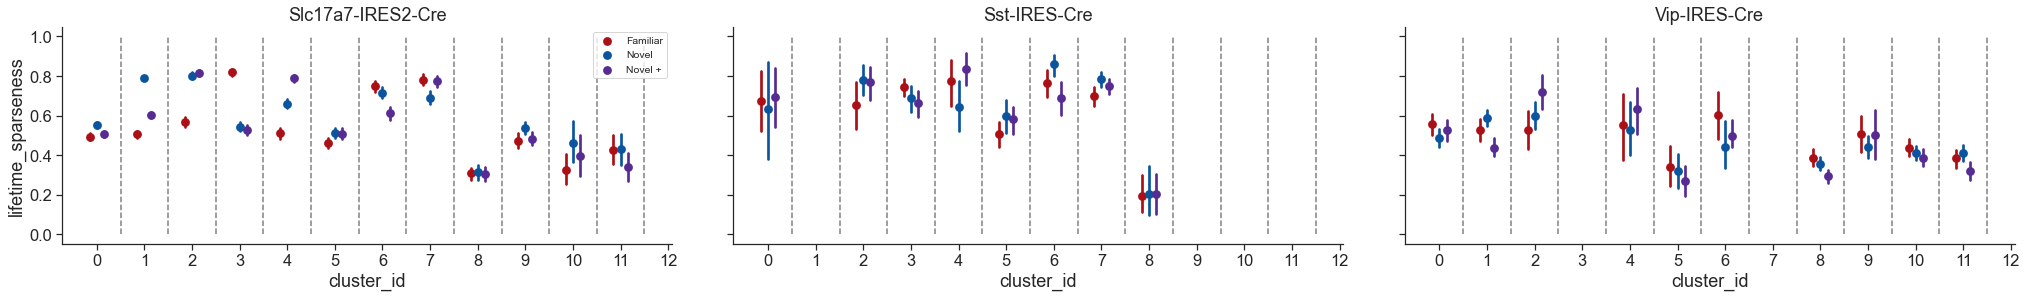

In [ ]:
metric = 'lifetime_sparseness_images'

order = np.arange(0, n_clusters+1, 1)

figsize = (35,4)
fig, ax = plt.subplots(1, 3, figsize=figsize, sharey=True)
for i, cre_line in enumerate(cre_lines):
    data = response_metrics[response_metrics.cre_line==cre_line]
    ax[i] = sns.pointplot(data=data, x='cluster_id', y=metric, order=order,
                hue='experience_level', hue_order=experience_levels, palette=experience_level_colors, 
                          join=False, dodge=0.3, ax=ax[i])
    ax[i].set_title(cre_line)
    ax[i].get_legend().remove()
    ax[i].set_ylabel('')
    for x in np.arange(0.5, n_clusters, 1):
        ax[i].vlines(x=x, ymin=0, ymax=1, color='gray', linestyle='--')
    
ax[0].set_ylabel(metric)
ax[0].legend(bbox_to_anchor=(1,1), fontsize='xx-small', title_fontsize='xx-small')

plt.subplots_adjust(wspace=0.1)

In [ ]:
def plot_metric_distribution_across_clusters_experience_levels(metrics_df, metric, ylabel=None,
                                                        save_dir=None, folder=None, ax=None):
    '''
    Plots metric disributions as boxplots with cluster ID on x axis and metric value on y axis,
    with one axis (row) per cre line, split & colored by experience levels

    metrics_df: dataframe containing metric values with one row for each cell_specimen_id & experience level
    metrics: string, name of column in metrics df to plot metrics for
    '''
    cre_lines = utils.get_cre_lines()
    xorder = np.sort(metrics_df['cluster_id'].unique())
    experience_levels = utils.get_experience_levels()
    experience_level_colors = utils.get_experience_level_colors() 
    
    if ax is None:
        figsize = (10, 9)
        fig, ax = plt.subplots(3, 1, figsize=figsize, sharey=True, sharex=False)
    for i, cre_line in enumerate(cre_lines):
        data = metrics_df[metrics_df.cre_line==cre_line]
        ax[i] = sns.boxplot(data=data, x='cluster_id', y=metric, order=xorder, showfliers=False,
                        hue='experience_level', hue_order=experience_levels, palette=experience_level_colors, 
                        width=0.5, boxprops=dict(alpha=.7), ax=ax[i])
        ax[i].get_legend().remove()
        ax[i].set_title(utils.convert_cre_line_to_cell_type(cre_line))
        ax[i].set_xlabel('')
        ax[i].set_ylabel('')
        # ax[i].set_xticks(order+1)
        # ax[i].set_xlim((0.5, n_clusters+0.5))
        ax[i].spines[['right', 'top']].set_visible(False)
        ax[i].axhlines(y=0, xmin=0, xmax=1, linestyle='--', color='gray')
    ax[1].set_ylabel(ylabel)
    ax[i].set_xlabel('Cluster ID')  
    ax[i].legend(bbox_to_anchor=(1,1), fontsize='xx-small', title_fontsize='xx-small')

    plt.suptitle(ylabel, x=0.51, y=0.95)
    plt.subplots_adjust(hspace=0.5)

    if save_dir: 
        filename = metric+'_across_clusters_by_experience_level'
        utils.save_figure(fig, figsize, save_dir, 'metric_distributions_for_clusters', filename)

In [ ]:
metric = 'lifetime_sparseness_images'
ylabel = 'Image selectivity'
plot_metric_distribution_across_clusters_cre_lines(response_metrics, metric, ylabel=None, 
                                                       save_dir=None, folder=None, ax=None)


NameError: name 'response_metrics' is not defined

In [ ]:
response_metrics.keys()

NameError: name 'response_metrics' is not defined

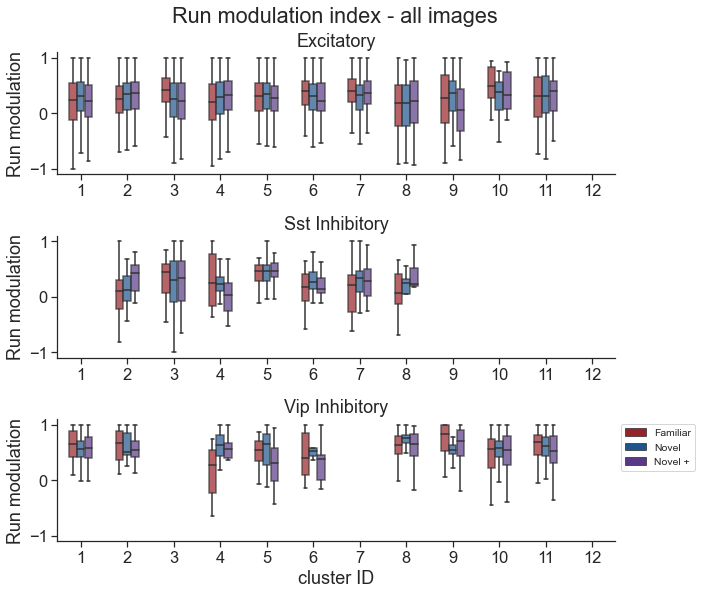

In [ ]:
metric = 'running_modulation_index'

order = np.arange(0, n_clusters+1, 1)

figsize = (10, 9)
fig, ax = plt.subplots(3, 1, figsize=figsize, sharey=True, sharex=False)
for i, cre_line in enumerate(cre_lines):
    data = response_metrics[response_metrics.cre_line==cre_line]
    ax[i] = sns.boxplot(data=data, x='cluster_id', y=metric, order=order, showfliers=False,
                hue='experience_level', hue_order=experience_levels, palette=experience_level_colors, 
                width=0.5, boxprops=dict(alpha=.7), ax=ax[i])
    ax[i].set_title(utils.convert_cre_line_to_cell_type(cre_line))
    ax[i].get_legend().remove()
    ax[i].set_xlabel('')
    ax[i].set_ylabel('Run modulation')
    ax[i].set_xticks(order+1)
    ax[i].set_xlim((0.5, n_clusters+0.5))
    ax[i].spines[['right', 'top']].set_visible(False)
ax[i].set_xlabel('cluster ID')  
ax[i].legend(bbox_to_anchor=(1,1), fontsize='xx-small', title_fontsize='xx-small')

plt.suptitle('Run modulation index - all images', x=0.51, y=0.95)
plt.subplots_adjust(hspace=0.5)

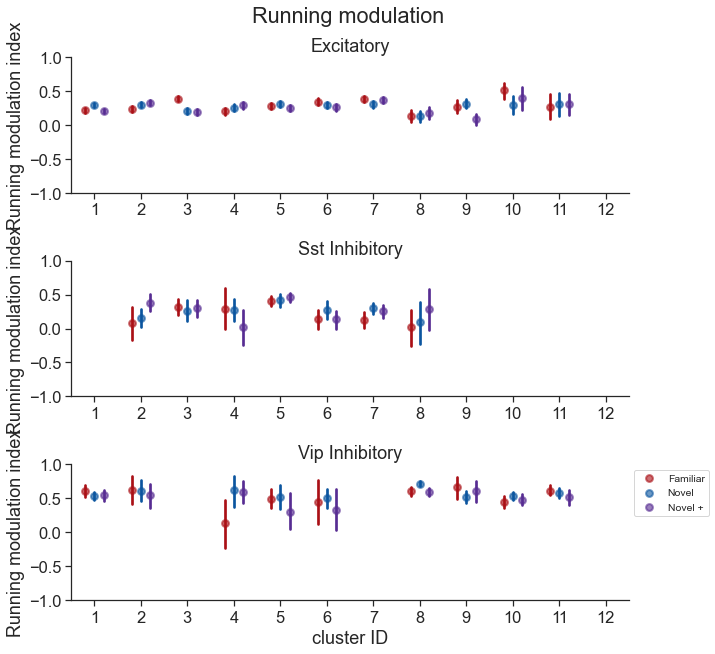

In [ ]:
metric = 'running_modulation_index'

order = np.arange(0, n_clusters+1, 1)

figsize = (10, 10)
fig, ax = plt.subplots(3, 1, figsize=figsize, sharey=True, sharex=False)
for i, cre_line in enumerate(cre_lines):
    data = response_metrics[response_metrics.cre_line==cre_line]
    # ax[i] = sns.violinplot(data=data, x='cluster_id', y=metric, order=order, showfliers=False,
    #             hue='experience_level', hue_order=experience_levels, palette=experience_level_colors, 
    #             width=0.6,  inner=None, ax=ax[i])
    ax[i] = sns.pointplot(data=data, x='cluster_id', y=metric, order=order, 
                hue='experience_level', hue_order=experience_levels, palette=experience_level_colors, 
                join=False, dodge=0.4, ax=ax[i])
    ax[i].set_title(utils.convert_cre_line_to_cell_type(cre_line))
    ax[i].get_legend().remove()
    ax[i].set_xlabel('')
    ax[i].set_ylabel('Running modulation index')
    ax[i].set_xticks(order+1)
    ax[i].set_xlim((0.5, n_clusters+0.5))
    ax[i].set_ylim(-1, 1)
    ax[i].spines[['right', 'top']].set_visible(False)
    plt.setp(ax[i].collections, alpha=.6)

ax[i].set_xlabel('cluster ID')  
ax[i].legend(bbox_to_anchor=(1,1), fontsize='xx-small', title_fontsize='xx-small')

plt.suptitle('Running modulation', x=0.51, y=0.95)
plt.subplots_adjust(hspace=0.5)

### preferred stimulus response reliability

In [ ]:
data_type = 'filtered_events'

condition = 'images'
stimuli = 'pref_image'
session_subset = 'full_session'

# set inclusion criteria
# options: ['active_only', 'closest_familiar_and_novel', 'containers_with_all_levels', 'platform_experiment_table']
inclusion_criteria = 'platform_experiment_table'
    
pref_stim_response_metrics = cm.get_cell_metrics_for_conditions(data_type, condition, stimuli, session_subset, inclusion_criteria)


# convert experience level
pref_stim_response_metrics['experience_level'] = [utils.convert_experience_level(experience_level) for experience_level in pref_stim_response_metrics.experience_level.values]
# limit to matched cells
pref_stim_response_metrics = pref_stim_response_metrics[pref_stim_response_metrics.cell_specimen_id.isin(matched_cells)]
# add cluster ID
pref_stim_response_metrics = pref_stim_response_metrics.merge(cluster_meta.reset_index()[['cell_specimen_id', 'cluster_id']], on='cell_specimen_id')

C:\Users\marinag\Documents\Code\AllenSDK\allensdk\api\cloud_cache\cloud_cache.py:521: OutdatedManifestWarning: You are loading visual-behavior-ophys_project_manifest_v1.0.1.json. A more up to date version of the dataset -- visual-behavior-ophys_project_manifest_v1.1.0.json -- exists online. To see the changes between the two versions of the dataset, run
VisualBehaviorOphysProjectCache.compare_manifests('visual-behavior-ophys_project_manifest_v1.0.1.json', 'visual-behavior-ophys_project_manifest_v1.1.0.json')
To load another version of the dataset, run
VisualBehaviorOphysProjectCache.load_manifest('visual-behavior-ophys_project_manifest_v1.1.0.json')
  warnings.warn(msg, OutdatedManifestWarning)


removing 1 problematic experiments
there are 402 experiments after filtering for inclusion criteria -  platform_experiment_table


  8%|▊         | 33/402 [00:06<01:43,  3.56it/s]

problem for experiment 891994418


 12%|█▏        | 48/402 [00:10<01:40,  3.53it/s]

problem for experiment 948507789


 23%|██▎       | 92/402 [00:20<00:46,  6.68it/s]

problem for experiment 994790561


 35%|███▍      | 139/402 [00:34<01:03,  4.17it/s]

problem for experiment 993369859


 36%|███▌      | 144/402 [00:35<00:54,  4.74it/s]

problem for experiment 993891845


 37%|███▋      | 150/402 [00:38<01:18,  3.21it/s]

problem for experiment 993369863


 38%|███▊      | 152/402 [00:38<01:04,  3.88it/s]

problem for experiment 994082680


 45%|████▌     | 182/402 [00:47<01:09,  3.16it/s]

problem for experiment 851085100


 47%|████▋     | 188/402 [00:49<01:02,  3.44it/s]

problem for experiment 851085109


 48%|████▊     | 191/402 [00:50<00:54,  3.85it/s]

problem for experiment 851085105


 50%|█████     | 203/402 [00:53<00:55,  3.56it/s]

problem for experiment 991852002


 52%|█████▏    | 209/402 [00:54<00:59,  3.23it/s]

problem for experiment 991852001


 54%|█████▍    | 218/402 [00:57<00:58,  3.14it/s]

problem for experiment 991852004


 55%|█████▍    | 221/402 [00:57<00:45,  4.00it/s]

problem for experiment 991852005


 64%|██████▍   | 258/402 [01:09<00:29,  4.92it/s]

problem for experiment 977978321


 68%|██████▊   | 272/402 [01:11<00:30,  4.26it/s]

problem for experiment 981178537


 69%|██████▉   | 279/402 [01:13<00:24,  4.97it/s]

problem for experiment 882551935


 71%|███████   | 285/402 [01:14<00:21,  5.51it/s]

problem for experiment 882551937


 72%|███████▏  | 288/402 [01:14<00:18,  6.19it/s]

problem for experiment 882551947


 73%|███████▎  | 293/402 [01:15<00:20,  5.42it/s]

problem for experiment 951213203


 80%|████████  | 322/402 [01:21<00:15,  5.00it/s]

problem for experiment 1050762972


 81%|████████  | 326/402 [01:21<00:12,  5.89it/s]

problem for experiment 1051249031


 82%|████████▏ | 330/402 [01:22<00:09,  7.71it/s]

problem for experiment 1051423446


 86%|████████▌ | 346/402 [01:25<00:11,  4.77it/s]

problem for experiment 1076776838


 90%|█████████ | 362/402 [01:28<00:07,  5.13it/s]

problem for experiment 1078904675


 93%|█████████▎| 373/402 [01:30<00:04,  6.37it/s]

problem for experiment 1077597082


 94%|█████████▎| 376/402 [01:31<00:03,  6.98it/s]

problem for experiment 1082841182


100%|██████████| 402/402 [01:36<00:00,  4.15it/s]
c:\Users\marinag\Anaconda3\envs\visual_behavior_sdk\lib\site-packages\pandas\core\generic.py:2718: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['condition', 'data_type', 'exception', 'filter_events', 'interpolate',
       'ophys_experiment_id', 'session_subset', 'stimuli', 'use_events'],
      dtype='object')]

  encoding=encoding,


there are 375 experiments in the returned cell_metrics table


C:\Users\marinag\Documents\Code\AllenSDK\allensdk\api\cloud_cache\cloud_cache.py:521: OutdatedManifestWarning: You are loading visual-behavior-ophys_project_manifest_v1.0.1.json. A more up to date version of the dataset -- visual-behavior-ophys_project_manifest_v1.1.0.json -- exists online. To see the changes between the two versions of the dataset, run
VisualBehaviorOphysProjectCache.compare_manifests('visual-behavior-ophys_project_manifest_v1.0.1.json', 'visual-behavior-ophys_project_manifest_v1.1.0.json')
To load another version of the dataset, run
VisualBehaviorOphysProjectCache.load_manifest('visual-behavior-ophys_project_manifest_v1.1.0.json')
  warnings.warn(msg, OutdatedManifestWarning)
C:\Users\marinag\Documents\Code\AllenSDK\allensdk\api\cloud_cache\cloud_cache.py:521: OutdatedManifestWarning: You are loading visual-behavior-ophys_project_manifest_v1.0.1.json. A more up to date version of the dataset -- visual-behavior-ophys_project_manifest_v1.1.0.json -- exists online. To s

removing 1 problematic experiments


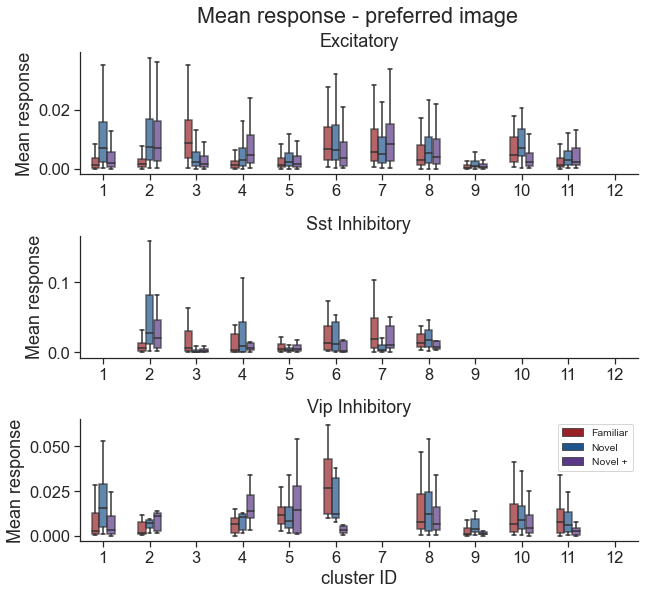

In [ ]:
metric = 'mean_response'

order = np.arange(0, n_clusters+1, 1)

figsize = (10, 9)
fig, ax = plt.subplots(3, 1, figsize=figsize, sharey=False, sharex=False)
for i, cre_line in enumerate(cre_lines):
    data = pref_stim_response_metrics[pref_stim_response_metrics.cre_line==cre_line]
    data = data[data.mean_response<np.percentile(data.mean_response.values, 95)]
    ax[i] = sns.boxplot(data=data, x='cluster_id', y=metric, order=order, showfliers=False,
                hue='experience_level', hue_order=experience_levels, palette=experience_level_colors, 
                width=0.5, boxprops=dict(alpha=.7), ax=ax[i])
    ax[i].set_title(utils.convert_cre_line_to_cell_type(cre_line))
    ax[i].get_legend().remove()
    ax[i].set_xlabel('')
    ax[i].set_ylabel('Mean response')
    ax[i].set_xticks(order+1)
    ax[i].set_xlim((0.5, n_clusters+0.5))
    ax[i].spines[['right', 'top']].set_visible(False)
ax[i].set_xlabel('cluster ID')  
ax[i].legend(bbox_to_anchor=(1,1), fontsize='xx-small', title_fontsize='xx-small')

plt.suptitle('Mean response - preferred image', x=0.51, y=0.95)
plt.subplots_adjust(hspace=0.5)

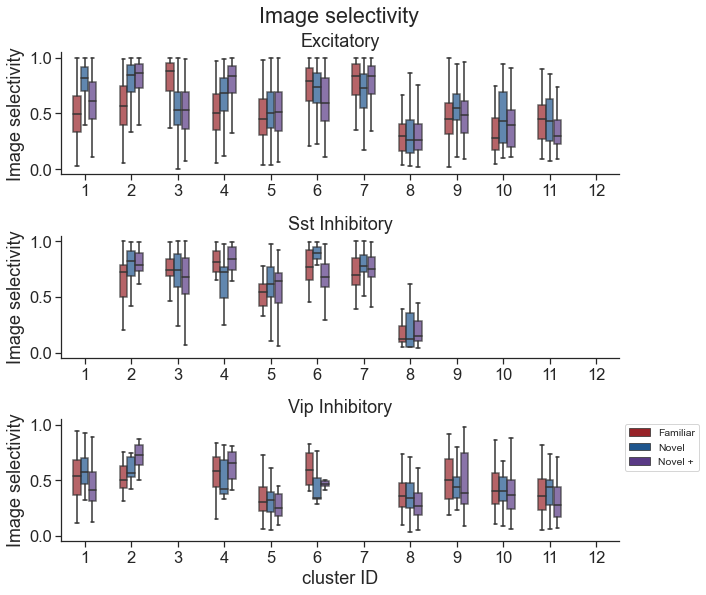

In [ ]:
metric = 'lifetime_sparseness'

order = np.arange(0, n_clusters+1, 1)

figsize = (10, 9)
fig, ax = plt.subplots(3, 1, figsize=figsize, sharey=True, sharex=False)
for i, cre_line in enumerate(cre_lines):
    data = pref_stim_response_metrics[pref_stim_response_metrics.cre_line==cre_line]
    ax[i] = sns.boxplot(data=data, x='cluster_id', y=metric, order=order, showfliers=False,
                hue='experience_level', hue_order=experience_levels, palette=experience_level_colors, 
                width=0.5, boxprops=dict(alpha=.7), ax=ax[i])
    ax[i].set_title(utils.convert_cre_line_to_cell_type(cre_line))
    ax[i].get_legend().remove()
    ax[i].set_xlabel('')
    ax[i].set_ylabel('Image selectivity')
    ax[i].set_xticks(order+1)
    ax[i].set_xlim((0.5, n_clusters+0.5))
    ax[i].spines[['right', 'top']].set_visible(False)
ax[i].set_xlabel('cluster ID')  
ax[i].legend(bbox_to_anchor=(1,1), fontsize='xx-small', title_fontsize='xx-small')

plt.suptitle('Image selectivity', x=0.51, y=0.95)
plt.subplots_adjust(hspace=0.5)

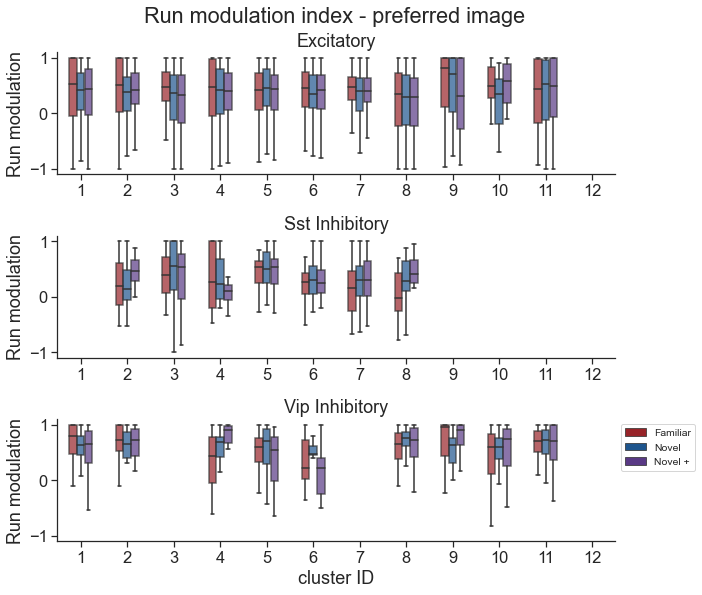

In [ ]:
metric = 'running_modulation_index'

order = np.arange(0, n_clusters+1, 1)

figsize = (10, 9)
fig, ax = plt.subplots(3, 1, figsize=figsize, sharey=True, sharex=False)
for i, cre_line in enumerate(cre_lines):
    data = pref_stim_response_metrics[pref_stim_response_metrics.cre_line==cre_line]
    ax[i] = sns.boxplot(data=data, x='cluster_id', y=metric, order=order, showfliers=False,
                hue='experience_level', hue_order=experience_levels, palette=experience_level_colors, 
                width=0.5, boxprops=dict(alpha=.7), ax=ax[i])
    ax[i].set_title(utils.convert_cre_line_to_cell_type(cre_line))
    ax[i].get_legend().remove()
    ax[i].set_xlabel('')
    ax[i].set_ylabel('Run modulation')
    ax[i].set_xticks(order+1)
    ax[i].set_xlim((0.5, n_clusters+0.5))
    ax[i].spines[['right', 'top']].set_visible(False)
ax[i].set_xlabel('cluster ID')  
ax[i].legend(bbox_to_anchor=(1,1), fontsize='xx-small', title_fontsize='xx-small')

plt.suptitle('Run modulation index - preferred image', x=0.51, y=0.95)
plt.subplots_adjust(hspace=0.5)

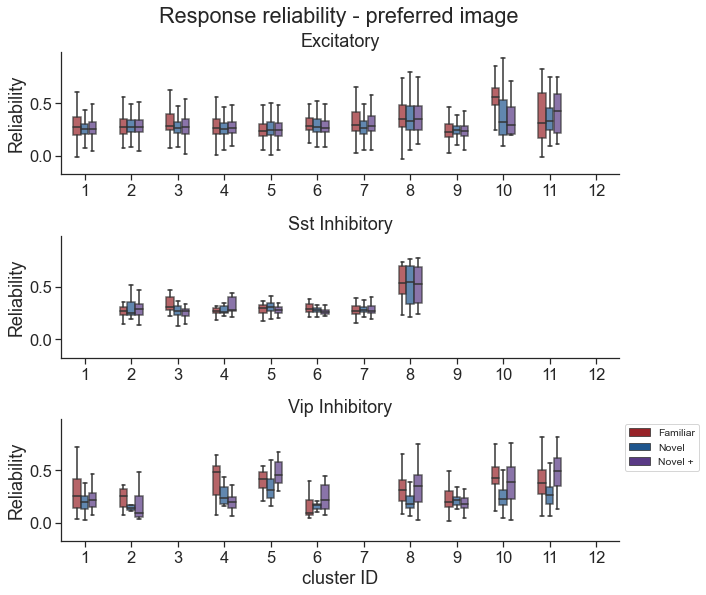

In [ ]:
metric = 'reliability'

order = np.arange(0, n_clusters+1, 1)

figsize = (10, 9)
fig, ax = plt.subplots(3, 1, figsize=figsize, sharey=True, sharex=False)
for i, cre_line in enumerate(cre_lines):
    data = pref_stim_response_metrics[pref_stim_response_metrics.cre_line==cre_line]
    ax[i] = sns.boxplot(data=data, x='cluster_id', y=metric, order=order, showfliers=False,
                hue='experience_level', hue_order=experience_levels, palette=experience_level_colors, 
                width=0.5, boxprops=dict(alpha=.7), ax=ax[i])
    ax[i].set_title(utils.convert_cre_line_to_cell_type(cre_line))
    ax[i].get_legend().remove()
    ax[i].set_xlabel('')
    ax[i].set_ylabel('Reliability')
    ax[i].set_xticks(order+1)
    ax[i].set_xlim((0.5, n_clusters+0.5))
    ax[i].spines[['right', 'top']].set_visible(False)
ax[i].set_xlabel('cluster ID')  
ax[i].legend(bbox_to_anchor=(1,1), fontsize='xx-small', title_fontsize='xx-small')

plt.suptitle('Response reliability - preferred image', x=0.51, y=0.95)
plt.subplots_adjust(hspace=0.5)

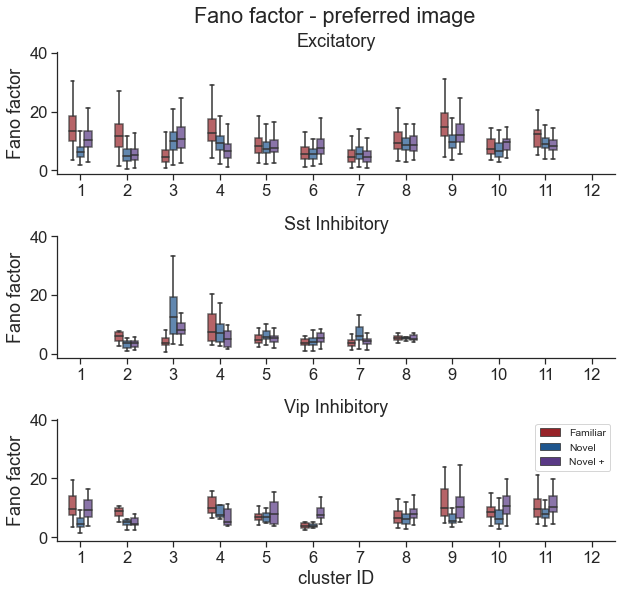

In [ ]:
metric = 'fano_factor'

order = np.arange(0, n_clusters+1, 1)

figsize = (10, 9)
fig, ax = plt.subplots(3, 1, figsize=figsize, sharey=True, sharex=False)
for i, cre_line in enumerate(cre_lines):
    data = pref_stim_response_metrics[pref_stim_response_metrics.cre_line==cre_line]
    ax[i] = sns.boxplot(data=data, x='cluster_id', y=metric, order=order, showfliers=False,
                hue='experience_level', hue_order=experience_levels, palette=experience_level_colors, 
                width=0.5, boxprops=dict(alpha=.7), ax=ax[i])
    ax[i].set_title(utils.convert_cre_line_to_cell_type(cre_line))
    ax[i].get_legend().remove()
    ax[i].set_xlabel('')
    ax[i].set_ylabel('Fano factor')
    ax[i].set_xticks(order+1)
    ax[i].set_xlim((0.5, n_clusters+0.5))
    ax[i].spines[['right', 'top']].set_visible(False)
ax[i].set_xlabel('cluster ID')  
ax[i].legend(bbox_to_anchor=(1,1), fontsize='xx-small', title_fontsize='xx-small')

plt.suptitle('Fano factor - preferred image', x=0.51, y=0.95)
plt.subplots_adjust(hspace=0.5)

### omission responses per cluster 

In [ ]:
data_type = 'filtered_events'

condition = 'omissions'
stimuli = 'all_images'
session_subset = 'full_session'

# set inclusion criteria
# options: ['active_only', 'closest_familiar_and_novel', 'containers_with_all_levels', 'platform_experiment_table']
inclusion_criteria = 'platform_experiment_table'
    
omission_response_metrics = cm.get_cell_metrics_for_conditions(data_type, condition, stimuli, session_subset, inclusion_criteria)
# convert expereience level
omission_response_metrics['experience_level'] = [utils.convert_experience_level(experience_level) for experience_level in omission_response_metrics.experience_level.values]
# limit to matched cells
omission_response_metrics = omission_response_metrics[omission_response_metrics.cell_specimen_id.isin(matched_cells)]


C:\Users\marinag\Documents\Code\AllenSDK\allensdk\api\cloud_cache\cloud_cache.py:521: OutdatedManifestWarning: You are loading visual-behavior-ophys_project_manifest_v1.0.1.json. A more up to date version of the dataset -- visual-behavior-ophys_project_manifest_v1.1.0.json -- exists online. To see the changes between the two versions of the dataset, run
VisualBehaviorOphysProjectCache.compare_manifests('visual-behavior-ophys_project_manifest_v1.0.1.json', 'visual-behavior-ophys_project_manifest_v1.1.0.json')
To load another version of the dataset, run
VisualBehaviorOphysProjectCache.load_manifest('visual-behavior-ophys_project_manifest_v1.1.0.json')
  warnings.warn(msg, OutdatedManifestWarning)


removing 1 problematic experiments
there are 402 experiments after filtering for inclusion criteria -  platform_experiment_table


 20%|██        | 82/402 [00:15<00:41,  7.72it/s]

problem for experiment 988542529
problem for experiment 989191384


 23%|██▎       | 92/402 [00:17<00:48,  6.37it/s]

problem for experiment 994790561


 29%|██▉       | 117/402 [00:22<00:44,  6.44it/s]

problem for experiment 877669822


 38%|███▊      | 154/402 [00:30<00:43,  5.70it/s]

problem for experiment 994082680


 51%|█████     | 205/402 [00:41<00:29,  6.65it/s]

problem for experiment 991852002


 52%|█████▏    | 211/402 [00:42<00:42,  4.47it/s]

problem for experiment 991852001


 55%|█████▍    | 220/402 [00:44<00:26,  6.77it/s]

problem for experiment 991852004


 55%|█████▍    | 221/402 [00:44<00:28,  6.39it/s]

problem for experiment 991852005


 64%|██████▍   | 258/402 [00:52<00:28,  5.07it/s]

problem for experiment 977978321


 68%|██████▊   | 272/402 [00:55<00:30,  4.20it/s]

problem for experiment 981178537


 71%|███████   | 285/402 [00:57<00:22,  5.30it/s]

problem for experiment 882551937
problem for experiment 882968566


 72%|███████▏  | 290/402 [00:57<00:12,  8.68it/s]

problem for experiment 882551947


 77%|███████▋  | 311/402 [01:02<00:13,  6.60it/s]

problem for experiment 1043831389


 82%|████████▏ | 328/402 [01:05<00:12,  6.13it/s]

problem for experiment 1051249031
problem for experiment 1051423446


 90%|█████████ | 362/402 [01:13<00:12,  3.31it/s]

problem for experiment 1078904675


100%|██████████| 402/402 [01:21<00:00,  4.92it/s]
c:\Users\marinag\Anaconda3\envs\visual_behavior_sdk\lib\site-packages\pandas\core\generic.py:2718: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['condition', 'data_type', 'exception', 'filter_events', 'interpolate',
       'ophys_experiment_id', 'session_subset', 'stimuli', 'use_events'],
      dtype='object')]

  encoding=encoding,


there are 384 experiments in the returned cell_metrics table


C:\Users\marinag\Documents\Code\AllenSDK\allensdk\api\cloud_cache\cloud_cache.py:521: OutdatedManifestWarning: You are loading visual-behavior-ophys_project_manifest_v1.0.1.json. A more up to date version of the dataset -- visual-behavior-ophys_project_manifest_v1.1.0.json -- exists online. To see the changes between the two versions of the dataset, run
VisualBehaviorOphysProjectCache.compare_manifests('visual-behavior-ophys_project_manifest_v1.0.1.json', 'visual-behavior-ophys_project_manifest_v1.1.0.json')
To load another version of the dataset, run
VisualBehaviorOphysProjectCache.load_manifest('visual-behavior-ophys_project_manifest_v1.1.0.json')
  warnings.warn(msg, OutdatedManifestWarning)
C:\Users\marinag\Documents\Code\AllenSDK\allensdk\api\cloud_cache\cloud_cache.py:521: OutdatedManifestWarning: You are loading visual-behavior-ophys_project_manifest_v1.0.1.json. A more up to date version of the dataset -- visual-behavior-ophys_project_manifest_v1.1.0.json -- exists online. To s

removing 1 problematic experiments


In [ ]:
print(len(omission_response_metrics.mouse_id.unique()), 'mice')
print(len(omission_response_metrics.ophys_experiment_id.unique()), 'experiments')
print(len(omission_response_metrics.cell_specimen_id.unique()), 'cells')


65 mice
375 experiments
3921 cells


In [ ]:
omission_response_metrics = omission_response_metrics.merge(cluster_meta[[ 'cluster_id']], on='cell_specimen_id')

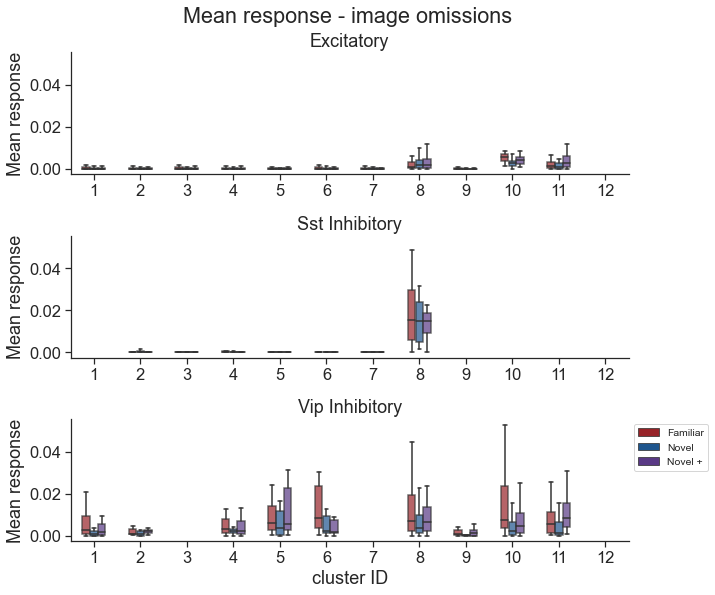

In [ ]:
metric = 'mean_response'

order = np.arange(0, n_clusters+1, 1)

figsize = (10, 9)
fig, ax = plt.subplots(3, 1, figsize=figsize, sharey=True, sharex=False)
for i, cre_line in enumerate(cre_lines):
    data = omission_response_metrics[omission_response_metrics.cre_line==cre_line]
    data = data[data.mean_response<np.percentile(data.mean_response.values, 97)]
    ax[i] = sns.boxplot(data=data, x='cluster_id', y=metric, order=order, showfliers=False,
                hue='experience_level', hue_order=experience_levels, palette=experience_level_colors, 
                width=0.5, boxprops=dict(alpha=.7), ax=ax[i])
    ax[i].set_title(utils.convert_cre_line_to_cell_type(cre_line))
    ax[i].get_legend().remove()
    ax[i].set_xlabel('')
    ax[i].set_ylabel('Mean response')
    ax[i].set_xticks(order+1)
    ax[i].set_xlim((0.5, n_clusters+0.5))
    ax[i].spines[['right', 'top']].set_visible(False)
ax[i].set_xlabel('cluster ID')  
ax[i].legend(bbox_to_anchor=(1,1), fontsize='xx-small', title_fontsize='xx-small')

plt.suptitle('Mean response - image omissions', x=0.51, y=0.95)
plt.subplots_adjust(hspace=0.5)

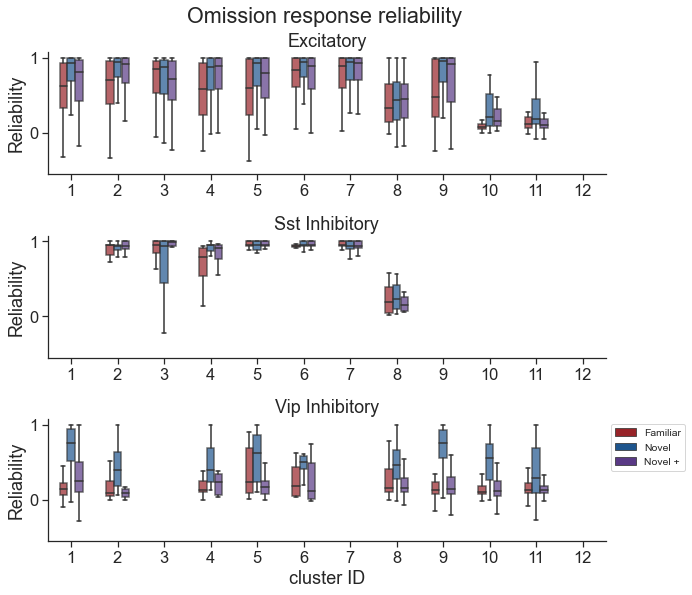

In [ ]:
metric = 'reliability'

order = np.arange(0, n_clusters+1, 1)

figsize = (10, 9)
fig, ax = plt.subplots(3, 1, figsize=figsize, sharey=True, sharex=False)
for i, cre_line in enumerate(cre_lines):
    data = omission_response_metrics[omission_response_metrics.cre_line==cre_line]
    ax[i] = sns.boxplot(data=data, x='cluster_id', y=metric, order=order, showfliers=False,
                hue='experience_level', hue_order=experience_levels, palette=experience_level_colors, 
                width=0.5, boxprops=dict(alpha=.7), ax=ax[i])
    ax[i].set_title(utils.convert_cre_line_to_cell_type(cre_line))
    ax[i].get_legend().remove()
    ax[i].set_xlabel('')
    ax[i].set_ylabel('Reliability')
    ax[i].set_xticks(order+1)
    ax[i].set_xlim((0.5, n_clusters+0.5))
    ax[i].spines[['right', 'top']].set_visible(False)
ax[i].set_xlabel('cluster ID')  
ax[i].legend(bbox_to_anchor=(1,1), fontsize='xx-small', title_fontsize='xx-small')

plt.suptitle('Omission response reliability', x=0.51, y=0.95)
plt.subplots_adjust(hspace=0.5)

### change response metrics

In [ ]:
data_type = 'filtered_events'

condition = 'changes'
stimuli = 'all_images'
session_subset = 'full_session'

# set inclusion criteria
# options: ['active_only', 'closest_familiar_and_novel', 'containers_with_all_levels', 'platform_experiment_table']
inclusion_criteria = 'platform_experiment_table'
    
change_response_metrics = cm.get_cell_metrics_for_conditions(data_type, condition, stimuli, session_subset, inclusion_criteria)

# convert experience level 
change_response_metrics['experience_level'] = [utils.convert_experience_level(experience_level) for experience_level in change_response_metrics.experience_level.values]

# limit to matched cells
change_response_metrics = change_response_metrics[change_response_metrics.cell_specimen_id.isin(matched_cells)]

# add cluster ID
change_response_metrics = change_response_metrics.merge(cluster_meta[[ 'cluster_id']], on='cell_specimen_id')

C:\Users\marinag\Documents\Code\AllenSDK\allensdk\api\cloud_cache\cloud_cache.py:521: OutdatedManifestWarning: You are loading visual-behavior-ophys_project_manifest_v1.0.1.json. A more up to date version of the dataset -- visual-behavior-ophys_project_manifest_v1.1.0.json -- exists online. To see the changes between the two versions of the dataset, run
VisualBehaviorOphysProjectCache.compare_manifests('visual-behavior-ophys_project_manifest_v1.0.1.json', 'visual-behavior-ophys_project_manifest_v1.1.0.json')
To load another version of the dataset, run
VisualBehaviorOphysProjectCache.load_manifest('visual-behavior-ophys_project_manifest_v1.1.0.json')
  warnings.warn(msg, OutdatedManifestWarning)


removing 1 problematic experiments
there are 402 experiments after filtering for inclusion criteria -  platform_experiment_table


  9%|▊         | 35/402 [00:08<01:07,  5.44it/s]

problem for experiment 891994418


 12%|█▏        | 50/402 [00:10<00:49,  7.10it/s]

problem for experiment 948507789


 23%|██▎       | 92/402 [00:18<00:39,  7.90it/s]

problem for experiment 994790561


 34%|███▍      | 138/402 [00:27<01:07,  3.91it/s]

problem for experiment 993369859


 35%|███▌      | 142/402 [00:28<01:14,  3.49it/s]

problem for experiment 993891845


 38%|███▊      | 154/402 [00:32<00:47,  5.19it/s]

problem for experiment 994082680


 45%|████▌     | 182/402 [00:41<01:19,  2.77it/s]

problem for experiment 851085100


 47%|████▋     | 188/402 [00:43<01:11,  2.97it/s]

problem for experiment 851085109


 48%|████▊     | 192/402 [00:44<00:49,  4.28it/s]

problem for experiment 851085105


 51%|█████     | 204/402 [00:47<00:49,  3.98it/s]

problem for experiment 991852002


 52%|█████▏    | 209/402 [00:49<01:02,  3.09it/s]

problem for experiment 991852001


 54%|█████▍    | 219/402 [00:52<00:46,  3.97it/s]

problem for experiment 991852004


 55%|█████▍    | 221/402 [00:52<00:48,  3.75it/s]

problem for experiment 991852005


 64%|██████▍   | 258/402 [01:06<00:51,  2.78it/s]

problem for experiment 977978321


 68%|██████▊   | 273/402 [01:11<00:33,  3.81it/s]

problem for experiment 981178537


 69%|██████▉   | 279/402 [01:12<00:36,  3.36it/s]

problem for experiment 882551935


 71%|███████   | 285/402 [01:14<00:31,  3.71it/s]

problem for experiment 882551937


 72%|███████▏  | 288/402 [01:15<00:28,  4.03it/s]

problem for experiment 882551947


 73%|███████▎  | 293/402 [01:16<00:27,  4.02it/s]

problem for experiment 951213203


 80%|████████  | 322/402 [01:25<00:25,  3.20it/s]

problem for experiment 1050762972


 81%|████████  | 326/402 [01:26<00:22,  3.45it/s]

problem for experiment 1051249031


 82%|████████▏ | 328/402 [01:26<00:18,  4.05it/s]

problem for experiment 1051423446


 86%|████████▌ | 346/402 [01:32<00:18,  3.03it/s]

problem for experiment 1076776838


 90%|█████████ | 362/402 [01:43<00:39,  1.01it/s]

problem for experiment 1078904675


 93%|█████████▎| 372/402 [01:49<00:17,  1.69it/s]

problem for experiment 1077597082


 93%|█████████▎| 374/402 [01:50<00:14,  1.96it/s]

problem for experiment 1082841182


100%|██████████| 402/402 [01:59<00:00,  3.36it/s]
c:\Users\marinag\Anaconda3\envs\visual_behavior_sdk\lib\site-packages\pandas\core\generic.py:2718: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['condition', 'data_type', 'exception', 'filter_events', 'interpolate',
       'ophys_experiment_id', 'session_subset', 'stimuli', 'use_events'],
      dtype='object')]

  encoding=encoding,


there are 376 experiments in the returned cell_metrics table


C:\Users\marinag\Documents\Code\AllenSDK\allensdk\api\cloud_cache\cloud_cache.py:521: OutdatedManifestWarning: You are loading visual-behavior-ophys_project_manifest_v1.0.1.json. A more up to date version of the dataset -- visual-behavior-ophys_project_manifest_v1.1.0.json -- exists online. To see the changes between the two versions of the dataset, run
VisualBehaviorOphysProjectCache.compare_manifests('visual-behavior-ophys_project_manifest_v1.0.1.json', 'visual-behavior-ophys_project_manifest_v1.1.0.json')
To load another version of the dataset, run
VisualBehaviorOphysProjectCache.load_manifest('visual-behavior-ophys_project_manifest_v1.1.0.json')
  warnings.warn(msg, OutdatedManifestWarning)
C:\Users\marinag\Documents\Code\AllenSDK\allensdk\api\cloud_cache\cloud_cache.py:521: OutdatedManifestWarning: You are loading visual-behavior-ophys_project_manifest_v1.0.1.json. A more up to date version of the dataset -- visual-behavior-ophys_project_manifest_v1.1.0.json -- exists online. To s

removing 1 problematic experiments


In [ ]:
print(len(change_response_metrics.mouse_id.unique()), 'mice')
print(len(change_response_metrics.ophys_experiment_id.unique()), 'experiments')
print(len(change_response_metrics.cell_specimen_id.unique()), 'cells')

65 mice
368 experiments
3901 cells


In [ ]:
change_response_metrics.keys()

Index(['cell_specimen_id', 'pref_image', 'non_pref_image',
       'image_selectivity_index', 'image_selectivity_index_one_vs_all',
       'lifetime_sparseness', 'mean_response',
       'fraction_significant_p_value_gray_screen', 'fano_factor',
       'reliability', 'running_modulation_index', 'hit_miss_index',
       'is_change', 'change_response', 'pre_change', 'pre_change_response',
       'change_modulation_index', 'ophys_experiment_id', 'condition',
       'session_subset', 'stimuli', 'data_type', 'interpolate',
       'output_sampling_rate', 'response_window', 'use_events',
       'filter_events', 'equipment_name', 'full_genotype', 'mouse_id',
       'reporter_line', 'driver_line', 'sex', 'age_in_days', 'cre_line',
       'indicator', 'session_number', 'prior_exposures_to_session_type',
       'prior_exposures_to_image_set', 'prior_exposures_to_omissions',
       'ophys_session_id', 'behavior_session_id', 'ophys_container_id',
       'project_code', 'imaging_depth', 'targeted_stru

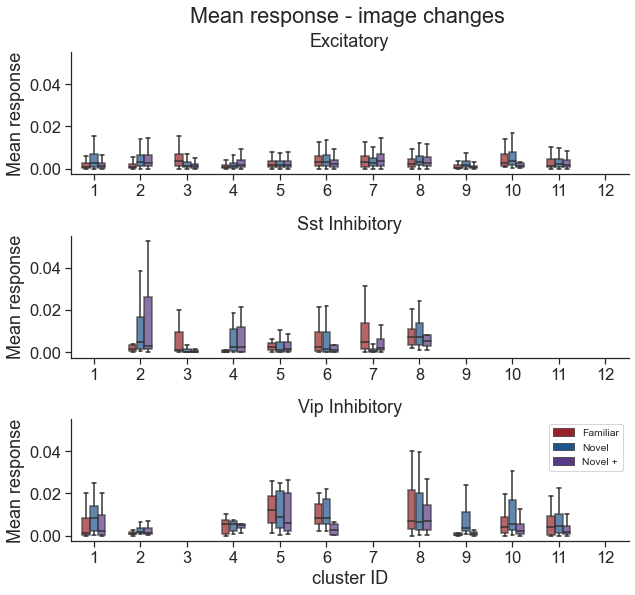

In [ ]:
metric = 'mean_response'

order = np.arange(0, n_clusters+1, 1)

figsize = (10, 9)
fig, ax = plt.subplots(3, 1, figsize=figsize, sharey=True, sharex=False)
for i, cre_line in enumerate(cre_lines):
    data = change_response_metrics[change_response_metrics.cre_line==cre_line]
    data = data[data.mean_response<np.percentile(data.mean_response.values, 97)]
    ax[i] = sns.boxplot(data=data, x='cluster_id', y=metric, order=order, showfliers=False,
                hue='experience_level', hue_order=experience_levels, palette=experience_level_colors, 
                width=0.5, boxprops=dict(alpha=.7), ax=ax[i])
    ax[i].set_title(utils.convert_cre_line_to_cell_type(cre_line))
    ax[i].get_legend().remove()
    ax[i].set_xlabel('')
    ax[i].set_ylabel('Mean response')
    ax[i].set_xticks(order+1)
    ax[i].set_xlim((0.5, n_clusters+0.5))
    ax[i].spines[['right', 'top']].set_visible(False)
ax[i].set_xlabel('cluster ID')  
ax[i].legend(bbox_to_anchor=(1,1), fontsize='xx-small', title_fontsize='xx-small')

plt.suptitle('Mean response - image changes', x=0.51, y=0.95)
plt.subplots_adjust(hspace=0.5)

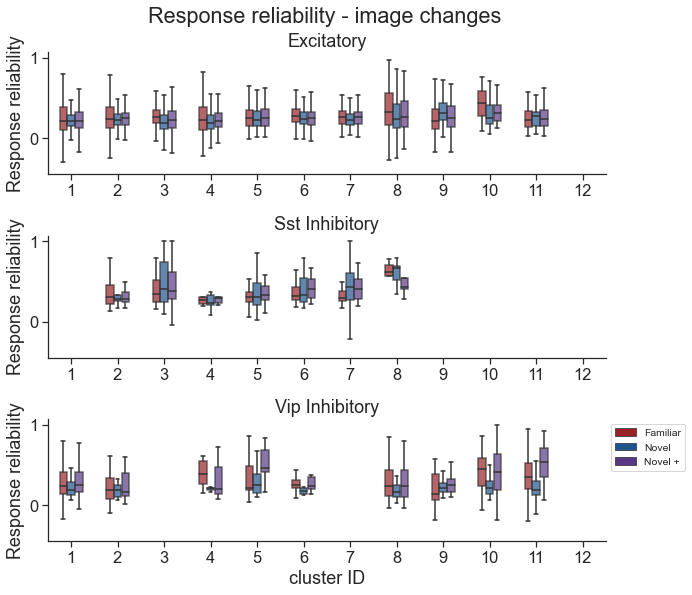

In [ ]:
metric = 'reliability'

order = np.arange(0, n_clusters+1, 1)

figsize = (10, 9)
fig, ax = plt.subplots(3, 1, figsize=figsize, sharey=True, sharex=False)
for i, cre_line in enumerate(cre_lines):
    data = change_response_metrics[change_response_metrics.cre_line==cre_line]
    data = data[data.mean_response<np.percentile(data.mean_response.values, 97)]
    ax[i] = sns.boxplot(data=data, x='cluster_id', y=metric, order=order, showfliers=False,
                hue='experience_level', hue_order=experience_levels, palette=experience_level_colors, 
                width=0.5, boxprops=dict(alpha=.7), ax=ax[i])
    ax[i].set_title(utils.convert_cre_line_to_cell_type(cre_line))
    ax[i].get_legend().remove()
    ax[i].set_xlabel('')
    ax[i].set_ylabel('Response reliability')
    ax[i].set_xticks(order+1)
    ax[i].set_xlim((0.5, n_clusters+0.5))
    ax[i].spines[['right', 'top']].set_visible(False)
ax[i].set_xlabel('cluster ID')  
ax[i].legend(bbox_to_anchor=(1,1), fontsize='xx-small', title_fontsize='xx-small')

plt.suptitle('Response reliability - image changes', x=0.51, y=0.95)
plt.subplots_adjust(hspace=0.5)

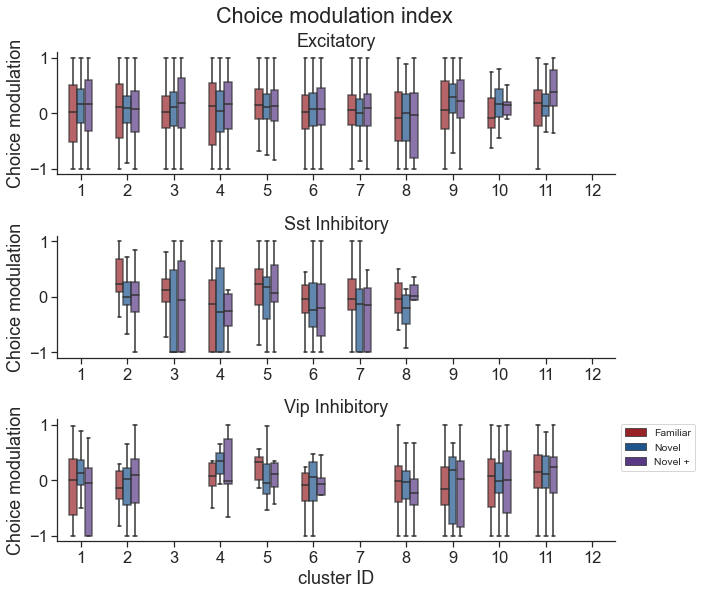

In [ ]:
metric = 'hit_miss_index'

order = np.arange(0, n_clusters+1, 1)

figsize = (10, 9)
fig, ax = plt.subplots(3, 1, figsize=figsize, sharey=True, sharex=False)
for i, cre_line in enumerate(cre_lines):
    data = change_response_metrics[change_response_metrics.cre_line==cre_line]
    ax[i] = sns.boxplot(data=data, x='cluster_id', y=metric, order=order, showfliers=False,
                hue='experience_level', hue_order=experience_levels, palette=experience_level_colors, 
                width=0.5, boxprops=dict(alpha=.7), ax=ax[i])
    ax[i].set_title(utils.convert_cre_line_to_cell_type(cre_line))
    ax[i].get_legend().remove()
    ax[i].set_xlabel('')
    ax[i].set_ylabel('Choice modulation')
    ax[i].set_xticks(order+1)
    ax[i].set_xlim((0.5, n_clusters+0.5))
    ax[i].spines[['right', 'top']].set_visible(False)
ax[i].set_xlabel('cluster ID')  
ax[i].legend(bbox_to_anchor=(1,1), fontsize='xx-small', title_fontsize='xx-small')

plt.suptitle('Choice modulation index', x=0.51, y=0.95)
plt.subplots_adjust(hspace=0.5)

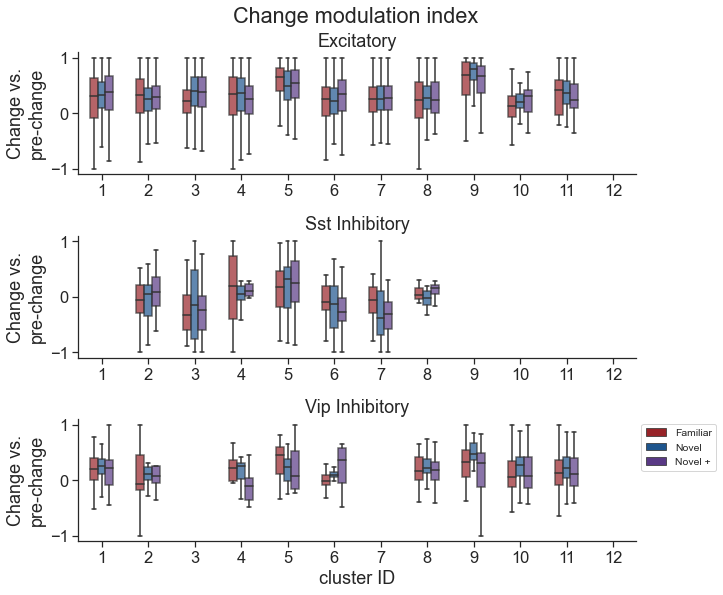

In [ ]:
metric = 'change_modulation_index'

order = np.arange(0, n_clusters+1, 1)

figsize = (10, 9)
fig, ax = plt.subplots(3, 1, figsize=figsize, sharey=True, sharex=False)
for i, cre_line in enumerate(cre_lines):
    data = change_response_metrics[change_response_metrics.cre_line==cre_line]
    ax[i] = sns.boxplot(data=data, x='cluster_id', y=metric, order=order, showfliers=False,
                hue='experience_level', hue_order=experience_levels, palette=experience_level_colors, 
                width=0.5, boxprops=dict(alpha=.7), ax=ax[i])
    ax[i].set_title(utils.convert_cre_line_to_cell_type(cre_line))
    ax[i].get_legend().remove()
    ax[i].set_xlabel('')
    ax[i].set_ylabel('Change vs.\npre-change')
    ax[i].set_xticks(order+1)
    ax[i].set_xlim((0.5, n_clusters+0.5))
    ax[i].spines[['right', 'top']].set_visible(False)
ax[i].set_xlabel('cluster ID')  
ax[i].legend(bbox_to_anchor=(1,1), fontsize='xx-small', title_fontsize='xx-small')

plt.suptitle('Change modulation index', x=0.51, y=0.95)
plt.subplots_adjust(hspace=0.5)

## Correlate model free metrics with coding score metrics

### get coding score metrics per experience level

In [ ]:
# model_free_metrics = generate_merged_table_of_model_free_metrics(data_type='filtered_events', 
#                                                                  session_subset='full_session', 
#                                                                  inclusion_criteria='platform_experiment_table',
#                                                                  save_dir=save_dir)

# cs_metrics = generate_coding_score_metrics_per_experience_level_table(cluster_meta, results_pivoted, save_dir=save_dir)

# m = cs_metrics.merge(model_free_metrics, on=['cell_specimen_id', 'experience_level'], how='left')
# m.head()

#### use function to create or load merged metrics table

In [ ]:
metrics = processing.generate_merged_table_of_coding_score_and_model_free_metrics(cluster_meta, results_pivoted,
                                                                 data_type='events',
                                                                 session_subset='full_session',
                                                                 inclusion_criteria='platform_experiment_table',
                                                                 save_dir=save_dir)

loading coding score and model free metrics table


In [ ]:
metrics.head()

Unnamed: 0  cell_specimen_id experience_level  all-images  omissions  \
0           0        1086489847         Familiar    0.000000   0.000000   
1           1        1086489847            Novel    0.060457   0.000000   
2           2        1086489847          Novel +    0.017832   0.000000   
3           3        1086489860         Familiar    0.000000   0.000000   
4           4        1086489860            Novel    0.910349   0.109417   

       task  behavioral  max_coding_score dominant_feature  \
0  0.000000    0.000000          0.971563       behavioral   
1  0.004045    0.084897          0.971563       behavioral   
2  0.009827    0.971563          0.971563       behavioral   
3  0.000000    0.000000          0.910349       all-images   
4  0.000000    0.000000          0.910349       all-images   

  dominant_experience_level  ...  reliability_omissions fano_factor_omissions  \
0                   Novel +  ...               0.207706              0.005503   
1                   Novel +  ...               0.138590              0.004321   
2                   Novel +  ...               0.370170             14.642192   
3                     Novel  ...              -0.096350              0.021461   
4                     Novel  ...               0.984905              0.000219   

  running_modulation_omissions omission_modulation_index  \
0                     1.000000                  0.236083   
1                     0.809736                 -0.437343   
2                     1.000000                       NaN   
3                    -0.999056                  0.758859   
4                    -1.000000                 -0.995171   

   mean_response_changes reliability_changes  fano_factor_changes  \
0               0.000409            0.059171            11.873009   
1               0.000919            0.040111             6.571821   
2               0.000717            0.055535             9.922126   
3               0.000367            0.236166            12.894412   
4               0.000850            0.109113             8.109726   

   running_modulation_changes change_modulation_index hit_miss_index  
0                    0.966062                0.158500      -1.000000  
1                    1.000000                0.553210      -0.487474  
2                    0.999194                0.114330      -0.770604  
3                    0.520983                0.198686       0.030793  
4                    0.100698                0.570924       0.384290  

[5 rows x 41 columns]

### plot distributions of metric values across clusters & exp levels

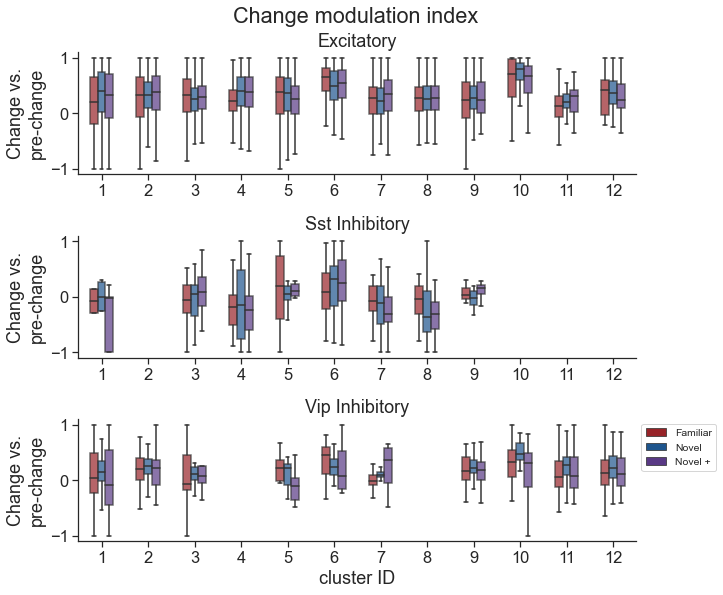

In [ ]:
metric = 'change_modulation_index'

order = np.arange(0, n_clusters+1, 1)

figsize = (10, 9)
fig, ax = plt.subplots(3, 1, figsize=figsize, sharey=True, sharex=False)
for i, cre_line in enumerate(cre_lines):
    data = metrics[metrics.cre_line==cre_line]
    ax[i] = sns.boxplot(data=data, x='cluster_id', y=metric, order=order, showfliers=False,
                hue='experience_level', hue_order=experience_levels, palette=experience_level_colors, 
                width=0.5, boxprops=dict(alpha=.7), ax=ax[i])
    ax[i].set_title(utils.convert_cre_line_to_cell_type(cre_line))
    ax[i].get_legend().remove()
    ax[i].set_xlabel('')
    ax[i].set_ylabel('Change vs.\npre-change')
    ax[i].set_xticks(order+1)
    ax[i].set_xlim((0.5, n_clusters+0.5))
    ax[i].spines[['right', 'top']].set_visible(False)
ax[i].set_xlabel('cluster ID')  
ax[i].legend(bbox_to_anchor=(1,1), fontsize='xx-small', title_fontsize='xx-small')

plt.suptitle('Change modulation index', x=0.51, y=0.95)
plt.subplots_adjust(hspace=0.5)